# Naive NUTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Note that NUTS is a special form of the HMC, and given the Bayesian model, related energies are computed as

- Kinetic energy: $\mathrm{KE} = \frac{1}{2}r^T \mathbf{M}^{-1}r$, where $r$ is the momentum vector and $\mathbf{M}$ is the mass matrix.

- Potential energy: $\mathrm{PE} = -\mathcal{L}(\boldsymbol{\theta}, \mathcal{D}) = -\log [p(\boldsymbol{\theta})p(\mathcal{D}\mid \boldsymbol{\theta})]$, where the interested parameters ($\boldsymbol{\theta}$) and the data ($\mathcal{D}$).

- Total/Hamiltonian energy: the sum of KE and PE.

Therefore the gradient of the **log joint density** of $\boldsymbol{\theta}$ and $\mathcal{D}$ (which is also the **negative potential gradient**, or the **unnormalised log-posterior density**) is computed as
$$
\begin{aligned}
\nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}, \mathcal{D}) &= \nabla_{\boldsymbol{\theta}} \log p(\boldsymbol{\theta})p(\mathcal{D}\mid \boldsymbol{\theta})\\
&= \nabla_{\boldsymbol{\theta}} \log p(\boldsymbol{\theta}) + \nabla_{\boldsymbol{\theta}} \log p(\mathcal{D}\mid \boldsymbol{\theta})\\
&= \frac{\nabla_{\boldsymbol{\theta}} p(\boldsymbol{\theta})}{p(\boldsymbol{\theta})} + \frac{\nabla_{\boldsymbol{\theta}} p(\mathcal{D}\mid\boldsymbol{\theta})}{p(\mathcal{D}\mid\boldsymbol{\theta})}
\end{aligned}
$$

Hence for a fixed Bayesian model, mass matrix $\mathbf{M}$, and data $\mathcal{D}$, we can compute all energies and log joint probability (negative potential energy gradient) at any position-momentum pair $(\boldsymbol{\theta}, r)$. This can be done by using <code>sympy</code> module for symbolic expressions.

In [2]:
def state_energy(theta, log_joint_density,
                 r, M):
    """
    Compute the Hamiltonian energy for a given state, including the KE and PE.
    
    Args:
        theta (np.ndarray): The parameter position vector.
        log_joint_density (callable): Function to compute the log joint density.
        r (np.ndarray): The latent momentum vector.
        M (np.ndarray): The mass matrix. Default is the identity matrix with the same dimension as theta.
    """

    # Compute the inverse of the mass matrix
    M_inv = np.linalg.inv(M)

    # Compute the kinetic energy in terms of momentum and inverse mass matrix
    kinetic_energy = 0.5 * r.T @ M_inv @ r
    # Compute the potential energy from the negative log joint density (for a known data)
    potential_energy = -log_joint_density(theta)

    # Total energy is the sum of kinetic and potential energies
    hamiltonian_energy = kinetic_energy + potential_energy

    return kinetic_energy, potential_energy, hamiltonian_energy

In [3]:
def leapfrog(theta, r, v, 
             grad_log_joint_density, M, eps=0.1):
    """Performs a single leapfrog integration step.

    Args:
        theta (np.ndarray): Current position vector.
        r (np.ndarray): Current momentum vector, as a latent variable.
        v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        M (np.ndarray): The mass matrix.
        eps (float): Stepsize for the integration. Default is 0.1.

    Returns:
        tuple: Updated position and momentum vectors.
    """

    M_inv = np.linalg.inv(M)

    # Half momentum update
    r_half = r + 0.5 * eps * v * grad_log_joint_density(theta)
    
    # Full position update
    theta_full = theta + v * eps * (M_inv @ r_half)
    
    # Half momentum update
    r_full = r_half + 0.5 * eps * v * grad_log_joint_density(theta_full)
    
    return theta_full, r_full

An illustration for the <code>build_tree</code> function: the argument $j$ represents the height/depth of the tree built, so in total we will return a binary tree with total $2^j$ position-momentum pairs, which composed by (if we assume for the transition from height-($j-1$) tree to height-$j$ tree is forward):

- Left part subtree: $2^{j-1}$ position-momentum pairs from the previous height-($j-1$) tree.

- Right part subtree: newly generated $2^{j-1}$ position-momentum pairs, by corresponding $2^{j-1}$ forward leapfrog steps for each pair in the left part subtree.

**Example:** we would illustrate the special case for $j=0$ and $j=1$.

- For $j=0$, <code>build_tree</code> should just return one position-momentum pair $(\boldsymbol{\theta'}, r')$ from a single leapfrog step. The leapfrog step may start from a different, randomly selected pair, but we would only use the result from the leapfrog tree for our binary tree, with height $2^0=1$. Of course, $(\boldsymbol{\theta'}, r')$ only requires to meet the energy condition.

- For $j=1$, <code>build_tree</code> should first generate $2^{1-1} = 1$ pair for the height-0 subtree (this would be treated as either the left or right part subtree, depending on the direction of the leapfrog step), then, treated this generated pair as the basis, further construct another pair by 1 leapfrog step in required direction. There are hence total 2 pairs for the height-1 tree. 

In [4]:
def build_tree(theta, r, log_u, v, j, M,
               log_joint_density, grad_log_joint_density, 
               eps=0.1, delta_max=1000):
    """
    Recursively builds a binary tree of height-j for the naive NUTS algorithm,
    so in total there are 2^j steps/leapfrog integrations, with total 2^j position-momentum pairs.

    Args:
        theta (np.ndarray): Current position vector.
        r (np.ndarray): Current momentum vector, as a latent variable.
        log_u (float): Log slice variable, log-value for avoiding overflow.
        v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
        j (int): Current height/depth of the tree (start from 0).
        M (np.ndarray): The mass matrix. Default is the identity matrix with the same dimension as theta.
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        eps (float): Stepsize for the leapfrog integration. Default is 0.1.
        delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
    Returns:
        tuple: Leftmost position-momentum pair, rightmost position-momentum pair, 
               accepted state/sample set (list) C, stop indicator s (by both U-turn condition and energy condition).
    """

    # Base case: when we start our tree with height 0
    if j == 0:
        # Take one leapfrog step in the direction v
        theta_prime, r_prime = leapfrog(theta, r, v, grad_log_joint_density, M, eps)
        
        # Compute the exponential of the negative Hamiltonian energy at the generated position-momentum pair
        # whether or not we should accept this new position-momentum pair in C_prime
        _, _, hamiltonian_energy = state_energy(theta_prime, log_joint_density, r_prime, M)
        if log_u <= -hamiltonian_energy:
            C_prime = [(theta_prime, r_prime)]  # Accepted set C contains the new state
        else:
            C_prime = []  # No accepted state (empty set/list)

        # Check if we should stop (energy condition), compute the stop indicator s_print
        s_prime = int(log_u - delta_max < -hamiltonian_energy)

        # for j=0, meaning the tree is of height-0 and we only have one position-momentum pair,
        # which is the theta_prime, r_prime generated from the single leapfrog step (note (theta, r) as the argument is not included)
        return theta_prime, r_prime, theta_prime, r_prime, C_prime, s_prime

    else:
        # Recursion: build the left and right subtrees, following the doubling process
        # note that we represent the tree building process from height j-1 to j, in total we have 2^j position-momentum pairs
        theta_minus, r_minus, theta_plus, r_plus, C_prime, s_prime = build_tree(
            theta, r, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
        )

        if v == -1:
            theta_minus, r_minus, _, _, C_double_prime, s_double_prime = build_tree(
                theta_minus, r_minus, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
            )
        else:
            _, _, theta_plus, r_plus, C_double_prime, s_double_prime = build_tree(
                theta_plus, r_plus, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
            )

        # Update the stop indicator s by combining s_prime and s_double_prime, checking both energy and U-turn conditions
        u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
        s_prime = s_prime * s_double_prime * u_turn_indicator

        # Combine the accepted states from both subtrees, as the union of C_prime and C_double_prime
        # since our C_prime and C_double_prime are lists from the base case build_tree calls, so we can use list addition
        C_prime += C_double_prime

        return theta_minus, r_minus, theta_plus, r_plus, C_prime, s_prime

## Monitoring the acceptance probability for naive NUTS

Unlike HMC, since there is no single accept/reject step in NUTS, we may define **an acceptance probability that HMC would give to the position-momentum pair explored during the final doubling iteration.**

In other words, consider our tree meets the stopping criteria at time $t$ ($t$-th iteration), $C_t$ is the set of all states explored during the final doubling of iteration $t$, this 'average acceptance probability' means, given the previous position $\theta_{t-1}$ (momentum is treated as an auxilliary variable), every position-momentum pair in $C_t$ can be seen as the state after $L$ leapfrog steps in HMC, and we accept/reject each of them by using the Metropolis step in HMC, carrying along with total $|C_t|$ pairs that pass the slice variable test. i.e. we may monitor the term:

$$
\frac{1}{|C_t|}\sum_{\theta, r \in C_t} \min \left(1, \frac{p(\theta, r)}{p(\theta^{t-1}, r^{t, 0})}\right) = \frac{1}{|C_t|}\sum_{\theta, r \in C_t} \min \left(1, \exp[H(\theta_{t-1}, r^{t,0}) - \exp(H(\theta, r))] \right)
$$

- $t$ is the time that our doubling step terminates (time for the generated tree meets the stopping criteria).

- $C_t$ is the set of all states explored during the final doubling of iteration $t$.

- $\theta^{t-1}$ is the previous chosen position state in the last iteration.

- $r^{t,0}$ is the resampled momentum start from the iteration $t$ (since momentum is treated as the auxilliary variable we shall just record the resampled term but not the previous $r^{t-1}$).

- $H(\theta, r) = \frac{1}{2}r.r - \mathcal{L}(\theta) = \frac{1}{2}r.r - \log p(\theta)p(\mathcal{D}|\theta)$ represents the Hamiltonian energy at $(\theta, r)$.

Meanwhile, we may also monitor the number of samples that stay at the previous position (i.e. does not move). This can be done by counting of <code>num_samples_stayed</code>.

In [10]:
def naive_NUTS(theta0, num_samples, 
               log_joint_density, grad_log_joint_density, M,
               eps=0.1, delta_max=1000, monitor_results_print = True):

    dim = theta0.shape[0]  # record the dimension (of the posterior distribution)
    theta = theta0  # initialise the current position with theta0
    samples = np.zeros((num_samples, dim))  # initialise to store the samples with correct shape
    num_samples_stayed = 0  # initialise the number of samples that stayed (do not move)

    for m in range(num_samples):
        # Resample momentum for every iteration (with covariance as mass matrix M)
        r0 = np.random.multivariate_normal(mean=np.zeros(dim), cov=M)
        # Resample the slice variable for every iteration
        _, _, H0 = state_energy(theta, log_joint_density, r0, M)  # store the current Hamiltonian energy H0 = H(previous position, resampled momentum)

        # U ~ Unif(0, exp(-H0)) = exp(-H0)Unif(0,1) <-> log_u = -H0 + log(Unif(0,1)), avoid overflow
        log_u = -H0 + np.log(np.random.uniform(low=0, high=1))

        # Initialise the binary tree at height j=0
        theta_minus, theta_plus = theta, theta
        r_minus, r_plus = r0, r0
        j = 0
        C = [(theta, r0)]
        s = 1  # initialise the stop indicator s to 1 so the tree can start growing

        while s == 1:  # expand the tree for neither satisfying U-turn nor energy condition
            # Randomly choose the direction (-1, 1) to build the tree
            v = np.random.choice([-1, 1])

            if v == -1:  # build the left subtree
                theta_minus, r_minus, _, _, C_prime, s_prime = build_tree(
                    theta_minus, r_minus, log_u, v, j, M,
                    log_joint_density, grad_log_joint_density, eps=eps, delta_max=delta_max
                )
            else:  # build the right subtree
                _, _,  theta_plus, r_plus, C_prime, s_prime = build_tree(
                    theta_plus, r_plus, log_u, v, j, M,
                    log_joint_density, grad_log_joint_density, eps=eps, delta_max=delta_max
                )

            if s_prime == 1:  # newly generated subtree (left/right) is valid (not stopped by U-turn or energy condition)
                C += C_prime  # combine the accepted states from the new subtree into C

            # Update the stop indicator s by checking U-turn condition between the leftmost and rightmost position-momentum pairs
            s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
            j += 1  # increase the height of the tree

        # Finally we sample one position-momentum pair from the accepted set C
        theta, _ = C[np.random.choice(len(C))]  # randomly choose one accepted position

        # Append theta picked this iteration to samples
        samples[m, :] = theta

        # Finally compute the average acceptance probability for NUTS, with all states in C
        accept_prob = 0  # initialise the average acceptance prob for NUTS
        for pos, mmt in C:
            _, _, H_curr = state_energy(theta=pos, log_joint_density=log_joint_density, r=mmt, M=M)  # H(theta, r) for (theta, r) in the final collection
            accept_prob += min(1, np.exp(H0 - H_curr))  # summation (without averaging)

        if np.allclose(theta, samples[m-1, :]):
            num_samples_stayed += 1

    avg_accept_prob = accept_prob/len(C)

    if monitor_results_print:
        print(f'There are total {num_samples_stayed} out of {num_samples} samples do not move w.r.t the previous position.\n'
              f'The proportion of moving is {1 - num_samples_stayed/num_samples:.3f}.')

    return samples, C, avg_accept_prob   # average the acceptance probability in the end

Simple example 1: posterior distribution as the standard bivariate Gaussian distribution in dimension 2 (so $\boldsymbol{\theta} = (\theta_1, \theta_2) \in \mathbb{R}^2, r \in \mathbb{R}^2$ and the position-momentum pair is 4D), also with the identity mass matrix (of dimension 2) and all default stepsize.

In [11]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

samples, C, avg_accept_prob = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M, eps=0.1, delta_max=1e3)  # approx 2 min on PC

There are total 57 out of 1000 samples do not move w.r.t the previous position.
The proportion of moving is 0.943.


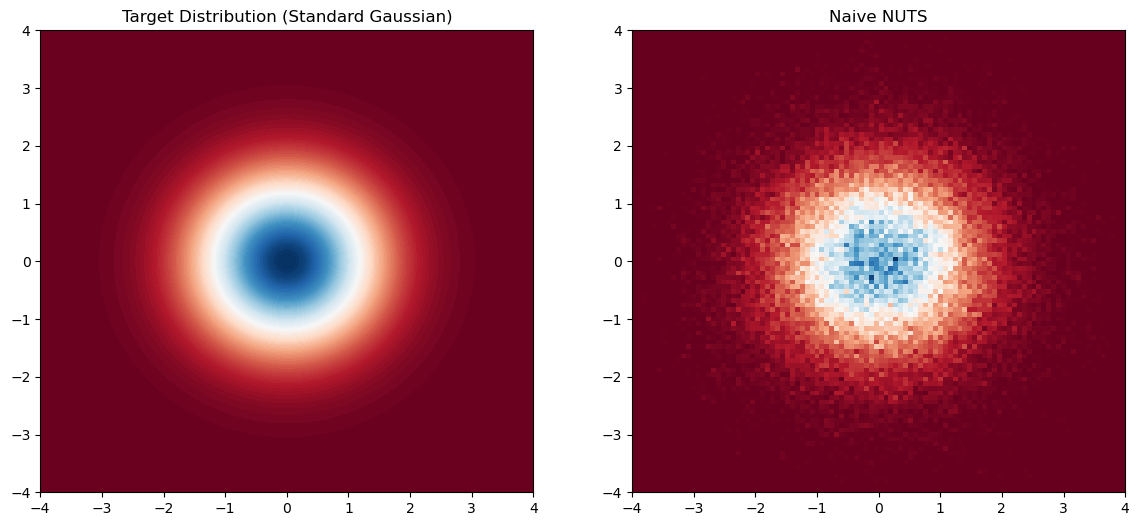

The average acceptance probability: 1.0


In [7]:
# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-4, 4, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Standard Gaussian)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0  # if we do not consider burnin samples...
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
plt.title('Naive NUTS')
plt.show()

print('The average acceptance probability:', avg_accept_prob)

**Remarks: setting of different stepsizes ($\epsilon$) and accepted probability**

- $\epsilon = 0.1$: accepted probability roughly 0.99, good sampling performance.

- $\epsilon = 0.5$: accepted probability roughly 0.94, good sampling performance (but worse than $\epsilon=0.1$).

- $\epsilon = 1$: accepted probability roughly 0.99?

Example 2: 2D Banana density with the target (posterior) distribution be in the form:

$$
p(\boldsymbol{\theta}) = p(\theta_1, \theta_2) \propto \exp(-\theta_1^2/10 - \theta_2^2/10 - 2(\theta_1 - \theta_2^2)^2)
$$

Note that for the banana density (unnormalised form), it is actually written as
$$
\exp\left(-\frac{(x - \mu_x)^2}{\sigma_x^2} - \frac{(y-\mu_y)^2}{\sigma_y^2} - k[(x-\mu_x) - (y-\mu_y)^2]^2\right)
$$

In [8]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 10 - theta[1]**2 / 10 - 2*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 5 + 8 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 5 - 4 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

samples, C, avg_acceptance_prob = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 2 min on PC

There are total 12126 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.879.


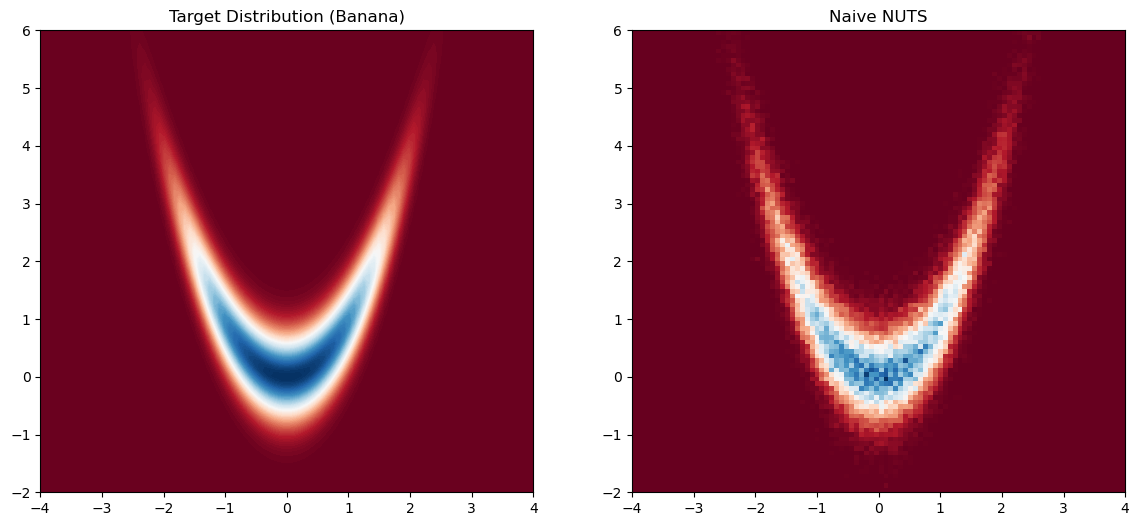

The average acceptance probability: 0.9981830648508822


In [9]:
# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 10 - y**2 / 10 - 2 * (y - x**2)**2

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_banana(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Banana)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-2, 6]], cmap='RdBu', density=True)
plt.title('Naive NUTS')
plt.show()

print('The average acceptance probability:', avg_acceptance_prob)

We may also try to alter the shape/curvature of the banana density to see its sampling performance.

**We may encounter numerical overflow - although it can still sample, the performance is significantly lower.**

In [10]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

samples, C, avg_acceptance_prob = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2942252955.py:14: RuntimeWarning: overflow encountered in scalar multiply
  partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1494134929.py:17: RuntimeWarning: invalid value encountered in matmul
  kinetic_energy = 0.5 * r.T @ M_inv @ r
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2942252955.py:10: RuntimeWarning: overflow encountered in scalar power
  return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2225528151.py:61: RuntimeWarning: overflow encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2225528151.py:61: RuntimeWarning: invalid value encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus 

There are total 27342 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.727.


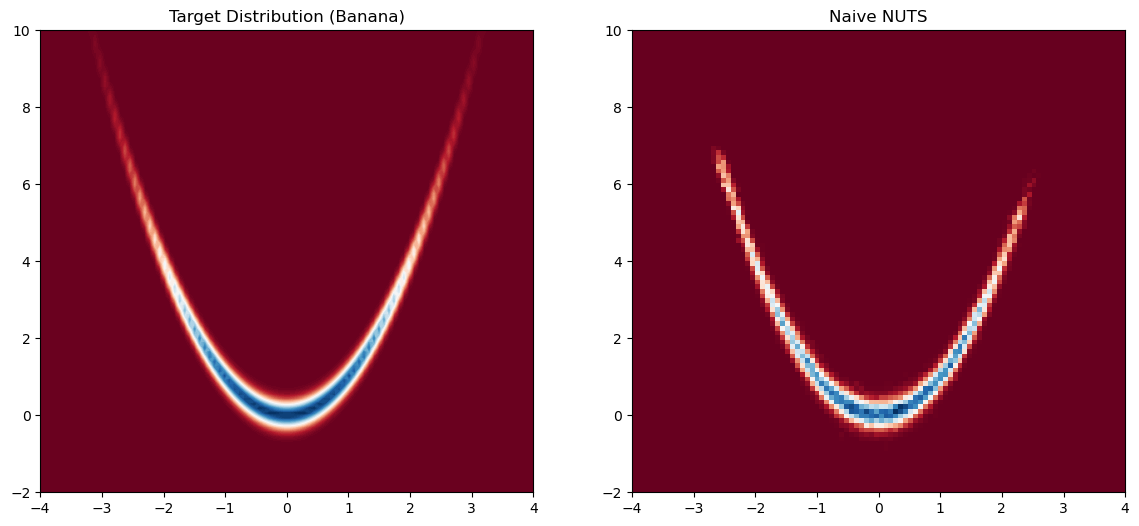

The average acceptance probability: 0.9996131697747761


In [11]:
# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 30 - y**2 / 30 - 10 * (y - x**2)**2

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 10, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_banana(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Banana)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-2, 10]], cmap='RdBu', density=True)
plt.title('Naive NUTS')
plt.show()

print('The average acceptance probability:', avg_acceptance_prob)

Let's also try different starting point and stepsizes.

In [12]:
theta0 = np.array([1.0, 2.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

samples, C, avg_acceptance_prob = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1341050336.py:14: RuntimeWarning: overflow encountered in scalar multiply
  partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1494134929.py:17: RuntimeWarning: invalid value encountered in matmul
  kinetic_energy = 0.5 * r.T @ M_inv @ r
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1341050336.py:10: RuntimeWarning: overflow encountered in scalar power
  return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2225528151.py:61: RuntimeWarning: overflow encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2225528151.py:61: RuntimeWarning: invalid value encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus 

There are total 31899 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.681.


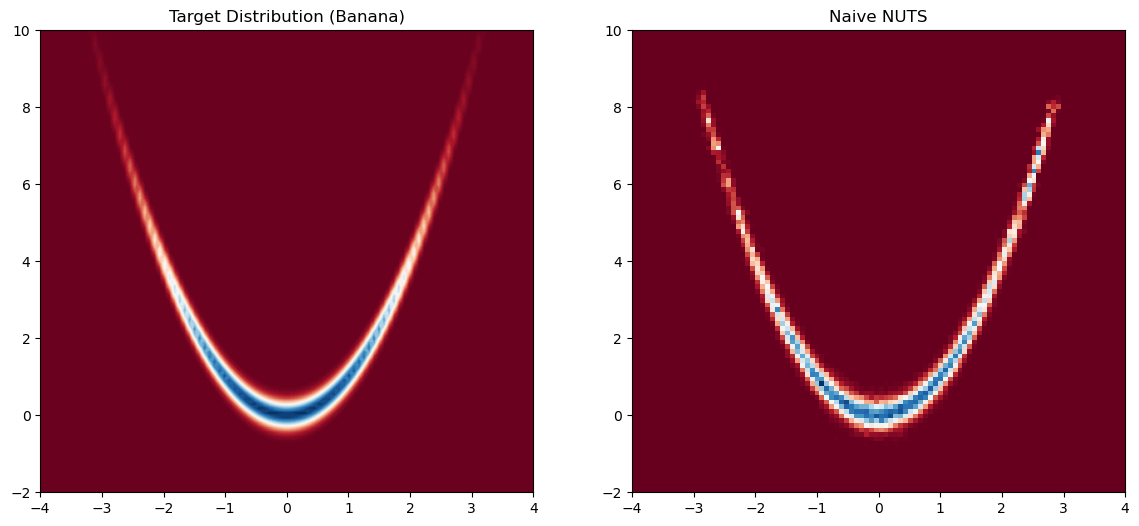

The average acceptance probability: 0.9917684801667085


In [13]:
# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 30 - y**2 / 30 - 10 * (y - x**2)**2

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 10, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_banana(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Banana)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-2, 10]], cmap='RdBu', density=True)
plt.title('Naive NUTS')
plt.show()

print('The average acceptance probability:', avg_acceptance_prob)

# Efficient NUTS

We will only change <code>build_tree</code> and <code>naive_NUTS</code> to achieve the efficient NUTS.

In [14]:
def build_tree_eff(theta, r, log_u, v, j, M,
               log_joint_density, grad_log_joint_density, 
               eps=0.1, delta_max=1000):
    """
    Recursively builds a binary tree of height-j for the efficient NUTS algorithm,
    so in total there are 2^j steps/leapfrog integrations, with total 2^j position-momentum pairs.

    Args:
        theta (np.ndarray): Current position vector.
        r (np.ndarray): Current momentum vector, as a latent variable.
        log_u (float): Log slice variable, log-value for avoiding overflow.
        v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
        j (int): Current height/depth of the tree (start from 0).
        M (np.ndarray): The mass matrix. Default is the identity matrix with the same dimension as theta.
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        eps (float): Stepsize for the leapfrog integration. Default is 0.1.
        delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
    Returns:
        tuple: Leftmost position-momentum pair, rightmost position-momentum pair, 
               accepted state/sample set (list) C, stop indicator s (by both U-turn condition and energy condition).
    """

    # Base case: when we start our tree with height 0
    if j == 0:
        # Take one leapfrog step in the direction v
        theta_prime, r_prime = leapfrog(theta, r, v, grad_log_joint_density, M, eps)
        
        # Compute the exponential of the negative Hamiltonian energy at the generated position-momentum pair
        # whether or not we should accept this new position-momentum pair in C_prime
        _, _, hamiltonian_energy = state_energy(theta_prime, log_joint_density, r_prime, M)
        if log_u <= -hamiltonian_energy:
            n_prime = 1  # number of accepted states in C_prime (corresponding to naive NUTS setting)
        else:
            n_prime = 0  # no accepted value, the tree would not be generated

        # Check if we should stop (energy condition), compute the stop indicator s_print
        s_prime = int(log_u - delta_max < -hamiltonian_energy)

        # for j=0, meaning the tree is of height-0 and we only have one position-momentum pair,
        # which is the theta_prime, r_prime generated from the single leapfrog step (note (theta, r) as the argument is not included)
        return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime

    else:
        # Recursion: build the left and right subtrees, following the doubling process
        # note that we represent the tree building process from height j-1 to j, in total we have 2^j position-momentum pairs
        theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime = build_tree_eff(
            theta, r, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
        )

        if v == -1:
            theta_minus, r_minus, _, _, theta_double_prime, n_double_prime, s_double_prime = build_tree_eff(
                theta_minus, r_minus, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
            )
        else:
            _, _, theta_plus, r_plus, theta_double_prime, n_double_prime, s_double_prime = build_tree_eff(
                theta_plus, r_plus, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
            )

        # Metropolis step to choose between theta_prime and theta_double_prime
        # Generate a uniform random number for the Metropolis step
        if n_prime + n_double_prime > 0:  # avoid division by zero
            if np.random.uniform(0, 1) < n_double_prime / (n_prime + n_double_prime):
                theta_prime = theta_double_prime  # update

        # Update the stop indicator s by checking both energy and U-turn conditions
        u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
        s_prime = s_double_prime * u_turn_indicator

        # Update the total number of accepted states from both subtrees
        n_prime += n_double_prime

        return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime

In [439]:
def eff_NUTS(theta0, num_samples, 
             log_joint_density, grad_log_joint_density, M,
             eps=0.1, delta_max=1000, monitor_results_print=True):

    dim = theta0.shape[0]  # record the dimension (of the posterior distribution)
    theta = theta0  # initialise the current position with theta0
    samples = np.zeros((num_samples, dim))  # initialise to store the samples with correct shape
    num_samples_stayed = 0

    for m in range(num_samples):
        # Resample momentum for every iteration (with covariance as mass matrix M)
        r0 = np.random.multivariate_normal(mean=np.zeros(dim), cov=M)
        # Resample the slice variable for every iteration
        _, _, H0 = state_energy(theta, log_joint_density, r0, M)  # store the current Hamiltonian energy H0

        # U ~ Unif(0, exp(-H0)) = exp(-H0)Unif(0,1) <-> log_u = -H0 + log(Unif(0,1)), avoid overflow
        log_u = -H0 + np.log(np.random.uniform(low=0, high=1))

        # Initialise the binary tree at height j=0
        theta_minus, theta_plus = theta, theta
        r_minus, r_plus = r0, r0
        j = 0  # initialise the height of the tree
        n = 1  # initialise the number of accepted states (start from one single node)
        s = 1  # initialise the stop indicator s to 1 so the tree can start growing

        while s == 1:  # expand the tree for neither satisfying U-turn nor energy condition
            # Randomly choose the direction (-1, 1) to build the tree
            v = np.random.choice([-1, 1])

            if v == -1:  # build the left subtree
                theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime = build_tree_eff(
                    theta_minus, r_minus, log_u, v, j, M,
                    log_joint_density, grad_log_joint_density, eps=eps, delta_max=delta_max
                )
            else:  # build the right subtree
                _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime = build_tree_eff(
                    theta_plus, r_plus, log_u, v, j, M,
                    log_joint_density, grad_log_joint_density, eps=eps, delta_max=delta_max
                )

            if s_prime == 1:  # newly generated subtree (left/right) is valid (not stopped by U-turn or energy condition)
                # Apply the efficient NUTS transition kernel directly here by updating theta
                if np.random.uniform(0, 1) < n_prime / n:
                    theta = theta_prime  # update

            # Update the total number of accepted states
            n += n_prime

            # Update the stop indicator s by checking U-turn condition between the leftmost and rightmost position-momentum pairs
            s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
            j += 1  # increase the height of the tree

        # Append theta picked this iteration to samples
        samples[m, :] = theta

        if np.allclose(theta, samples[m-1, :]):
            num_samples_stayed += 1

    if monitor_results_print:
        print(f'There are total {num_samples_stayed} out of {num_samples} samples do not move w.r.t the previous position.\n'
              f'The proportion of moving is {1 - num_samples_stayed/num_samples:.3f}.')
        
    return samples

In [16]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

samples = eff_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approx 1-2 min on PC (sometimes more efficient)

There are total 1 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 1.000.


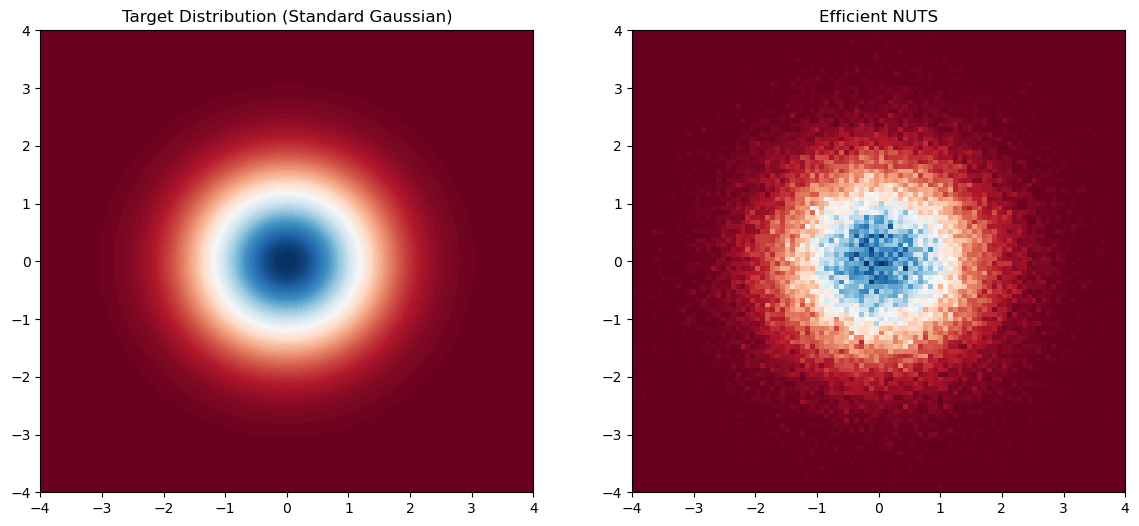

In [17]:
# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-4, 4, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Standard Gaussian)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
plt.title('Efficient NUTS')
plt.show()

In [18]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 10 - theta[1]**2 / 10 - 2*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 5 + 8 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 5 - 4 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

samples = eff_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approx 1-1.5 min on PC (sometimes more efficient)

There are total 229 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.998.


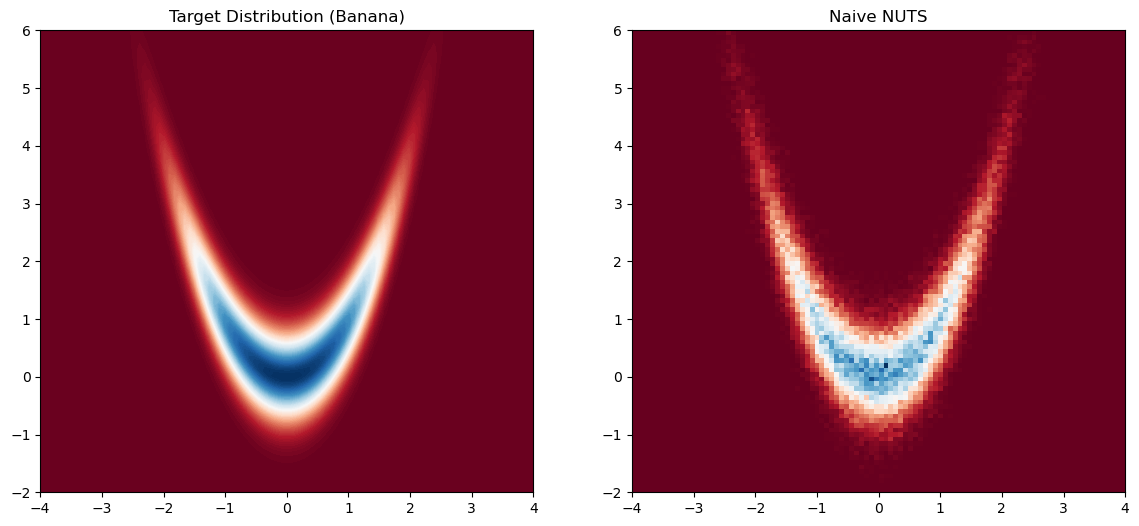

In [19]:
# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 10 - y**2 / 10 - 2 * (y - x**2)**2

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_banana(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Banana)')

burn_in = int(0.2 * num_samples)  # 20% burn-in
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-2, 6]], cmap='RdBu', density=True)
plt.title('Naive NUTS')
plt.show()

**Efficient NUTS achieve higher proportion of moving than Naive NUTS!**

---

# Adaptive scheme for stepsize $\epsilon$

In [20]:
def find_reasonable_eps(theta, log_joint_density, grad_log_joint_density, M, v=1):
    """
    Find a reasonable initial stepsize epsilon for HMC/NUTS.
    Args:
        theta (np.ndarray): Current position vector.
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        M (np.ndarray): The mass matrix.
        v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward). Default is 1.
    """

    eps = 1.0  # initial guess
    d = theta.shape[0]  # dimension
    r = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d))

    theta_prime, r_prime = leapfrog(theta, r, v, grad_log_joint_density, M, eps)
    
    _, _, H0 = state_energy(theta, log_joint_density, r, M)
    _, _, H_prime = state_energy(theta_prime, log_joint_density, r_prime, M)

    accept_prob = np.exp(H0 - H_prime)
    a = 1 if accept_prob > 0.5 else -1  # +1 if accept_prob > 0.5 else -1

    while (accept_prob ** a) > (2 ** (-a)):
        eps = eps * (2 ** a)
        theta_prime, r_prime = leapfrog(theta, r, v, grad_log_joint_density, M, eps)

        # Update the energy and accept_prob
        _, _, H_prime = state_energy(theta_prime, log_joint_density, r_prime, M)
        accept_prob = np.exp(H0 - H_prime)
    return eps

Follow the adaptive scheme described in Hoffman, given the previous position $\theta_{t-1}$ (momentum is treated as an auxilliary variable), every position-momentum pair in $\mathcal{B}_t^{{\text{final}}}$ can be seen as the state after $L$ leapfrog steps in HMC, and we accept/reject each of them by using the Metropolis step in HMC, carrying along with total $|\mathcal{B}_t^{{\text{final}}}|$ pairs that pass the slice variable test. i.e. we may monitor the term:

$$
\frac{1}{|\mathcal{B}_t^{{\text{final}}}|}\sum_{\theta, r \in \mathcal{B}_t^{\text{final}}} \min \left(1, \frac{p(\theta, r)}{p(\theta^{t-1}, r^{t, 0})}\right) = \frac{1}{|\mathcal{B}_t^{{\text{final}}}|}\sum_{\theta, r \in \mathcal{B}_t^{\text{final}}} \min \left(1, \exp[H(\theta_{t-1}, r^{t,0}) - \exp(H(\theta, r))] \right)
$$

- $t$ is the time that our doubling step terminates (time for the generated tree meets the stopping criteria).

- $\mathcal{B}_t^{\text{final}}$ is the set of all states explored during the final doubling of iteration $t$.

- $\theta^{t-1}$ is the previous chosen position state in the last iteration.

- $r^{t,0}$ is the resampled momentum start from the iteration $t$ (since momentum is treated as the auxilliary variable we shall just record the resampled term but not the previous $r^{t-1}$).

- $H(\theta, r) = \frac{1}{2}r.r - \mathcal{L}(\theta) = \frac{1}{2}r.r - \log p(\theta)p(\mathcal{D}|\theta)$ represents the Hamiltonian energy at $(\theta, r)$.

In <code>build_tree_adapt</code>, we denote 

- <code>n_alpha_prime</code> represents $|\mathcal{B}_t^{\text{final}}|$, as a count. For tree height-0 it starts from 1. <code>n_alpha_prime</code> is different from <code>n_prime</code>, where the latter one is $|C_t|$ for the whole collection of states.

- <code>alpha_double_prime</code> as the single acceptance probability w.r.t the previous state and resampled momentum. i.e. 
    $$
    \alpha'' = \min \left(1, \exp[H(\theta_{t-1}, r^{t,0}) - \exp(H(\theta, r))] \right)
    $$

- <code>alpha_prime</code> as the sum of all <code>alpha_double_prime</code> to denote
    $$
    \alpha' = \sum_{\theta, r \in \mathcal{B}_t^{\text{final}}} \min \left(1, \exp[H(\theta_{t-1}, r^{t,0}) - \exp(H(\theta, r))] \right)
    $$

In [21]:
def build_tree_adapt(theta, r, theta0, r0, log_u, v, j, M,
               log_joint_density, grad_log_joint_density, 
               eps=0.1, delta_max=1000):
    """
    Recursively builds a binary tree of height-j for the adaptive NUTS algorithm using dual averaging,
    so in total there are 2^j steps/leapfrog integrations, with total 2^j position-momentum pairs.

    Args:
        theta (np.ndarray): Current position vector.
        r (np.ndarray): Current momentum vector, as a latent variable.
        theta0 (np.ndarray): Initial position vector at the start of the trajectory.
        r0 (np.ndarray): Initial momentum vector at the start of the trajectory.
        log_u (float): Log slice variable, log-value for avoiding overflow.
        v (int): Direction of the leapfrog step, either +1 (forward) or -1 (backward).
        j (int): Current height/depth of the tree (start from 0).
        M (np.ndarray): The mass matrix. Default is the identity matrix with the same dimension as theta.
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        eps (float): Stepsize for the leapfrog integration. Default is 0.1.
        delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
    Returns:
        tuple: Leftmost position-momentum pair, rightmost position-momentum pair, 
               accepted state/sample set (list) C, stop indicator s (by both U-turn condition and energy condition).
    """

    # Base case: when we start our tree with height 0
    if j == 0:
        # Take one leapfrog step in the direction v
        theta_prime, r_prime = leapfrog(theta, r, v, grad_log_joint_density, M, eps)
        
        # Compute the exponential of the negative Hamiltonian energy at the generated position-momentum pair
        # whether or not we should accept this new position-momentum pair in C_prime
        _, _, hamiltonian_energy = state_energy(theta_prime, log_joint_density, r_prime, M)
        n_prime = int(log_u <= -hamiltonian_energy)  # number of accepted states in C_prime (corresponding to naive NUTS setting)
        # Check if we should stop (energy condition), compute the stop indicator s_print
        s_prime = int(log_u - delta_max < -hamiltonian_energy)

        _, _, H0 = state_energy(theta0, log_joint_density, r0, M)
        alpha = min(1, np.exp(H0 - hamiltonian_energy))  # single acceptance prob. for dual averaging

        # for j=0, meaning the tree is of height-0 and we only have one position-momentum pair,
        # which is the theta_prime, r_prime generated from the single leapfrog step (note (theta, r) as the argument is not included)
        # also we just have the single acceptance prob. alpha and count n_alpha=1 here
        return theta_prime, r_prime, theta_prime, r_prime, theta_prime, n_prime, s_prime, alpha, 1

    else:
        # Recursion: build the left and right subtrees, following the doubling process
        # note that we represent the tree building process from height j-1 to j, in total we have 2^j position-momentum pairs
        theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = build_tree_adapt(
            theta, r, theta0, r0, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
        )

        if v == -1:
            theta_minus, r_minus, _, _, theta_double_prime, n_double_prime, s_double_prime, alpha_double_prime, n_alpha_double_prime = build_tree_adapt(
                theta_minus, r_minus, theta0, r0, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
            )
        else:
            _, _, theta_plus, r_plus, theta_double_prime, n_double_prime, s_double_prime, alpha_double_prime, n_alpha_double_prime = build_tree_adapt(
                theta_plus, r_plus, theta0, r0, log_u, v, j-1, M, log_joint_density, grad_log_joint_density, eps, delta_max
            )

        # Metropolis step to choose between theta_prime and theta_double_prime
        # Generate a uniform random number for the Metropolis step
        if n_prime + n_double_prime > 0:  # avoid division by zero
            if np.random.uniform(0, 1) < n_double_prime / (n_prime + n_double_prime):
                theta_prime = theta_double_prime  # update

        # Update the stop indicator s by checking both energy and U-turn conditions
        u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
        s_prime = s_double_prime * u_turn_indicator

        # Update the total number of accepted states from both subtrees
        n_prime += n_double_prime

        # Update the total acceptance probability (summation) and count of final doubling iteration n_alpha_prime
        alpha_prime += alpha_double_prime
        n_alpha_prime += n_alpha_double_prime

        return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [ ]:
import torch

def adaptive_NUTS(theta0, num_samples, num_samples_adapt, target_accept_rate,
             log_joint_density, grad_log_joint_density, M,
             delta_max=1000, monitor_results_print=True):
    """
    Adaptive NUTS algorithm with dual averaging for stepsize adaptation.
    Args:
        theta0 (np.ndarray): Initial position vector.
        num_samples (int): Total number of samples to draw.
        num_samples_adapt (int): Number of samples for the adaptation process of stepsize.
        target_accept_rate (float): Target acceptance rate for dual averaging, denoted as delta in Hoffman's paper.
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        M (np.ndarray): The mass matrix. Default is identity matrix.
        delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
        monitor_results_print (bool): control whether we print the number of samples stayed and its proportion. Default True.
    Returns:
        samples (np.ndarray): Array of samples drawn from the target distribution.
        eps_list (list): List of stepsize values during the adaptation phase.
    """
    
    # Initialise an appropriate stepsize epsilon using the heuristic, from the initial position theta0
    eps0 = find_reasonable_eps(theta=theta0, log_joint_density=log_joint_density, 
                               grad_log_joint_density=grad_log_joint_density, M=M, v=1)

    mu = np.log(10 * eps0)  # target log stepsize
    eps0_bar = 1.0  # initial smoothed stepsize
    h_bar = 0.0  # initial average acceptance probability
    gamma = 0.05  # controls the speed of adaptation
    t0 = 10.0  # stabilisation parameter
    kappa = 0.75  # controls the shrinkage of step size

    dim = theta0.shape[0]  # record the dimension (of the posterior distribution)
    theta = theta0  # initialise the current position with theta0
    eps, log_eps = eps0, np.log(eps0)  # initialise stepsize and its log-form
    eps_bar, log_eps_bar = eps0_bar, np.log(eps0_bar)  # initialise smoothed stepsize and its log-form

    samples = np.zeros((num_samples, dim))  # initialise to store the samples with correct shape
    num_samples_stayed = 0
    eps_list = []  # to store the stepsize values until adaption ends
    H_NUTS_history = []  # to store the H_NUTS for each sample/iteration, initialised as a list
    n_alpha_history = []  # to store the number of all states explored during the final doubling for each iteration, considered as the list of |B_t^final|
    h_NUTS_history = []  # to store the cumulative mean of {H_t_NUTS} from iteration 1 to iteration m, initialised as a list (this list should converge to target accpet prob.)

    running_sum, running_count = 0, 0

    for m in range(num_samples):
        # Iteration index for dual averaging (1-based)
        t = m + 1

        # Resample momentum for every iteration (with covariance as mass matrix M)
        r0 = np.random.multivariate_normal(mean=np.zeros(dim), cov=M)
        # Resample the slice variable for every iteration
        _, _, H0 = state_energy(theta, log_joint_density, r0, M)  # store the current Hamiltonian energy H0
        # U ~ Unif(0, exp(-H0)) = exp(-H0)Unif(0,1) <-> log_u = -H0 + log(Unif(0,1)), avoid overflow
        log_u = -H0 + np.log(np.random.uniform(low=0, high=1))

        # Initialise the binary tree at height j=0
        theta_minus, theta_plus = theta, theta
        r_minus, r_plus = r0, r0
        j = 0  # initialise the height of the tree
        n = 1  # initialise the number of accepted states (start from one single node)
        s = 1  # initialise the stop indicator s to 1 so the tree can start growing

        while s == 1:  # expand the tree for neither satisfying U-turn nor energy condition
            # Randomly choose the direction (-1, 1) to build the tree
            v = np.random.choice([-1, 1])

            # Stepsizes in built tree are the current eps, whether in adaptation or post-adaptation phase
            if v == -1:  # build the left subtree, using previous position-resampled momentum pair: (theta, r0)
                theta_minus, r_minus, _, _, theta_prime, n_prime, s_prime, alpha, n_alpha = build_tree_adapt(
                    theta_minus, r_minus, theta, r0, log_u, v, j, M,
                    log_joint_density, grad_log_joint_density, eps=eps, delta_max=delta_max
                )
            else:  # build the right subtree
                _, _, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha, n_alpha = build_tree_adapt(
                    theta_plus, r_plus, theta, r0, log_u, v, j, M,
                    log_joint_density, grad_log_joint_density, eps=eps, delta_max=delta_max
                )

            if s_prime == 1:  # newly generated subtree (left/right) is valid (not stopped by U-turn or energy condition)
                # Apply the efficient NUTS transition kernel directly here by updating theta
                if np.random.uniform(0, 1) < n_prime / n:
                    theta = theta_prime  # update

            # Update the total number of accepted states
            n += n_prime

            # Update the stop indicator s by checking U-turn condition between the leftmost and rightmost position-momentum pairs
            s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
            j += 1  # increase the height of the tree

        # Append theta picked this iteration to samples
        samples[m, :] = theta

        if np.allclose(theta, samples[m-1, :]):
            num_samples_stayed += 1

        # Monitor H_t_NUTS as the average accepted prob. from final doubling band (alpha, n_alpha returned by last build_tree_adapt)
        if n_alpha > 0:
            H_t_NUTS = alpha / n_alpha
        else:
            H_t_NUTS = np.nan

        H_NUTS_history.append(H_t_NUTS)
        n_alpha_history.append(n_alpha)

        # Monitor the convergence under dual average - the convergence should be EXPECTATION OF H_t^NUTS, but not the sequence of H_t^NUTS itself!
        # Record the expectation of H_NUTS_history for every iteration to result a sequence of expectation of H_t^NUTS, which is {h_t^NUTS}, 
        # where h_t^NUTS = sample mean of {H_t^NUTS} up to t
        running_sum += H_t_NUTS
        running_count += 1
        h_t_NUTS = running_sum / running_count
        h_NUTS_history.append(h_t_NUTS)

        # Dual averaging to adapt stepsize (eps)
        if m < num_samples_adapt:  # adaption process
            # Dual averaging
            # Step 1: update h_bar, which is derived from H_t = target_accept_rate - H_NUTS
            h_bar = (1 - 1 / (t + t0)) * h_bar + (1 / (t + t0)) * (target_accept_rate - alpha / n_alpha)

            # Step 2: update eps and eps_bar by substiting x = log_eps into the formula of dual averaging
            log_eps = mu - (np.sqrt(t) / gamma) * h_bar
            log_eps_bar = t**-kappa * log_eps + (1 - t**-kappa) * log_eps_bar

            # Step 3: Update eps and eps_bar 
            # Before that, WE NEED TO ENSURE BOTH log_eps AND log_eps_bar ARE IN NUMPY FLOAT!
            # This is necessary: if we define our Bayesian model with parameters in tensor form, these two would be in tensor as well!
            # Then it will induce TypeError - which takes me 2h to fix this bug...
            if torch.is_tensor(log_eps):
                log_eps = log_eps.detach().cpu().numpy().astype(np.float64)
            if torch.is_tensor(log_eps_bar):
                log_eps_bar = log_eps_bar.detach().cpu().numpy().astype(np.float64)
            eps = np.exp(log_eps)
            eps_bar = np.exp(log_eps_bar)
            eps_list.append(eps)  # append the adapted stepsize at this iteration
        else:
            eps = eps_bar  # fix the stepsize after adaptation period

    if monitor_results_print: 
        print(f'There are total {num_samples_stayed} out of {num_samples} samples do not move w.r.t the previous position.\n'
              f'The proportion of moving is {1 - num_samples_stayed/num_samples:.3f}.')

    return samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history

In [23]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary
num_samples_adapt = 50000  # number of samples for adaptation
target_accept_rate = 0.65  # commonly used target acceptance rate delta

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history = adaptive_NUTS(theta0, num_samples, num_samples_adapt, target_accept_rate,
                        example_log_prob, example_grad_log_prob, M)  # less than 1 min, superfast since allowing adaptation (larger stepsize allowed)

There are total 25607 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.744.


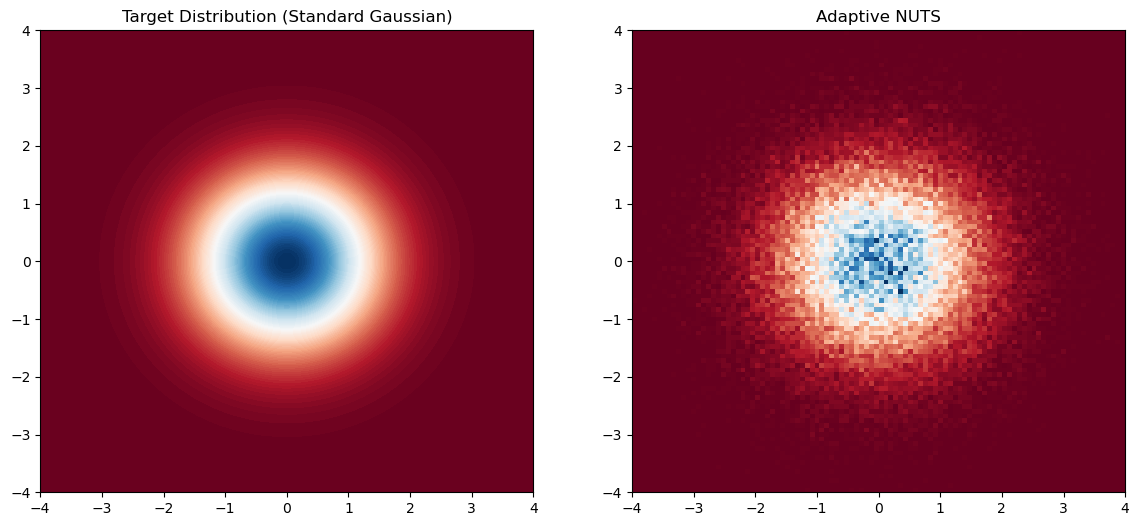

In [24]:
# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-4, 4, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Standard Gaussian)')

#burn_in = int(0.2 * num_samples)  # 20% burn-in
burn_in = 0
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
plt.title('Adaptive NUTS')
plt.show()

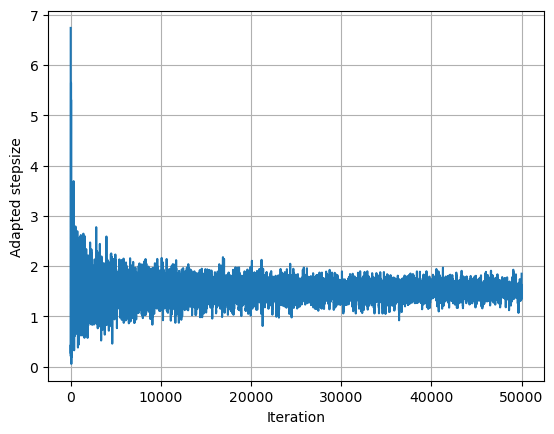

In [25]:
plt.plot(eps_list)
plt.xlabel('Iteration')
plt.ylabel('Adapted stepsize')
plt.grid()
plt.show()

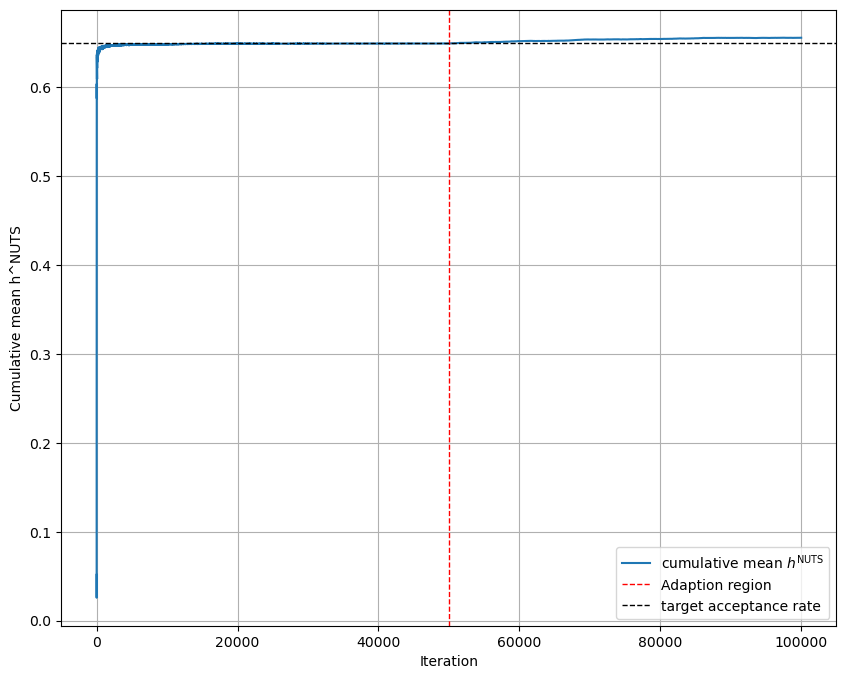

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(h_NUTS_history, label='cumulative mean $h^{\\mathrm{NUTS}}$')
plt.axvline(x=num_samples_adapt, color='r', linestyle='--', linewidth=1, label='Adaption region')
plt.axhline(y=target_accept_rate, color='k', linestyle='--', linewidth=1, label='target acceptance rate')
plt.xlabel('Iteration')
plt.ylabel('Cumulative mean h^NUTS')
plt.legend()
plt.grid()
plt.show()

In [27]:
theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 10 - theta[1]**2 / 10 - 2*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 5 + 8 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 5 - 4 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history = adaptive_NUTS(theta0, num_samples, num_samples_adapt, target_accept_rate,
                        example_log_prob, example_grad_log_prob, M)  # approx 0.5 min, superfast since allowing adaptation (larger stepsize allowed)

# A different starting point for testing the mixing ability of two different chains
theta0 = np.array([1.0, 2.0])
samples2, eps_list2, H_NUTS_history2, n_alpha_history2, h_NUTS_history2 = adaptive_NUTS(theta0, num_samples, num_samples_adapt, target_accept_rate,
                        example_log_prob, example_grad_log_prob, M)  # approx 0.5 min, superfast since allowing adaptation (larger stepsize allowed)

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\691904770.py:14: RuntimeWarning: overflow encountered in scalar multiply
  partial_x = -theta[0] / 5 + 8 * theta[0] * (theta[1] - theta[0]**2)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1494134929.py:17: RuntimeWarning: invalid value encountered in matmul
  kinetic_energy = 0.5 * r.T @ M_inv @ r
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\691904770.py:10: RuntimeWarning: overflow encountered in scalar power
  return -theta[0]**2 / 10 - theta[1]**2 / 10 - 2*(theta[1]-theta[0]**2)**2
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\278018827.py:69: RuntimeWarning: overflow encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\278018827.py:69: RuntimeWarning: invalid value encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta

There are total 18108 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.819.


C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1620989917.py:24: RuntimeWarning: divide by zero encountered in scalar power
  while (accept_prob ** a) > (2 ** (-a)):


There are total 18024 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.820.


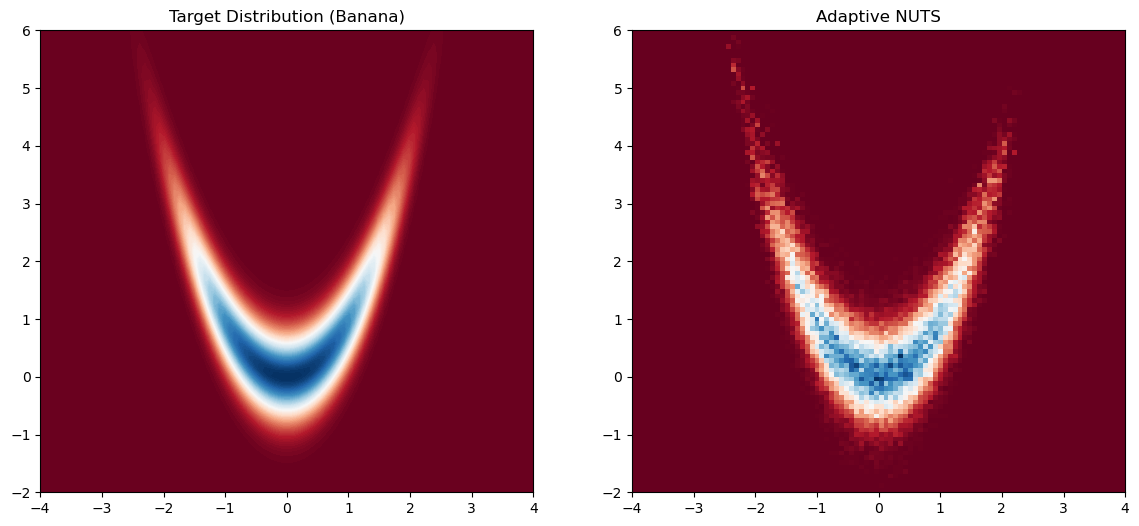

In [28]:
# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 10 - y**2 / 10 - 2 * (y - x**2)**2

# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
Z_bb = np.exp(log_banana(X_bb, Y_bb))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution (Banana)')

burn_in = int(0.2 * num_samples)  # 20% burn-in
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.subplot(1, 2, 2)
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-2, 6]], cmap='RdBu', density=True)
plt.title('Adaptive NUTS')
plt.show()

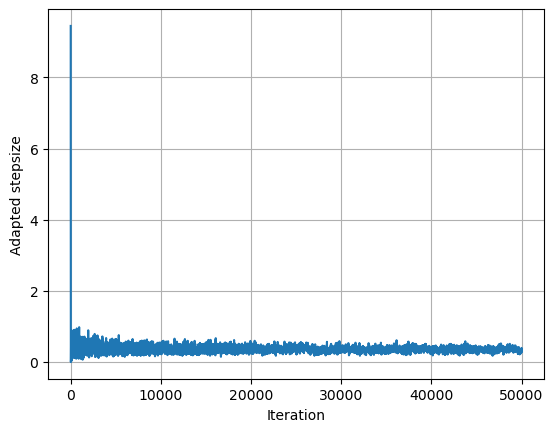

In [29]:
plt.plot(eps_list)
plt.xlabel('Iteration')
plt.ylabel('Adapted stepsize')
plt.grid()
plt.show()

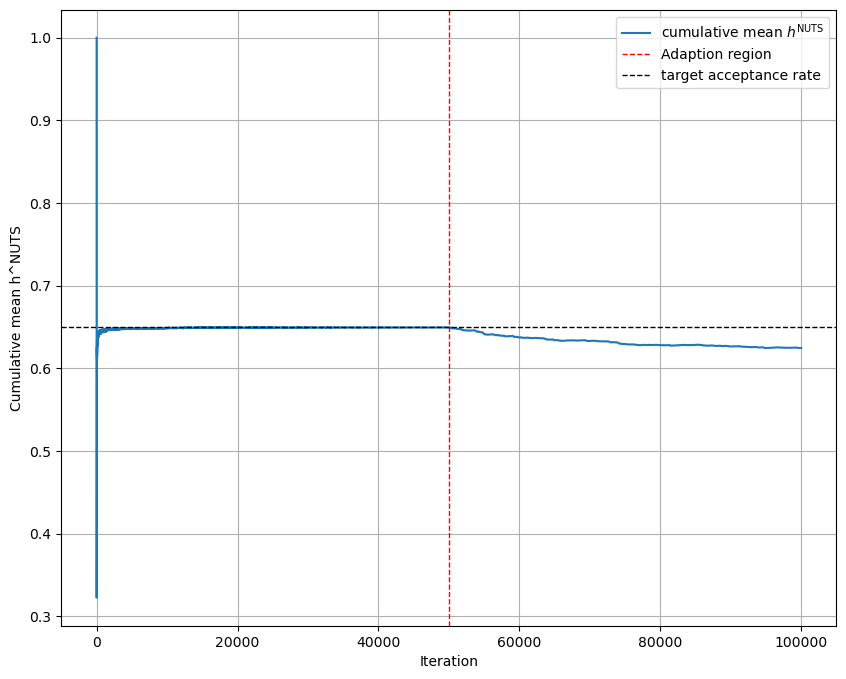

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(h_NUTS_history, label='cumulative mean $h^{\\mathrm{NUTS}}$')
plt.axvline(x=num_samples_adapt, color='r', linestyle='--', linewidth=1, label='Adaption region')
plt.axhline(y=target_accept_rate, color='k', linestyle='--', linewidth=1, label='target acceptance rate')
plt.xlabel('Iteration')
plt.ylabel('Cumulative mean h^NUTS')
plt.legend()
plt.grid()
plt.show()

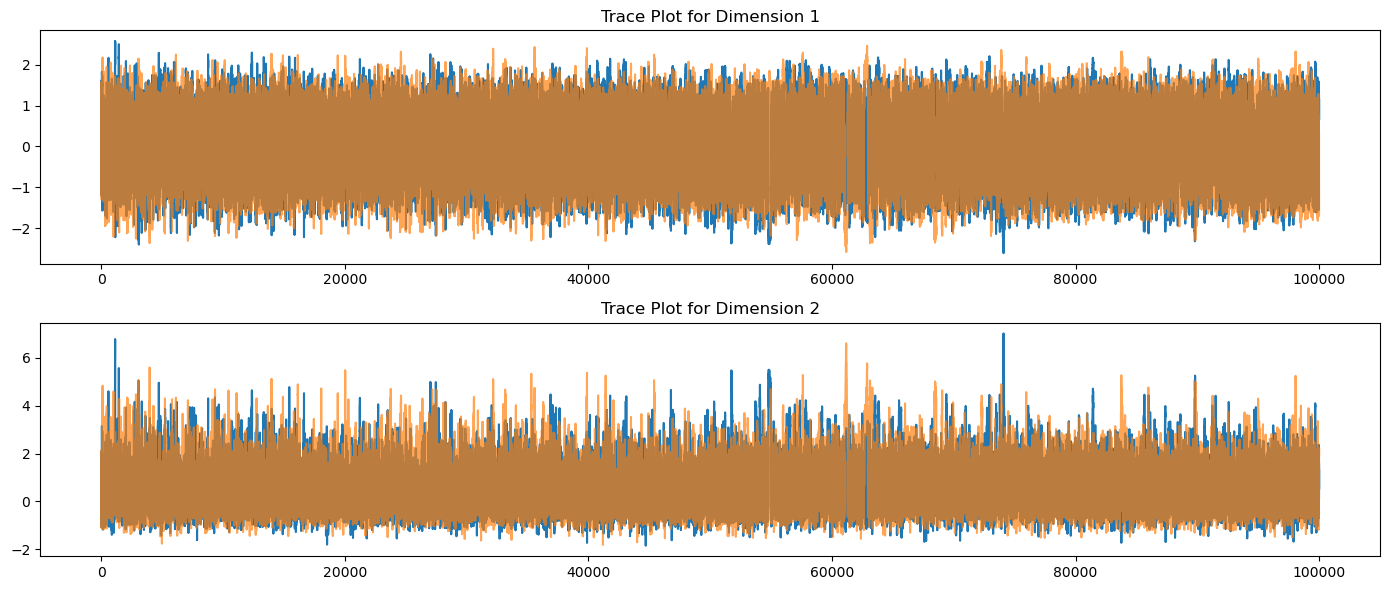

In [31]:
# Trace plots for the two dimensions
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples2[:, 0], alpha=0.7, label='Chain 2')
plt.title('Trace Plot for Dimension 1')

plt.subplot(2, 1, 2)
plt.plot(samples[:, 1], label='Chain 1')
plt.plot(samples2[:, 1], alpha=0.7, label='Chain 2')
plt.title('Trace Plot for Dimension 2')
plt.tight_layout()
plt.show()

Mix well for two different chains with different starting positions.

# Real data analysis

We now carry a real data analysis on our NUTS. The dataset chosen is from MATH70073 Coursework which is related to the national police shootings in the US from 2015 to 2024. Source: https://github.com/washingtonpost/data-police-shootings, with version 2 (v2).

For race, it uses abbreviations that

- W: White

- B: Black

- A: Asian heritage

- N: Native American

- H: Hispanic

- O: Other

- --: Unknown

In [32]:
import pandas as pd

file_path = 'c:/Users/Peiyi/Desktop/NUTS simulation/data/fatal-police-shootings-data.csv'

df = pd.read_csv(file_path)  # we remove the index column (which is the first column by pandas default)
# We further remove unnecessary columns/features that are not interested in our analysis
columns_to_drop = ['id', 'city', 'county', 'latitude', 'longitude', 
                   'location_precision', 'name', 'race_source', 'agency_ids']
df = df.drop(columns=columns_to_drop)

# Replace date by corresponding year only
df['date'] = pd.to_datetime(df['date']).dt.year

df.head()

date threat_type flee_status armed_with state   age gender race  \
0  2015       point         not        gun    WA  53.0   male    A   
1  2015       point         not        gun    OR  47.0   male    W   
2  2015        move         not    unarmed    KS  23.0   male    H   
3  2015       point         not    replica    CA  32.0   male    W   
4  2015       point         not      other    CO  39.0   male    H   

   was_mental_illness_related  body_camera  
0                        True        False  
1                       False        False  
2                       False        False  
3                        True        False  
4                       False        False

Again we consider the police shootings over 51 US states in the period 2015-2024, under the assumption that **the state population remain approximately constant over years**. 

We may first consider the raw count of number of police shootings in each state during 2015-2024 and report them in a bar chart.

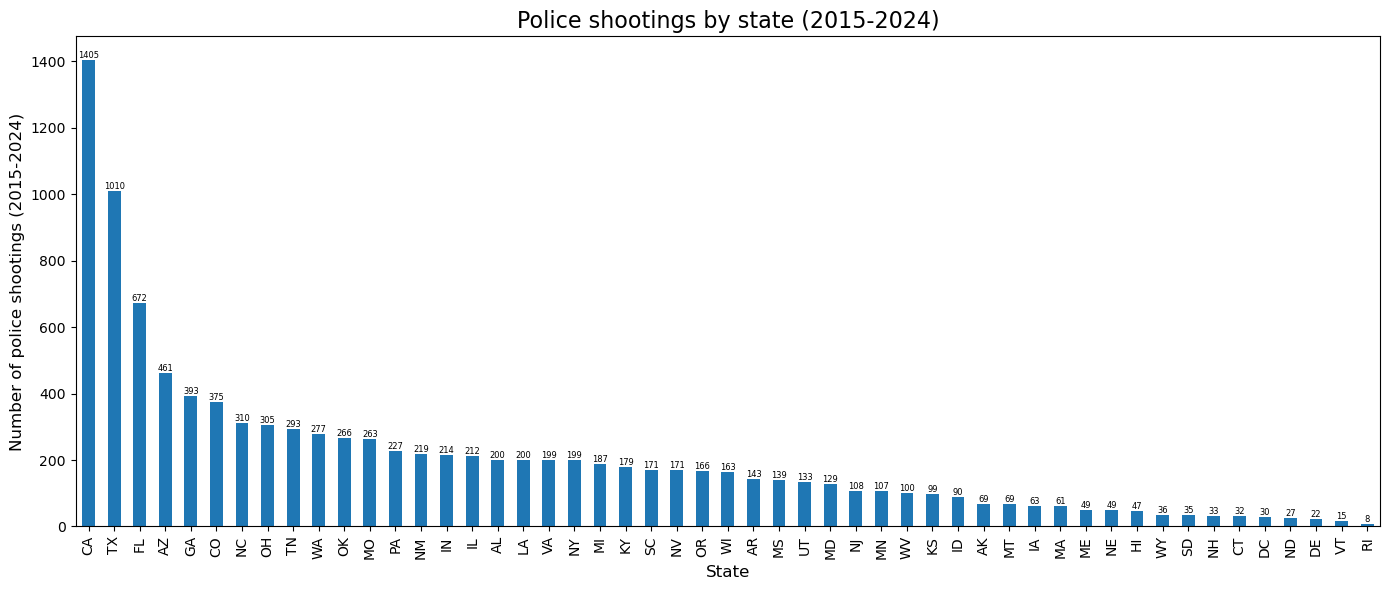

In [33]:
# # number of police shootings in each state during 2015-2024, in descending order
state_counts = df['state'].value_counts()

plt.figure(figsize=(14, 6))
ax = state_counts.plot(kind='bar')
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of police shootings (2015-2024)', fontsize=12)
plt.title('Police shootings by state (2015-2024)', fontsize=16)

# annotate counts above bars
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(int(y), (x, y), ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

In [34]:
from itertools import product

# A brief check on the (state, date) keys in the dataset
# Check the number of unique states (51) and unique years (10)
print('Unique states:', df['state'].nunique())
print('Unique years:',  df['date'].nunique())

# Check whether we have NaN state and year
print("NaN in state:", df['state'].isna().sum())
print("NaN in date: ", df['date'].isna().sum())

# See which (state, date) combos are present vs all possible combos
states = sorted(df['state'].dropna().unique())  # sort in alphabetical order
dates  = sorted(df['date'].dropna().unique())  # sort in ascending order
present = set(df.groupby(['state','date']).size().index)  # set of (state, date) combos present in the data
all_combos = set(product(states, dates))  # set of all possible (state, date) combos, which should be of length 51*10=510
missing = sorted(list(all_combos - present))  # list of missing (state, date) combos, in sorted order
print('Number of expected combos:', len(states)*len(dates))
print('Number missing:', len(missing))
print('Example missing combos:', missing)

Unique states: 51
Unique years: 10
NaN in state: 0
NaN in date:  0
Number of expected combos: 510
Number missing: 8
Example missing combos: [('DE', 2018), ('ND', 2019), ('NE', 2017), ('RI', 2015), ('RI', 2019), ('RI', 2020), ('RI', 2024), ('VT', 2020)]




The raw count of number of police shootings is not a fair statistic to compare and rank US states, this is because larger states like California and Texas are more populated than states like Rhode Island, and such huge population base leads to higher counts. To accurately describe the police shootings by US state, we should use incidence rates instead, which are computed as:
$$
\frac{\text{total number of shootings over a period}}{\text{total population over a period}} \times \text{population size interested}
$$

The incidence rate computed here would be the incidence rate for each state per 1 million people.

We now use necessary information in <code>df</code> to compute the incidence rate for each state and merge them into a new dataframe <code>df_new</code> for our later analysis. This is constructed in 3 steps:

1. First construct <code>df_new</code> with columns: 'state', 'date' and 'shooting count'. This should have length 510, for total 51 states and 10 years. The shooting count would record the number of police shootings per state per year.

2. Add a new column named as 'state population' that records the population over each state for corresponding year. The yearly state population information can be found in https://wonder.cdc.gov/wonder/help/single-race.html, but missing 2024 data. Here we apply Excel quick analysis/trendline for fitting the data of 2024 by using 2015-2023 populations (based on OLS principle), up to the nearest integer.

3. Add a new column for the incidence police shooting rate per year per 100k people.

In [35]:
# Step 1:
# Merge the data to get counts of shootings per (state, date)
# but we should assign 0 counts to the missing (state, date) combos
cumbo_counts = df.groupby(['state', 'date']).size().reset_index(name='shooting count')
all_combos_df = pd.DataFrame(list(all_combos), columns=['state', 'date'])
df_new = pd.merge(all_combos_df, cumbo_counts, on=['state', 'date'], how='left').fillna(0)
df_new['shooting count'] = df_new['shooting count'].astype(int)  # convert count to integer type

# Sort df_new by state and date
df_new = df_new.sort_values(['state', 'date'], ignore_index=True)

df_new.head()

state  date  shooting count
0    AK  2015               4
1    AK  2016               8
2    AK  2017               8
3    AK  2018               7
4    AK  2019               7

In [36]:
# Step 2:
file_path = 'C:/Users/Peiyi/Desktop/NUTS simulation/data/Single-Race Population Estimates by State/merged 2015-2024.xlsx'

state_pop_df = pd.read_excel(file_path)

columns_to_drop = ['States', 'States Code']
state_pop_df = state_pop_df.drop(columns=columns_to_drop)

state_pop_df.head()

# Merge state_pop_df with df_new by state
df_new = pd.merge(df_new, state_pop_df, left_on='state', right_on='state', how='left')
df_new

state  date  shooting count  2015 Population  2016 Population  \
0      AK  2015               4           737709           741894   
1      AK  2016               8           737709           741894   
2      AK  2017               8           737709           741894   
3      AK  2018               7           737709           741894   
4      AK  2019               7           737709           741894   
..    ...   ...             ...              ...              ...   
505    WY  2020               1           586555           585501   
506    WY  2021               3           586555           585501   
507    WY  2022              10           586555           585501   
508    WY  2023               1           586555           585501   
509    WY  2024               7           586555           585501   

     2017 Population  2018 Population  2019 Population  2020 Population  \
0             740983           736624           733603           731158   
1             740983           736624           733603           731158   
2             740983           736624           733603           731158   
3             740983           736624           733603           731158   
4             740983           736624           733603           731158   
..               ...              ...              ...              ...   
505           579994           579054           580116           582328   
506           579994           579054           580116           582328   
507           579994           579054           580116           582328   
508           579994           579054           580116           582328   
509           579994           579054           580116           582328   

     2021 Population  2022 Population  2023 Population  2024 Population  
0             734923           733276           733406           730899  
1             734923           733276           733406           730899  
2             734923           733276           733406           730899  
3             734923           733276           733406           730899  
4             734923           733276           733406           730899  
..               ...              ...              ...              ...  
505           579548           581629           584057           580485  
506           579548           581629           584057           580485  
507           579548           581629           584057           580485  
508           579548           581629           584057           580485  
509           579548           581629           584057           580485  

[510 rows x 13 columns]

In [37]:
# Step 3:
# Vectorised approach 
years = df_new['date'].astype(str)
df_new['incidence rate per 1e5 people'] = (
    df_new['shooting count'] / 
    df_new[[f'{year} Population' for year in df_new['date']]].values[range(len(df_new)), range(len(df_new))]
) * 100000

df_new.head()

state  date  shooting count  2015 Population  2016 Population  \
0    AK  2015               4           737709           741894   
1    AK  2016               8           737709           741894   
2    AK  2017               8           737709           741894   
3    AK  2018               7           737709           741894   
4    AK  2019               7           737709           741894   

   2017 Population  2018 Population  2019 Population  2020 Population  \
0           740983           736624           733603           731158   
1           740983           736624           733603           731158   
2           740983           736624           733603           731158   
3           740983           736624           733603           731158   
4           740983           736624           733603           731158   

   2021 Population  2022 Population  2023 Population  2024 Population  \
0           734923           733276           733406           730899   
1           734923           733276           733406           730899   
2           734923           733276           733406           730899   
3           734923           733276           733406           730899   
4           734923           733276           733406           730899   

   incidence rate per 1e5 people  
0                       0.542219  
1                       1.078321  
2                       1.079647  
3                       0.950281  
4                       0.954195

We may average each state's incidence rate and plot the bar chart again to compare the incidence rate of police shootings across the states. 

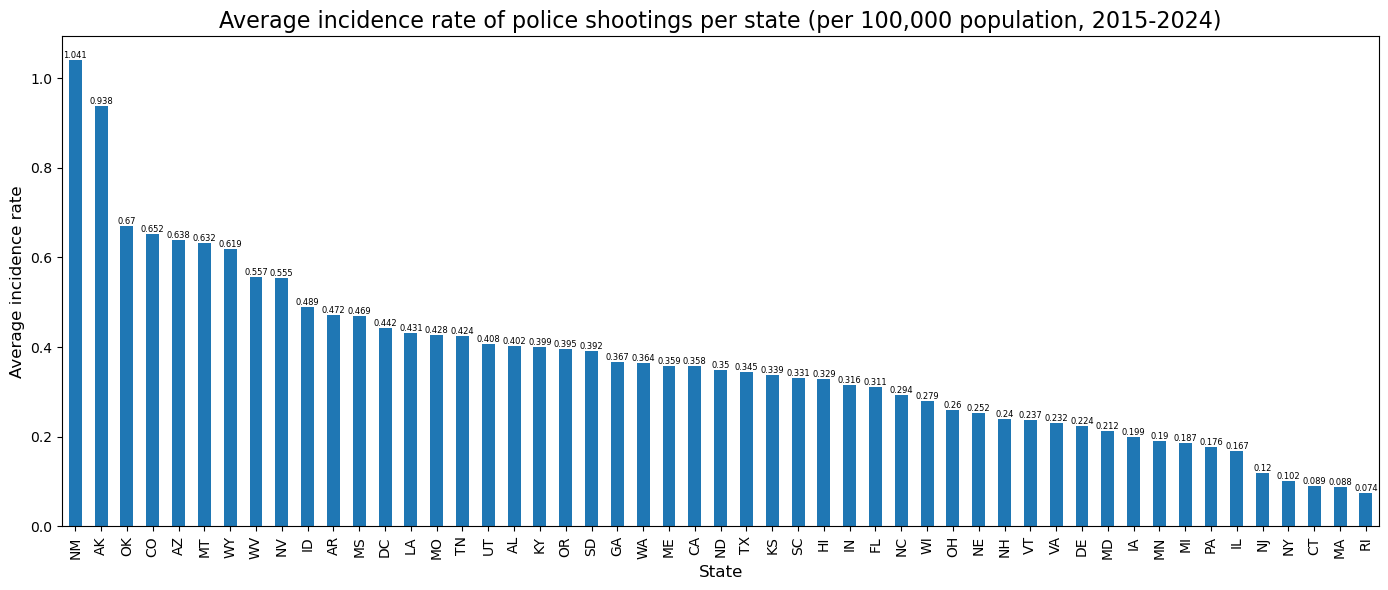

In [38]:
# Calculate average incidence rate per state
state_avg_incidence = df_new.groupby('state')['incidence rate per 1e5 people'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
ax = state_avg_incidence.plot(kind='bar')

# Customize the chart
plt.xlabel('State', fontsize=12)
plt.ylabel('Average incidence rate', fontsize=12)
plt.title('Average incidence rate of police shootings per state (per 100,000 population, 2015-2024)', fontsize=16)

# annotate counts above bars
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(round(y, 3), (x, y), ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

We specify the Bayesian Poisson random effects model to estimate incidence rates (per 100,000 people) of police shootings for each US state, from count data stratified by state and year.
$$
\begin{aligned}
Y_{t,s} &\sim \mathrm{Poi}(\lambda_{t, s})\\
\log \lambda_{t, s} &= \log (P_{t, s}/10^5) + \log \theta_{t, s}\\
\log \theta_{t, s} &= \alpha + \beta_s + \gamma_t\\
\alpha &\sim \mathcal{N}(0, 10^2)\\
\beta_s &\sim \mathcal{N}(0, \sigma_\beta^2)\\
\gamma_t &\sim \mathcal{N}(0, \sigma_\gamma^2)\\
\sigma_\beta &\sim \text{Half-Cauchy}(0,1)\\
\sigma_\gamma &\sim \text{Half-Cauchy}(0,1)
\end{aligned}
$$

where:

1. $Y_{t,s}$: observation (number of police shootings) at year $t$ for state $s$, where we have 10 years (2015-2024, so $t=1,\cdots, 10$) and 50 states and the D.C. as features (so $s=1,\cdots,51$), so in total we would have 510 observations.

2. $\lambda_{t, s}$: expected police shootings counts at year $t$ for state $s$, which is done as a product between the incidence rate (per 100,000 people) of state $s$ at year $t$ (denoted as $\theta_{t, s}$) and the state population $P_{t, s}$ of state $s$ at year $t$, divided by $10^5$ corresponding to the population size interested for computing the incidence rate (the resulting $\log (P_{t, s}/10^5)$ can be seen as an offset term).

3. $\alpha$: baseline log-incidence rate parameter (fixed effect). We assume it is in a normal distribution symmetric at 0 with variance 100 as a very weakly informative and broad prior.

4. $\beta_s$: state-specific random effect (subscript $s$ means for state $s$). We total have 51 different $\beta_s$ specific to each state, and $\beta_s$ are assumed to be independent with each other for different states $s$.

5. $\sigma_\beta$: variance parameter across states, we need this to be positive.

6. $\gamma_t$: time-specific random effect (subscript $t$ means for year $t$). We total have 10 different $\gamma_t$ specific to each year, and $\gamma_t$ are assumed to be independent with each other for different time $t$.

7. $\sigma_\gamma$: variance parameter across time, we need this to be positive.

In order to improve the efficiency and avoid funnel geometry, we apply the non-centered parameterisation, that is, we write:

- $\beta_s \sim \mathcal{N}(0, \sigma_\beta^2) \iff \beta_s = \sigma_\beta z_\beta$, with $z_\beta \sim \mathcal{N}(0,1)$ being as some standard Gaussian random effects.

- $\gamma_t \sim \mathcal{N}(0, \sigma_\gamma^2) \iff \gamma_t = \sigma_\gamma z_\gamma$, with $z_\gamma \sim \mathcal{N}(0,1)$ being as some standard Gaussian random effects.

Also, if $X \sim \text{Half-Cauchy}(0,1)$, its density function is simply
$$
f(x) = \frac{2}{\pi}\frac{1}{1 + x^2} = 2 \times \text{Cauchy}(x; 0, 1)
$$
as the Half-Cauchy distribution is the absolute value of a Cauchy distribution, together with symmetry.

In order to avoid overflow, we may set our position vector as
$$
\theta = (\alpha, \log \sigma_\beta, \log \sigma_\gamma, z_\beta, z_\gamma), \quad z_\beta \in \mathbb{R}^{51}, z_\gamma \in \mathbb{R}^{10}
$$
and this is represented as the input argument <code>params</code> in the later code.

In [39]:
from torch.distributions import Normal, Cauchy

class PoissonRandomEffectsModel:
    def __init__(self, Y, P, state_indices, year_indices, n_states=51, n_years=10, device='cpu'):
        """
        Initialise the model with data.
        
        Args:
            Y (np.ndarray): Array of observed counts, of shape (n_obs, ), where n_obs = n_states * n_years.
            P (np.ndarray): Array of populations, of shape (n_obs, ).
            state_indices (np.ndarray): Array of state indices (0 to n_states-1).
            year_indices (np.ndarray): Array of year indices (0 to n_years-1).
            n_states: Number of states. Default is 51 for 51 states in the US.
            n_years: Number of years. Default is 10 for years 2015-2024.
            device: the device used. Default is cpu.
        """
        
        # Store as torch tensors (single precision), shooting counts, population and indices must be in integer form
        self.device = device
        self.Y = torch.as_tensor(Y, dtype=torch.int64, device=self.device)
        self.P = torch.as_tensor(P, dtype=torch.int64, device=self.device)
        self.state_indices = torch.as_tensor(state_indices, dtype=torch.int64, device=self.device)
        self.year_indices = torch.as_tensor(year_indices, dtype=torch.int64, device=self.device)
        self.n_states = n_states
        self.n_years = n_years
        self.n_obs = self.Y.numel()  # total number of observations, .numel() is tensor-specific

        # Parameter dimensions
        self.dim_alpha = 1
        self.dim_sigma_beta = 1
        self.dim_sigma_gamma = 1
        self.dim_z_beta = n_states
        self.dim_z_gamma = n_years
        
        self.total_dim = self.dim_alpha + self.dim_sigma_beta + self.dim_sigma_gamma + self.dim_z_beta + self.dim_z_gamma

    def unpack_parameters(self, params):
        """
        Unpack the parameter vector/position into individual components.
        
        Args:
            params (np.ndarray): Parameter vector of shape (total_dim, ), containing (alpha, log_sigma_beta, 
            log_sigma_gamma, z_beta, z_gamma, beta, gamma).
        Returns:
            The parameters (alpha, sigma_beta, sigma_gamma, beta_s, gamma_t) in tensor form.
        """

        params = torch.as_tensor(params, dtype=torch.float64, device=self.device)  # convert our params into tensors
        idx = 0  # initialise the index

        # Fixed effects
        alpha = params[idx]
        idx += 1

        # Standard deviations (positive parameters - we will use log transform)
        log_sigma_beta = params[idx]
        sigma_beta = torch.exp(log_sigma_beta)
        idx += 1

        log_sigma_gamma = params[idx]
        sigma_gamma = torch.exp(log_sigma_gamma)
        idx += 1

        # Random effects (non-centered parameterisation)
        z_beta = params[idx : idx + self.n_states]
        idx += self.n_states
        z_gamma = params[idx : idx + self.n_years]
        idx += self.n_years

        return alpha, sigma_beta, sigma_gamma, z_beta, z_gamma

    def log_joint_density(self, params):
        """
        Compute the log joint (unnormalised posterior) using torch ops.
        Args:
            params: numpy array or torch tensor. If numpy, convert to torch internally.
        Returns: 
            The value of log joint density (unnormalised log posterior) with input parameters, in terms of tensor on device.
        """
        # Convert input to torch tensor if needed
        if not isinstance(params, torch.Tensor):
            params = torch.as_tensor(params, dtype=torch.float64, device=self.device)
        else:
            params = params.to(dtype=torch.float64, device=self.device)

        # Unpack parameters in terms of torch tensors
        alpha, sigma_beta, sigma_gamma, z_beta, z_gamma = self.unpack_parameters(params)

        # Apply sum-to-zero constraints to ensure identifiability and interpretability
        beta = sigma_beta * (z_beta - torch.mean(z_beta))
        gamma = sigma_gamma * (z_gamma - torch.mean(z_gamma))

        # Log likelihood (Poission, unnormalised form)
        log_offset = torch.log(self.P / 1e5)
        log_lambda = log_offset + alpha + beta[self.state_indices] + gamma[self.year_indices]
        log_likelihood = torch.sum(self.Y * log_lambda - torch.exp(log_lambda))  # discarding the factorial in the denominator

        # Priors
        # alpha ~ N(0, 10^2)
        prior_alpha = Normal(0, 10)
        log_prior_alpha = prior_alpha.log_prob(alpha)

        # z_beta, z_gamma ~ N(0,1) - standard normal for non-centered parameterisation
        prior_standard_normal = Normal(0, 1)
        # Summation for every component, 
        # this is because independence: joint prior = product -> log joint prior = sum
        log_prior_z_beta = prior_standard_normal.log_prob(z_beta).sum()
        log_prior_z_gamma = prior_standard_normal.log_prob(z_gamma).sum()

        # sigma_beta, sigma_gamma ~ Half-Cauchy(0,1)
        # log p(sigma) = log(2/pi) - log(1 + sigma^2)
        prior_standard_cauchy = Cauchy(0, 1)
        log_prior_sigma_beta = prior_standard_cauchy.log_prob(sigma_beta) + torch.log(torch.tensor(2, dtype=torch.float64, device=self.device))
        log_prior_sigma_gamma = prior_standard_cauchy.log_prob(sigma_gamma) + torch.log(torch.tensor(2, dtype=torch.float64, device=self.device))

        # Unnormalised posterior = prior * likelihood -> log unnormalised posterior = log prior + log likelhood
        # We can take unnormalised form for all of them and it does not affect the result
        log_prior = log_prior_alpha + log_prior_z_beta + log_prior_z_gamma + log_prior_sigma_beta + log_prior_sigma_gamma
        log_posterior = log_likelihood + log_prior  # unnormalised log posterior in scalar torch tensor form

        return log_posterior


    def grad_log_joint_density(self, params):
        """
        Compute gradient of log_joint_density w.r.t. params.
        """

        # Convert to torch tensor on correct device and make requires_grad, different from params for differentiation
        if not isinstance(params, torch.Tensor):
            params_diff = torch.tensor(params, dtype=torch.float64, device=self.device).clone().detach().requires_grad_(True)
        else:
            params_diff = params.to(dtype=torch.float64, device=self.device).clone().detach().requires_grad_(True)

        # Compute the unnormalised log posterior
        log_posterior = self.log_joint_density(params_diff)

        # Force zero gradients at the beginning (if it already has a preset gradient)
        if params_diff.grad is not None:
            params_diff.grad.zero_()

        # Backward to compute grads
        log_posterior.backward()

        # Extract gradient to numpy on CPU
        grad_log_posterior = params_diff.grad.detach().cpu().numpy().astype(np.float64)

        return grad_log_posterior

In [40]:
# Prepare the data needed for construct our Poisson random effect model

# Create state and year indices
states = sorted(df_new['state'].unique())
years = sorted(df_new['date'].unique())

# Use dictionary to store state/year and their corresponding indices    
state_to_idx = {state: i for i, state in enumerate(states)}
year_to_idx = {year: i for i, year in enumerate(years)}
    
n_states = len(states)
n_years = len(years)
    
# Extract data
Y = df_new['shooting count'].values  # (510, )
state_indices = np.array([state_to_idx[state] for state in df_new['state']])
year_indices = np.array([year_to_idx[year] for year in df_new['date']])
    
# Get population for each state-year combination
P = np.zeros(len(df_new))  # initialise
for i, row in df_new.iterrows():
    year = row['date']
    pop_col = f'{year} Population'
    P[i] = row[pop_col]

### Naive NUTS implementation on this example

Unlike the previous toy examples, here we must qualitatively find an appropriate stepsize $\epsilon$ (and that can be different from the default 0.1). If the stepsize is too big, the leapfrog jump would be big and we barely cannot accept a sample - the tree would stop generate due to large jumps meeting the stopping criteria too early. Meanwhile, a too small stepsize would cause very small jumps to lead very inefficient sampling. We may try some stepsize value and see their jumps.

In [41]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)

# Initial position-momentum pair
theta0 = np.zeros(model.total_dim)
r0 = np.random.multivariate_normal(mean=np.zeros(model.total_dim), cov=np.eye(model.total_dim))

for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]:
    theta1, r1 = leapfrog(theta0.copy(), r0.copy(), v=1, grad_log_joint_density=model.grad_log_joint_density, M=np.eye(model.total_dim), eps=eps)
    print(f'The magitude of jump with stepsize {eps}:', np.linalg.norm(theta1 - theta0))

The magitude of jump with stepsize 0.001: 0.01340108482759053
The magitude of jump with stepsize 0.005: 0.2838619069134891
The magitude of jump with stepsize 0.01: 1.1343225755178672
The magitude of jump with stepsize 0.05: 28.442587220958735
The magitude of jump with stepsize 0.1: 113.83923728675462
The magitude of jump with stepsize 0.5: 2847.4646744777856
The magitude of jump with stepsize 1.0: 11390.62703042867


Though the position vector is of a very high dimension to cause a huge difference in maginitude, we may still wish to pick $\epsilon=0.01$.

In [42]:
# Initialise model
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)
num_samples = 100

# Initial parameter values
theta0 = np.zeros(model.total_dim)
    
# Mass matrix (identity for now, could be adapted)
M = np.eye(model.total_dim)
    
# Run NUTS - choice of stepsize here would be really important!!!
samples, C, avg_accept_prob = naive_NUTS(
    theta0, num_samples, 
    model.log_joint_density, 
    model.grad_log_joint_density, 
    M, eps=0.01
)

# Samples are params following the form as unpack_parameters: (alpha, log_sigma_beta, log_sigma_gamma, z_beta, z_gamma)

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\277881251.py:58: RuntimeWarning: overflow encountered in exp
  accept_prob += min(1, np.exp(H0 - H_curr))  # summation (without averaging)


There are total 4 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 0.960.


In [43]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)

# For a different starting position
alpha0 = 1
log_sigma_beta0 = 0.5
log_sigma_gamma0 = 0.5
z_beta0 = 0.4 * np.ones(51)
z_gamma0 = 0.3 * np.ones(10)

theta0 = np.concatenate(([alpha0, log_sigma_beta0, log_sigma_gamma0], z_beta0, z_gamma0))
r0 = np.random.multivariate_normal(mean=np.zeros(model.total_dim), cov=np.eye(model.total_dim))

for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]:
    theta1, r1 = leapfrog(theta0.copy(), r0.copy(), v=1, grad_log_joint_density=model.grad_log_joint_density, M=np.eye(model.total_dim), eps=eps)
    print(f'The magitude of jump with stepsize {eps}:', np.linalg.norm(theta1 - theta0))

The magitude of jump with stepsize 0.001: 0.04026726453795652
The magitude of jump with stepsize 0.005: 1.0159138916077566
The magitude of jump with stepsize 0.01: 4.073878608213824
The magitude of jump with stepsize 0.05: 102.07342406230708
The magitude of jump with stepsize 0.1: 408.4123969172742
The magitude of jump with stepsize 0.5: 10212.705760080495
The magitude of jump with stepsize 1.0: 40852.026411810395


In [44]:
# Run NUTS - choice of stepsize here would be really important!!!
samples1, C1, avg_accept_prob1 = naive_NUTS(
    theta0, num_samples, 
    model.log_joint_density, 
    model.grad_log_joint_density, 
    M, eps=0.005
)

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\277881251.py:58: RuntimeWarning: overflow encountered in exp
  accept_prob += min(1, np.exp(H0 - H_curr))  # summation (without averaging)


There are total 2 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 0.980.


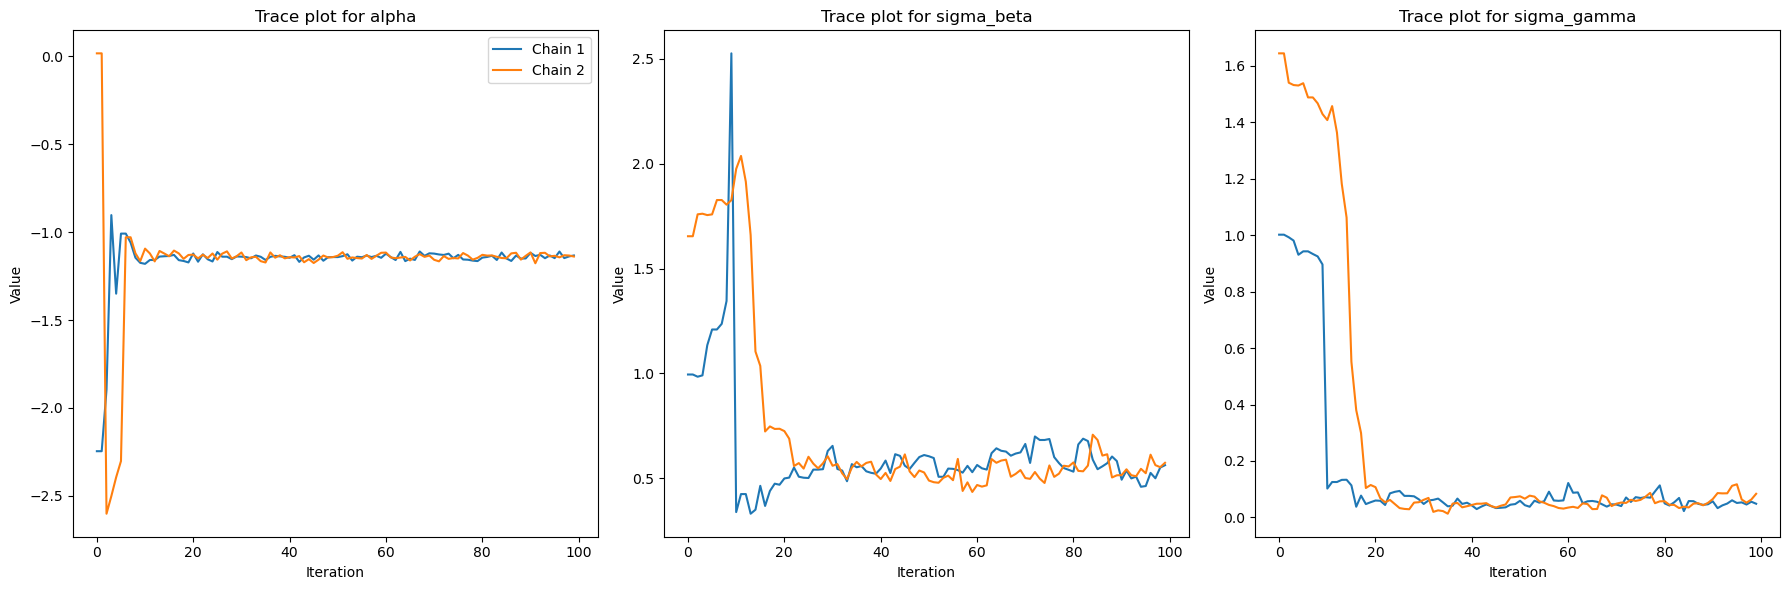

In [45]:
# Traceplots for alpha, sigma_beta and sigma_gamma, for both chains
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples1[:, 0], label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for alpha')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(np.exp(samples[:, 1]), label='Chain 1')
plt.plot(np.exp(samples1[:, 1]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_beta')

plt.subplot(1, 3, 3)
plt.plot(np.exp(samples[:, 2]), label='Chain 1')
plt.plot(np.exp(samples1[:, 2]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_gamma')

plt.tight_layout()
plt.show()

### Efficient NUTS implementation on this example

In [46]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)

num_samples = 100

# Initial parameter values
theta0 = np.zeros(model.total_dim)
    
# Mass matrix (identity for now, could be adapted)
M = np.eye(model.total_dim)
    
# Run NUTS - choice of stepsize here would be really important!!!
samples = eff_NUTS(
    theta0, num_samples, 
    model.log_joint_density, 
    model.grad_log_joint_density, 
    M, eps=0.01
)

# For a different starting position
alpha0 = 1
log_sigma_beta0 = 0.5
log_sigma_gamma0 = 0.5
z_beta0 = 0.4 * np.ones(51)
z_gamma0 = 0.3 * np.ones(10)

theta0 = np.concatenate(([alpha0, log_sigma_beta0, log_sigma_gamma0], z_beta0, z_gamma0))

# Run NUTS - choice of stepsize here would be really important!!!
samples1 = eff_NUTS(
    theta0, num_samples, 
    model.log_joint_density, 
    model.grad_log_joint_density, 
    M, eps=0.005
)

There are total 0 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 1.000.
There are total 0 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 1.000.


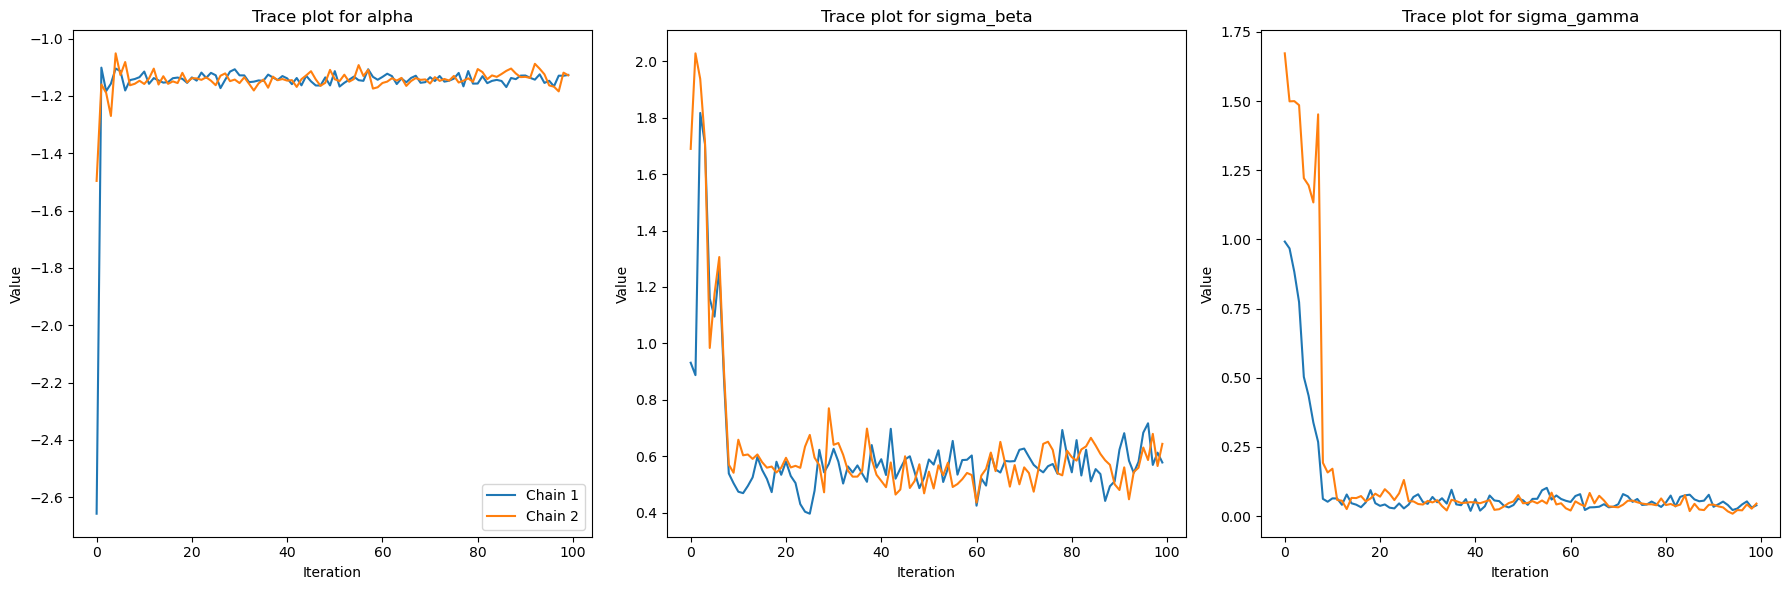

In [47]:
# Traceplots for alpha, sigma_beta and sigma_gamma, for both chains
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples1[:, 0], label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for alpha')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(np.exp(samples[:, 1]), label='Chain 1')
plt.plot(np.exp(samples1[:, 1]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_beta')

plt.subplot(1, 3, 3)
plt.plot(np.exp(samples[:, 2]), label='Chain 1')
plt.plot(np.exp(samples1[:, 2]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_gamma')

plt.tight_layout()
plt.show()

### Adaptive NUTS implementation on this example

In [ ]:
model = PoissonRandomEffectsModel(Y, P, state_indices, year_indices, n_states, n_years)

# Both num_samples and num_samples_adapt would affect the speed of sampling
# more num_samples_adapt would possibly reduce the stepsize to slow down the convergence and increase the cost...
# Pretty slow: more than 2h on local laptop... (I don't have the result tbh...)
num_samples = 100
num_samples_adapt = 20
target_accept_rate = 0.65

# Initial parameter values
theta0 = np.zeros(model.total_dim)
    
# Mass matrix (identity for now, could be adapted)
M = np.eye(model.total_dim)

# Run adaptive NUTS
samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history = adaptive_NUTS(
    theta0, num_samples, num_samples_adapt, target_accept_rate,
    model.log_joint_density, 
    model.grad_log_joint_density, 
    M
)

# For a different starting position
alpha0 = 1
log_sigma_beta0 = 0.5
log_sigma_gamma0 = 0.5
z_beta0 = 0.4 * np.ones(51)
z_gamma0 = 0.3 * np.ones(10)

theta0 = np.concatenate(([alpha0, log_sigma_beta0, log_sigma_gamma0], z_beta0, z_gamma0))

# Run NUTS - choice of stepsize here would be really important!!!
samples1, eps_list1, H_NUTS_history1, n_alpha_history1, h_NUTS_history1 = adaptive_NUTS(
    theta0, num_samples, num_samples_adapt, target_accept_rate,
    model.log_joint_density, 
    model.grad_log_joint_density, 
    M
)

In [ ]:
# Traceplots for alpha, sigma_beta and sigma_gamma, for both chains
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], label='Chain 1')
plt.plot(samples1[:, 0], label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for alpha')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(np.exp(samples[:, 1]), label='Chain 1')
plt.plot(np.exp(samples1[:, 1]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_beta')

plt.subplot(1, 3, 3)
plt.plot(np.exp(samples[:, 2]), label='Chain 1')
plt.plot(np.exp(samples1[:, 2]), label='Chain 2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace plot for sigma_gamma')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(eps_list)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(h_NUTS_history, label='cumulative mean $h^{\\mathrm{NUTS}}$')
plt.axvline(x=num_samples_adapt, color='r', linestyle='--', linewidth=1, label='Adaption region')
plt.axhline(y=target_accept_rate, color='k', linestyle='--', linewidth=1, label='target acceptance rate')
plt.xlabel('Iteration')
plt.ylabel('Cumulative mean h^NUTS')
plt.legend()
plt.grid()
plt.show()

# Investigation on single/small amount of build tree processes

**Case 1: banana density.**

In [277]:
def example_log_prob(theta):
    # log form of the banana density
    return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2

def example_grad_log_prob(theta):
    # Gradient of log-density
    partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
    partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)
    return np.array([partial_x, partial_y])

# banana function for testing MCMC, component form for plotting
def log_banana(x, y):
    return -x**2 / 30 - y**2 / 30 - 10 * (y - x**2)**2

In [278]:
def extract_positions(C):
    """
    Extract all possible position samples generated from the (naive) NUTS. 
    The selected position sample is chosen uniformly from all possible position samples.
    
    Arg:
        C (list): the total set of possible accepted (position, momentum) from the naive NUTS based on the previous sample.
    Return:
        pos_chain (np.ndarray): all possible states for the position chain from C (discarding the momentum chain).
    """

    pos_chain = np.vstack([pos for pos, mmt in C])

    return pos_chain

In [279]:
def collecting_positions(theta0, num_samples, log_joint_density, grad_log_joint_density, 
                         M=np.eye(theta0.shape[0]), eps=0.1, delta_max=1000):
    """
    Run naive NUTS for num_samples iterations and collect the position trajectories (the position chains produced during each build_tree step).

    Args:
        theta0 (np.ndarray): initial position vector.
        num_samples (int): Number of NUTS iterations to run (i.e. how many position chains to collect).
        log_joint_density (callable): Function to compute the log joint density.
        grad_log_joint_density (callable): Function to compute the gradient of log_joint_density.
        M (np.ndarray): The mass matrix. Default is the identity matrix with the same dimension as theta.
        eps (float): Stepsize for the leapfrog integration. Default is 0.1.
        delta_max (float): Maximum energy difference to avoid numerical issues. Default is 1000.
    Return:
        all_positions (list): List of length (num_samples, ). Each element is a 2-D numpy array with shape (T_i, D), 
        containing the sequence of positions visited during that iteration's tree construction. 
        Note that T_i depend on the stopping criteria (U-turn, energy) and may vary between iterations.
    """

    # Initialise the all_positions, as a list, storing the position chain from each iteration
    # the so-called 'position chain' refers the position samples in C for each iteration of naive NUTS
    # if we run n iterations (so total n position samples for naiveNUTS), 
    # then the i-th position sample is chosen uniformly from the i-th element in all_positions,
    # where the i-th element of all_positions contain all possible position coordinates during the i-th build tree process.
    all_positions = []

    theta = theta0  # initialise the starting position with preset value

    for _ in range(num_samples):
        # Generate one next (position, momentum) sample with the previous position theta 
        sample, C, _ = naive_NUTS(theta, 1, log_joint_density, grad_log_joint_density, M, eps, delta_max)
    
        # Extract the position chain as all generated position samples for one iteration
        pos_chain = extract_positions(C)
        all_positions.append(pos_chain)
        theta = sample.reshape(-1)  # reshape

    return all_positions

In [292]:
def plot_trajectory_banana(all_positions):
    
    plt.figure(figsize=(20, 20))

    # Draw contour background
    x_bb = np.linspace(-4, 4, 100)
    y_bb = np.linspace(-2, 10, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_banana(X_bb, Y_bb))
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='Greys')

    # Plot trajectories on top
    cmap = plt.get_cmap('tab10')  # different colors for at most 10 chains (so num_samples <= 10)
    for i, pos_chain in enumerate(all_positions):
        color = cmap(i % 10)
        plt.plot(pos_chain[:, 0], pos_chain[:, 1], linestyle='-', linewidth=1, alpha=0.8, color=color, zorder=3, 
                 label=f'Chain {i+1}')
        plt.scatter(pos_chain[:, 0], pos_chain[:, 1], s=50, alpha=0.95, color=color, zorder=4)

        # Highlight first sample, as the taken position sample for the naiveNUTS
        plt.scatter(pos_chain[0, 0], pos_chain[0, 1], s=140, marker='X', edgecolor='k',
                    linewidth=0.7, zorder=6, color=color)

    plt.title(f'Target Distribution (Banana), start from {all_positions[0][0]}', fontsize=20)
    plt.legend(fontsize=16)
    plt.show()

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1494134929.py:17: RuntimeWarning: overflow encountered in matmul
  kinetic_energy = 0.5 * r.T @ M_inv @ r
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2530300803.py:3: RuntimeWarning: overflow encountered in scalar power
  return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2225528151.py:61: RuntimeWarning: overflow encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2530300803.py:7: RuntimeWarning: overflow encountered in scalar power
  partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - theta[0]**2)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2530300803.py:8: RuntimeWarning: overflow encountered in scalar power
  partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)
C:\Users\Peiyi\AppData\Local\Temp\ipyk

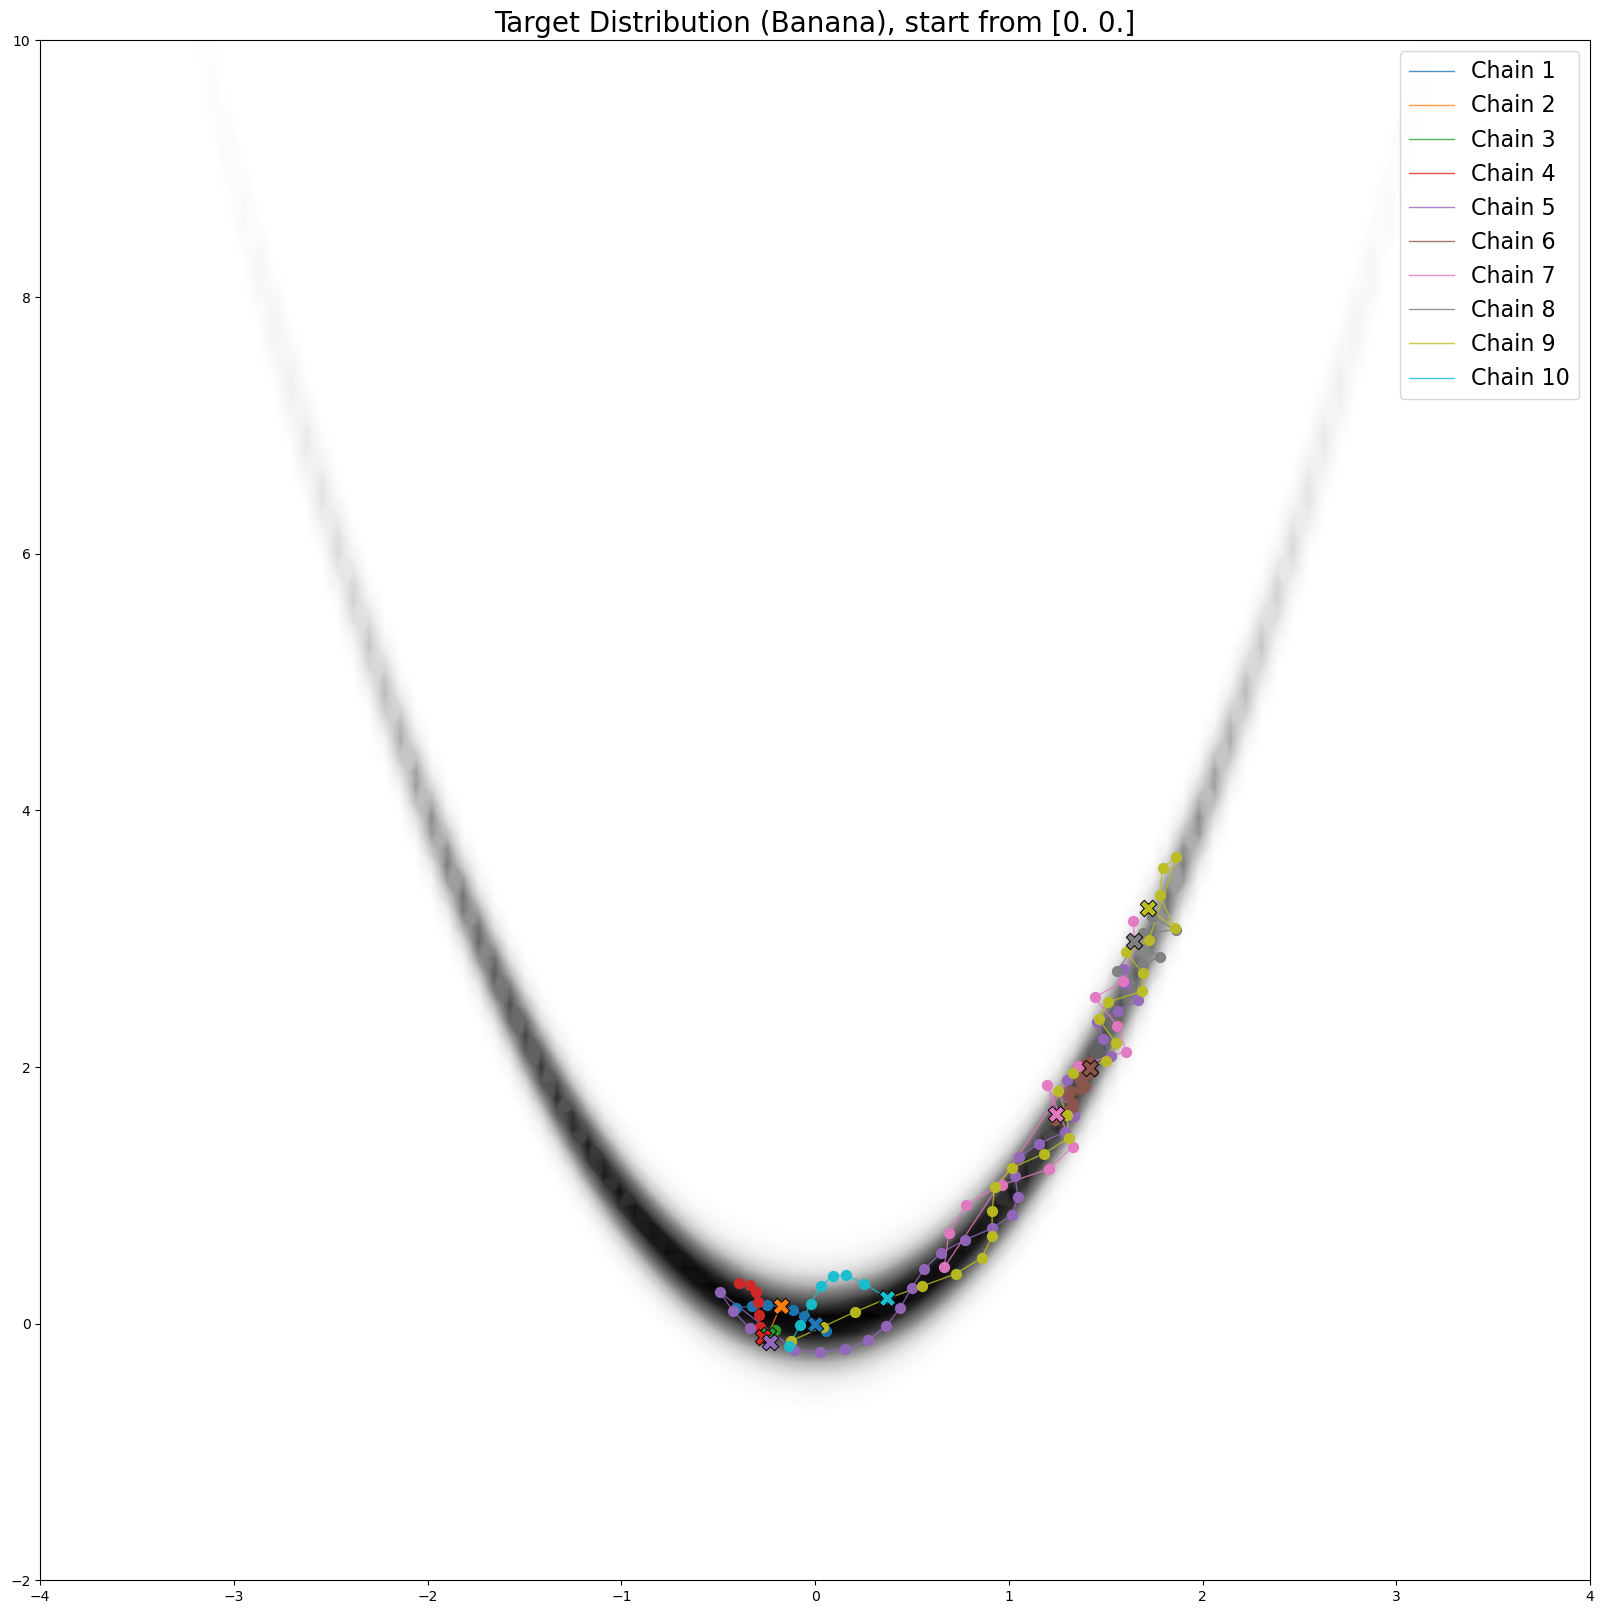

In [296]:
theta0 = np.array([0, 0])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_banana(all_positions)

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

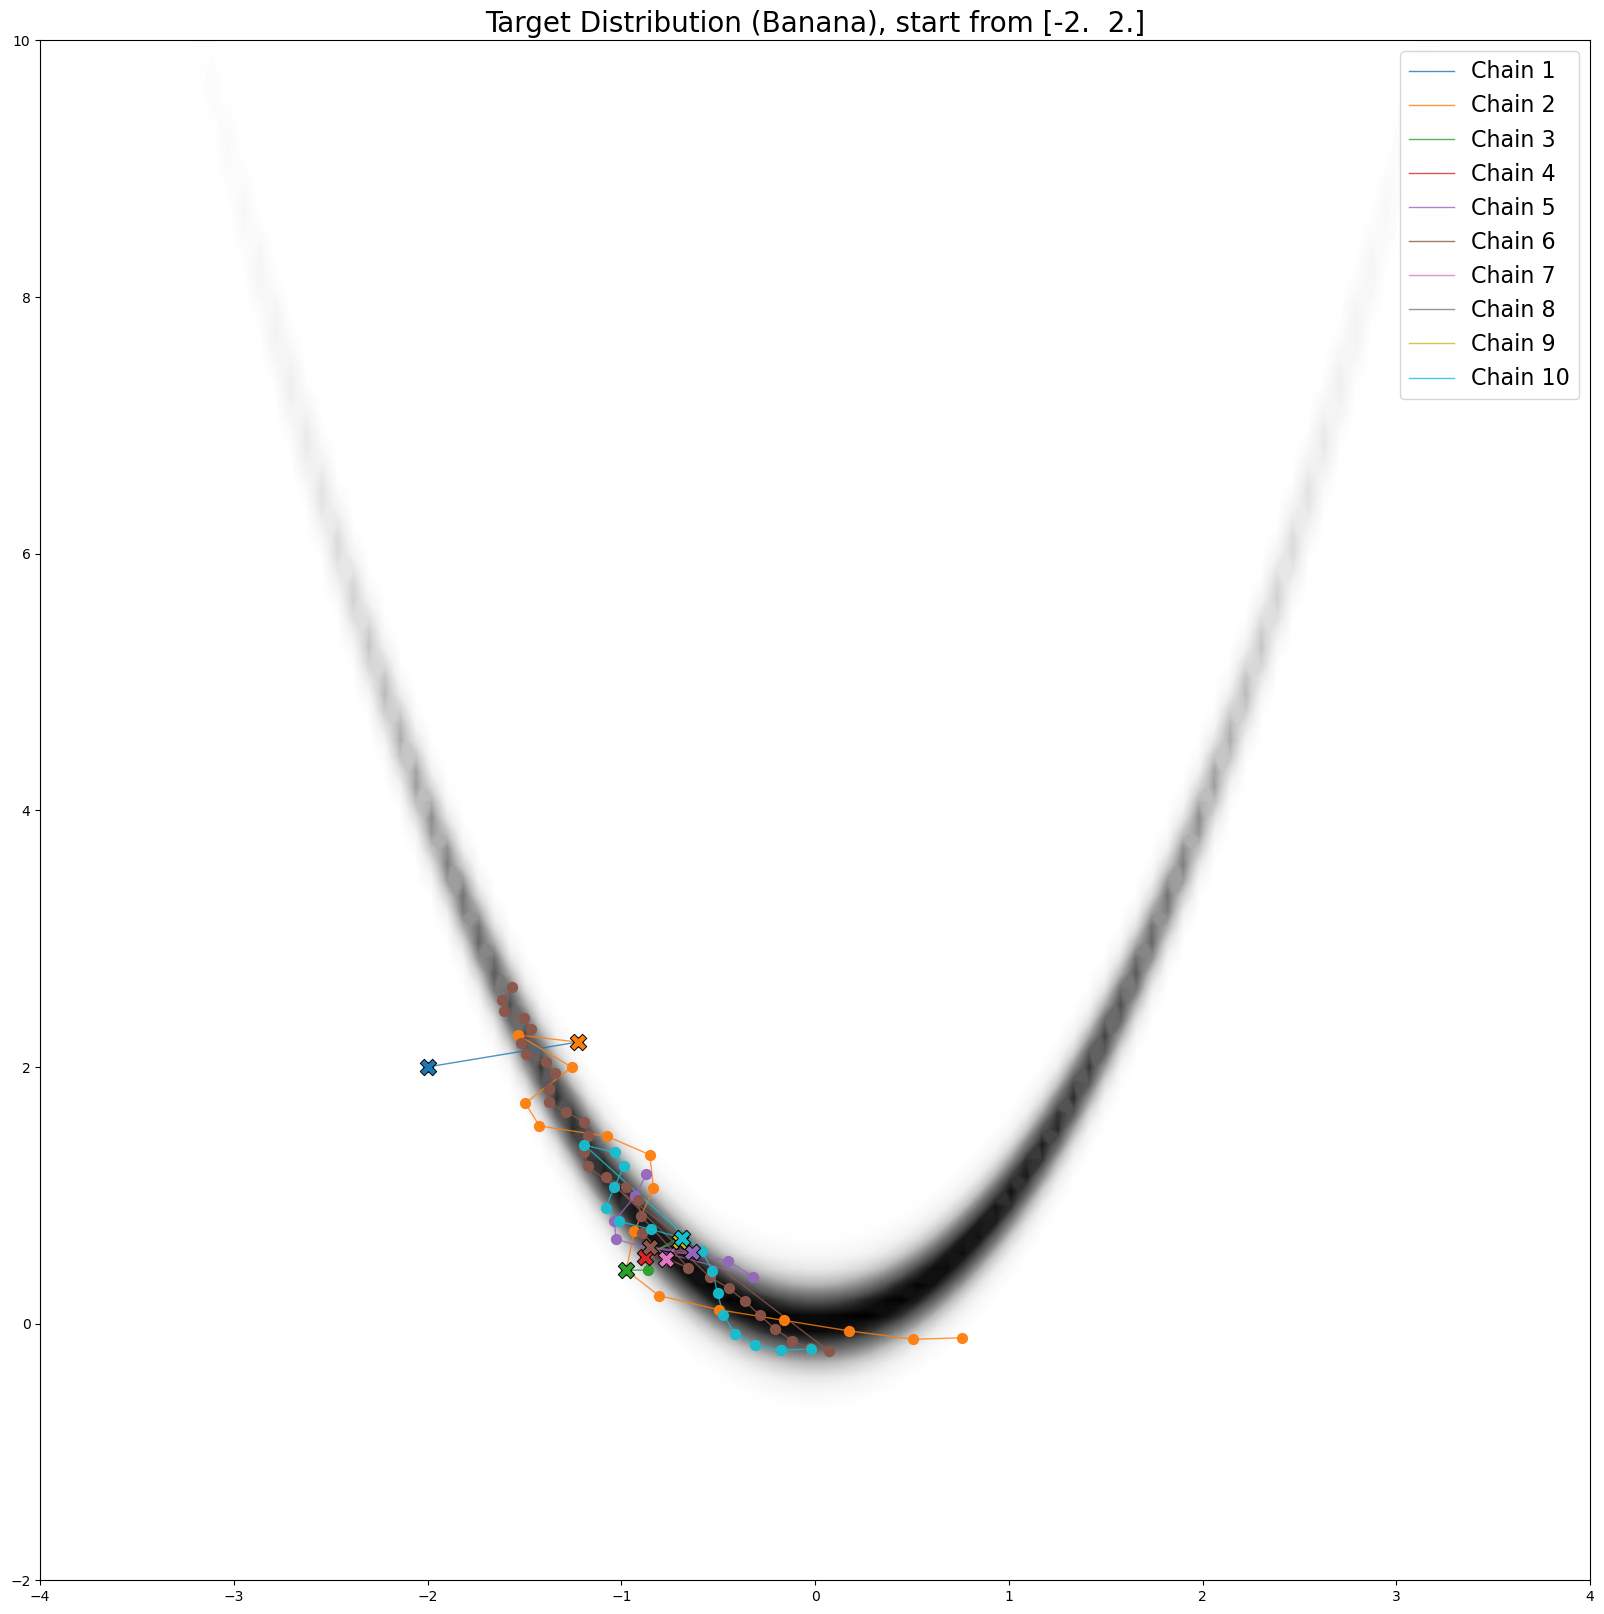

In [297]:
theta0 = np.array([-2, 2])  # a much weaker ability to cover both part of the banana density (sometimes only half part)
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_banana(all_positions)

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

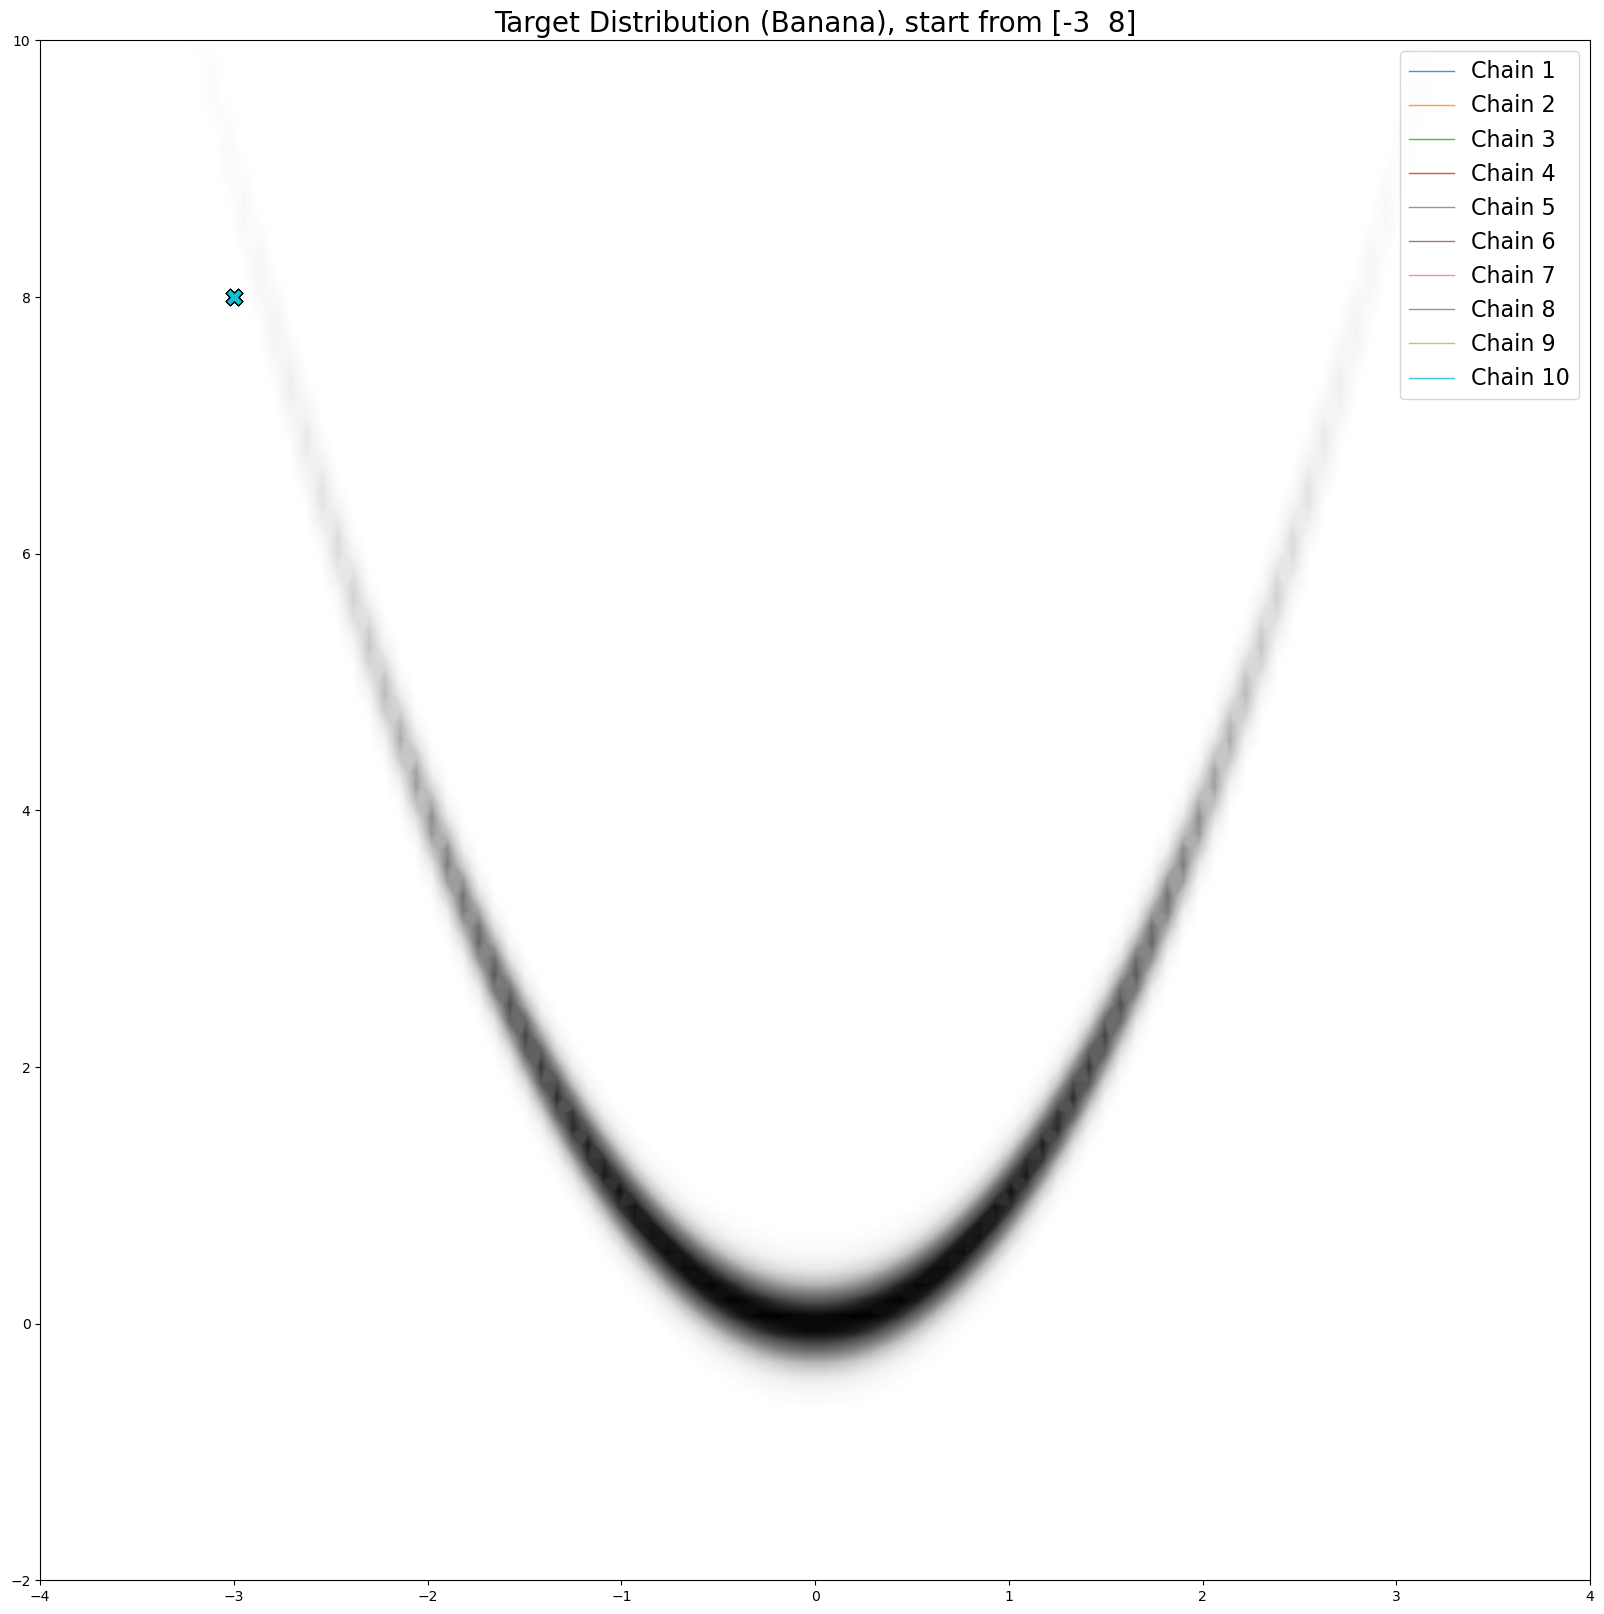

In [298]:
theta0 = np.array([-3, 8])  # stopping criteria very easy to meet and hardly move - stick on the starting point
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_banana(all_positions)

**Efficient NUTS would share the same intermediate states as naive NUTS, as the only difference between these two NUTS algorithm is the selection scheme from position chain at each iteration.**

Investigate how many samples are needed until to move to a sensible place to cover the whole distribution later. 

There are total 9 out of 10 samples do not move w.r.t the previous position.
The proportion of moving is 0.100.


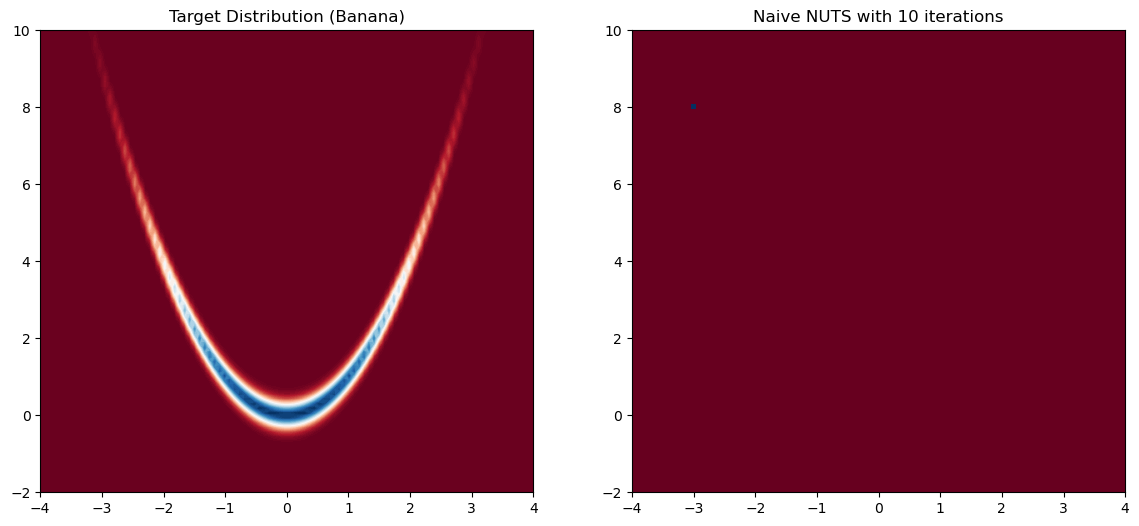

There are total 99 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 0.010.


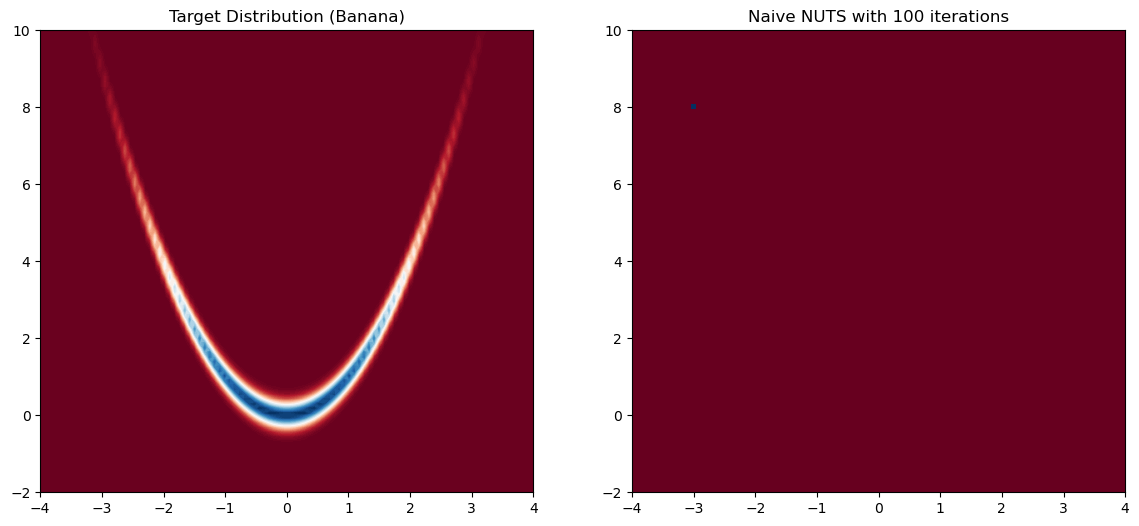

There are total 924 out of 1000 samples do not move w.r.t the previous position.
The proportion of moving is 0.076.


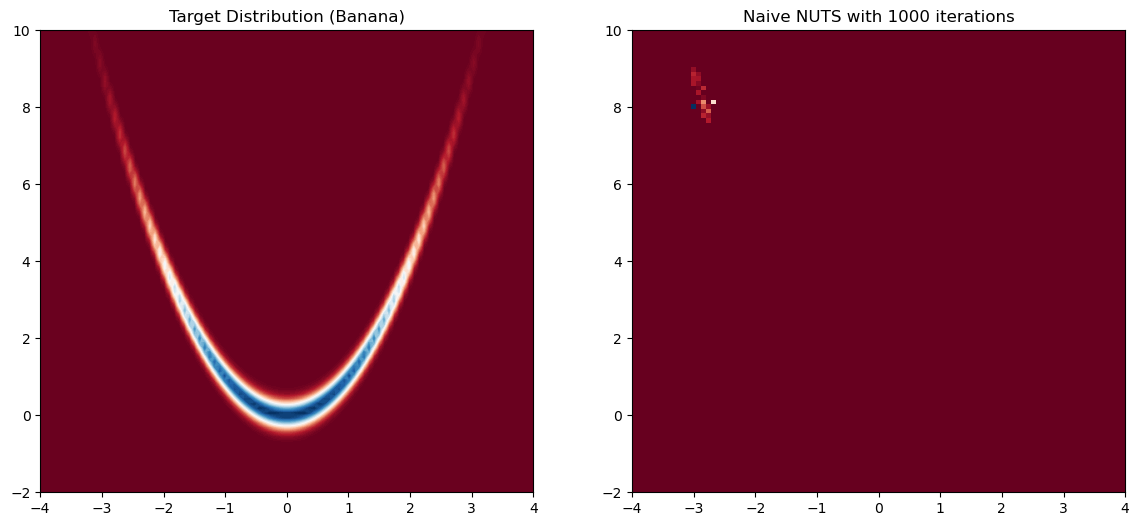

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\1494134929.py:17: RuntimeWarning: overflow encountered in matmul
  kinetic_energy = 0.5 * r.T @ M_inv @ r
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2530300803.py:3: RuntimeWarning: overflow encountered in scalar power
  return -theta[0]**2 / 30 - theta[1]**2 / 30 - 10*(theta[1]-theta[0]**2)**2
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2225528151.py:61: RuntimeWarning: overflow encountered in matmul
  u_turn_indicator =  int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\277881251.py:45: RuntimeWarning: overflow encountered in matmul
  s = s_prime * int((theta_plus - theta_minus).T @ r_minus >= 0) * int((theta_plus - theta_minus).T @ r_plus >= 0)
C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2530300803.py:7: RuntimeWarning: overflow encountered in scalar multiply
  partial_x = -theta[0] / 15 + 40 * theta[0] * (theta[1] - 

There are total 5286 out of 10000 samples do not move w.r.t the previous position.
The proportion of moving is 0.471.


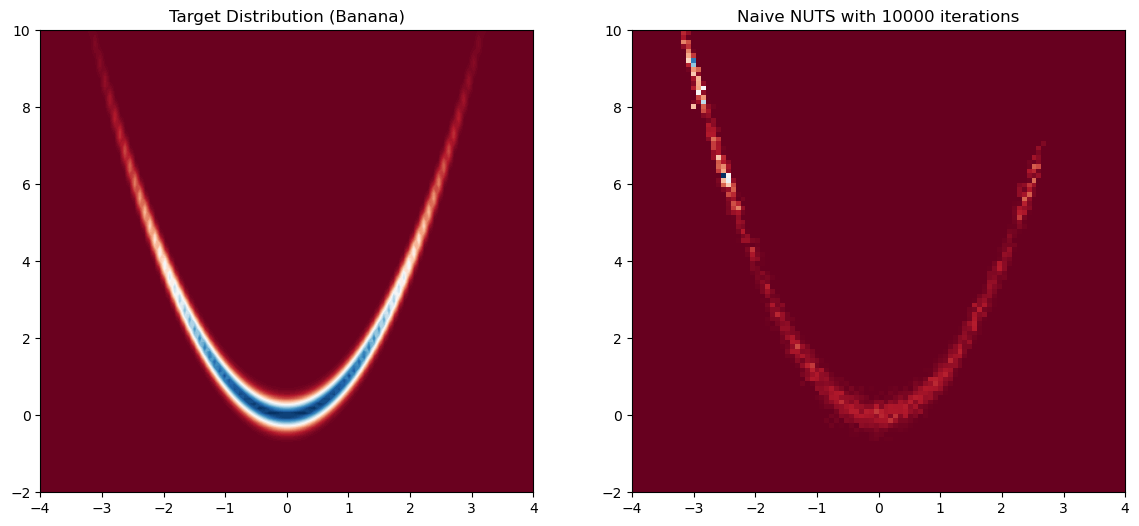

C:\Users\Peiyi\AppData\Local\Temp\ipykernel_30524\2530300803.py:8: RuntimeWarning: overflow encountered in scalar multiply
  partial_y = -theta[1] / 15 - 20 * (theta[1] - theta[0]**2)


There are total 29513 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.705.


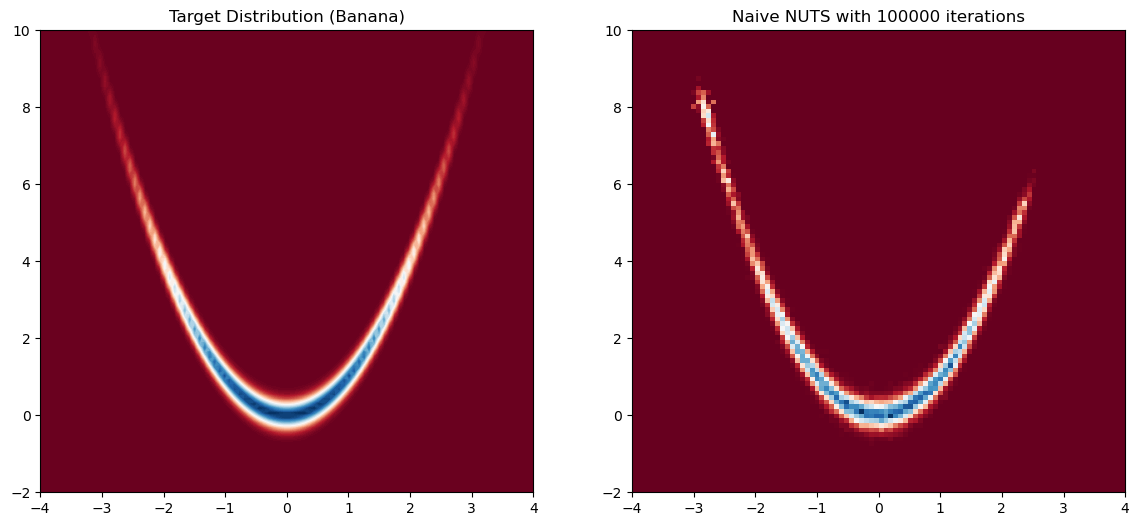

In [299]:
theta0 = np.array([-3, 8])
M = np.eye(2)  # identity mass

for num_samples in [10, 100, 1000, int(1e4), int(1e5)]:
    samples, C, _ = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

    # for surf plot of standard bivariate Gaussian 2d
    x_bb = np.linspace(-4, 4, 100)
    y_bb = np.linspace(-2, 10, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_banana(X_bb, Y_bb))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    plt.title('Target Distribution (Banana)')

    #burn_in = int(0.2 * num_samples)  # 20% burn-in
    burn_in = 0
    x = samples[burn_in:, 0]
    y = samples[burn_in:, 1]
    plt.subplot(1, 2, 2)
    plt.hist2d(x, y, bins=100, range=[[-4, 4], [-2, 10]], cmap='RdBu', density=True)
    plt.title(f'Naive NUTS with {num_samples} iterations')
    plt.show()

**Case 2: standard Gaussian density.**

In [300]:
def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_standard_normal(x, y):
    return -0.5 * (x**2 + y**2)

In [301]:
def plot_trajectory_std_Gaussian(all_positions):
    
    plt.figure(figsize=(20, 20))

    # Draw contour background
    x_bb = np.linspace(-4, 4, 100)
    y_bb = np.linspace(-4, 4, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='Greys')

    # Plot trajectories on top
    cmap = plt.get_cmap('tab10')  # different colors for at most 10 chains (so num_samples <= 10)
    for i, pos_chain in enumerate(all_positions):
        color = cmap(i % 10)
        plt.plot(pos_chain[:, 0], pos_chain[:, 1], linestyle='-', linewidth=1, alpha=0.8, color=color, zorder=3,
                 label=f'Chain {i+1}')
        plt.scatter(pos_chain[:, 0], pos_chain[:, 1], s=50, alpha=0.95, color=color, zorder=4)

        # Highlight first sample, as the taken position sample for the naiveNUTS
        plt.scatter(pos_chain[0, 0], pos_chain[0, 1], s=140, marker='X', edgecolor='k',
                    linewidth=0.7, zorder=6, color=color)

    plt.title(f'Target Distribution (standard Gaussian), start from {all_positions[0][0]}', fontsize=20)
    plt.legend(fontsize=16)
    plt.show()

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

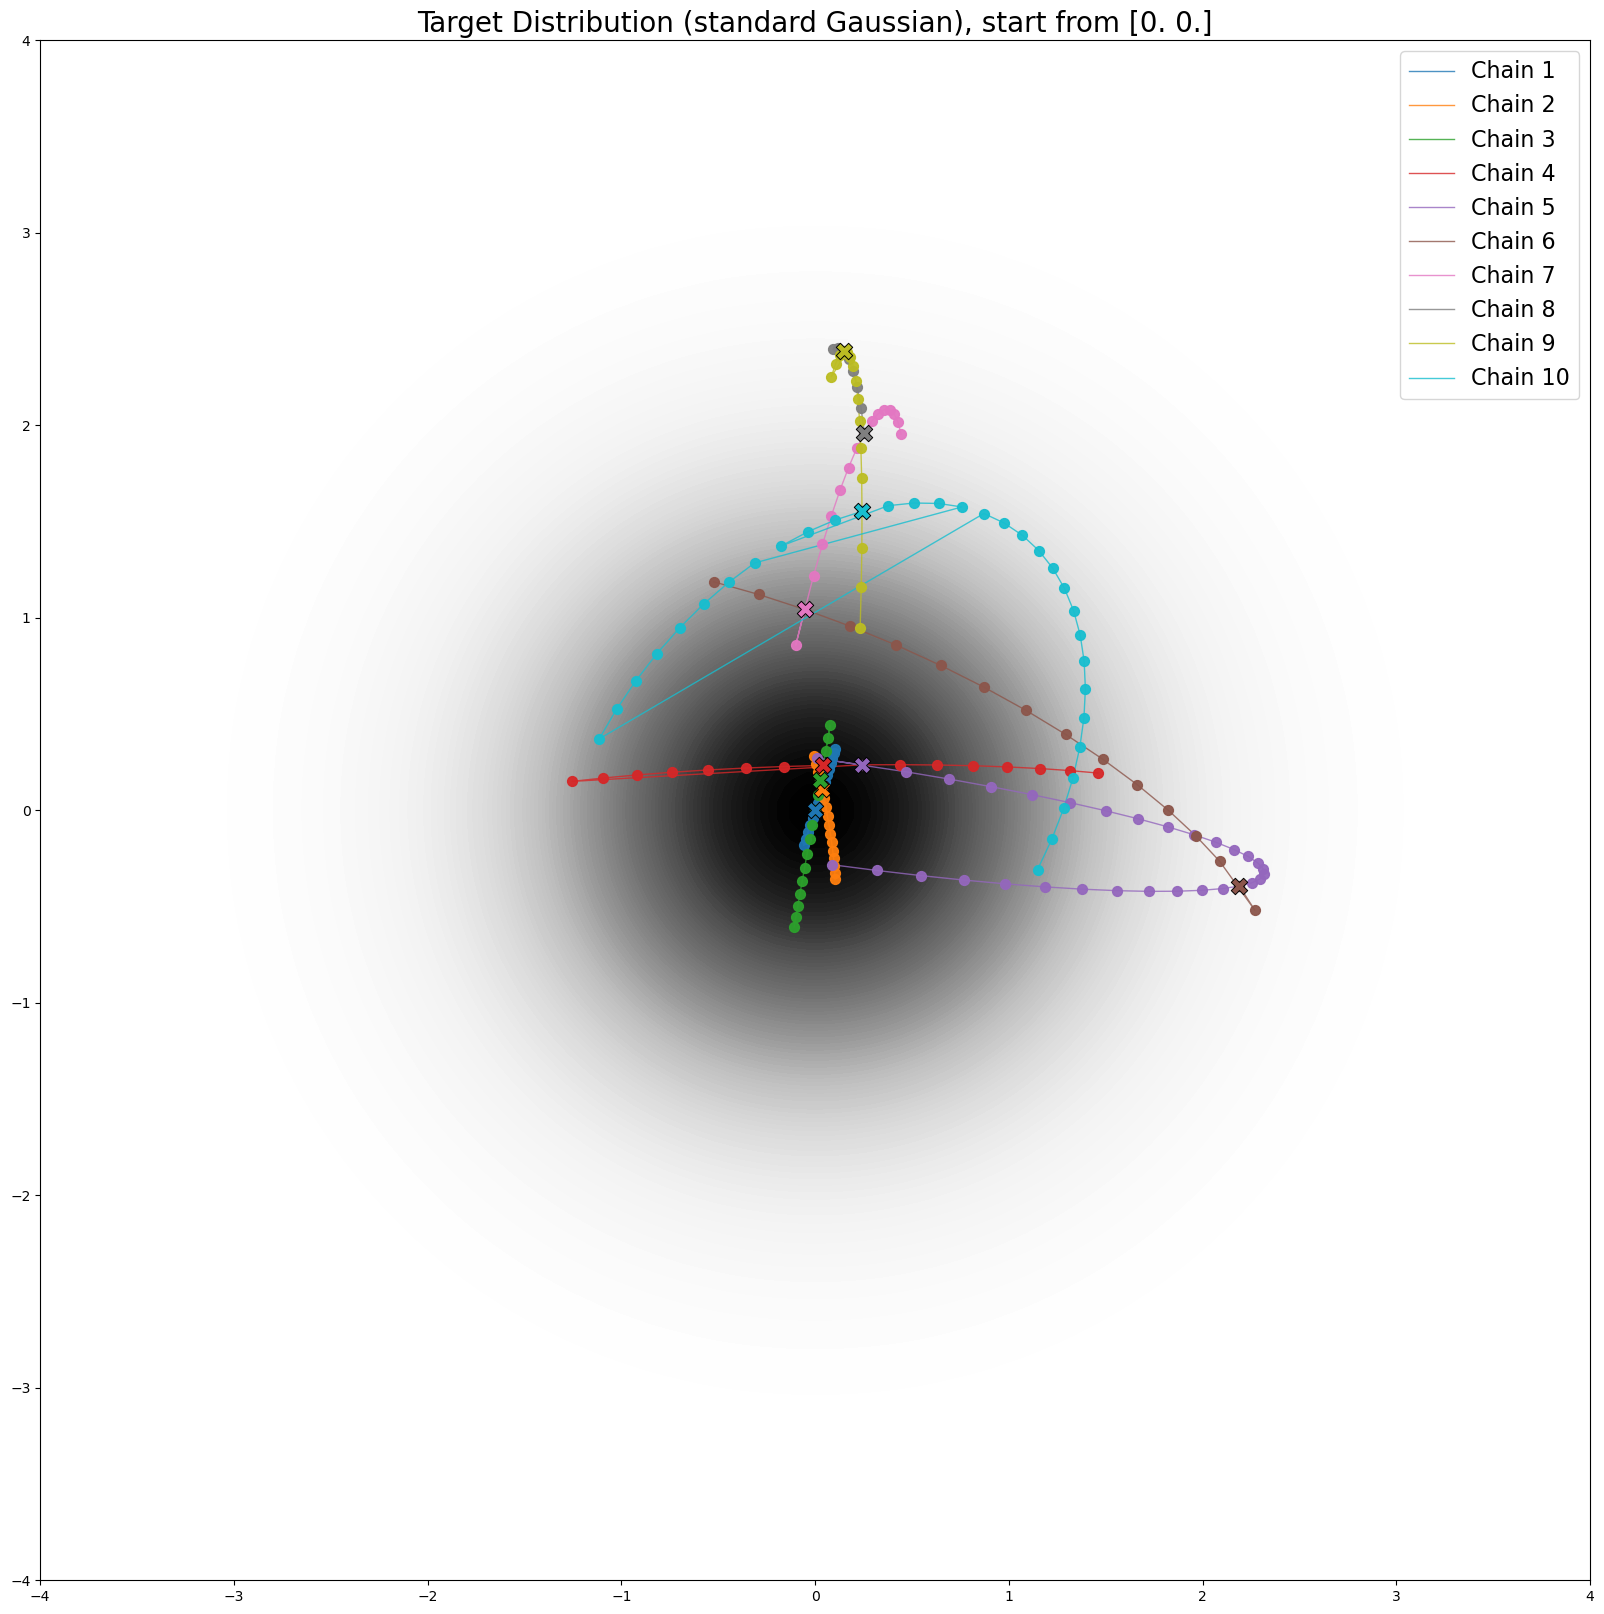

In [302]:
theta0 = np.array([0, 0])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_std_Gaussian(all_positions)

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

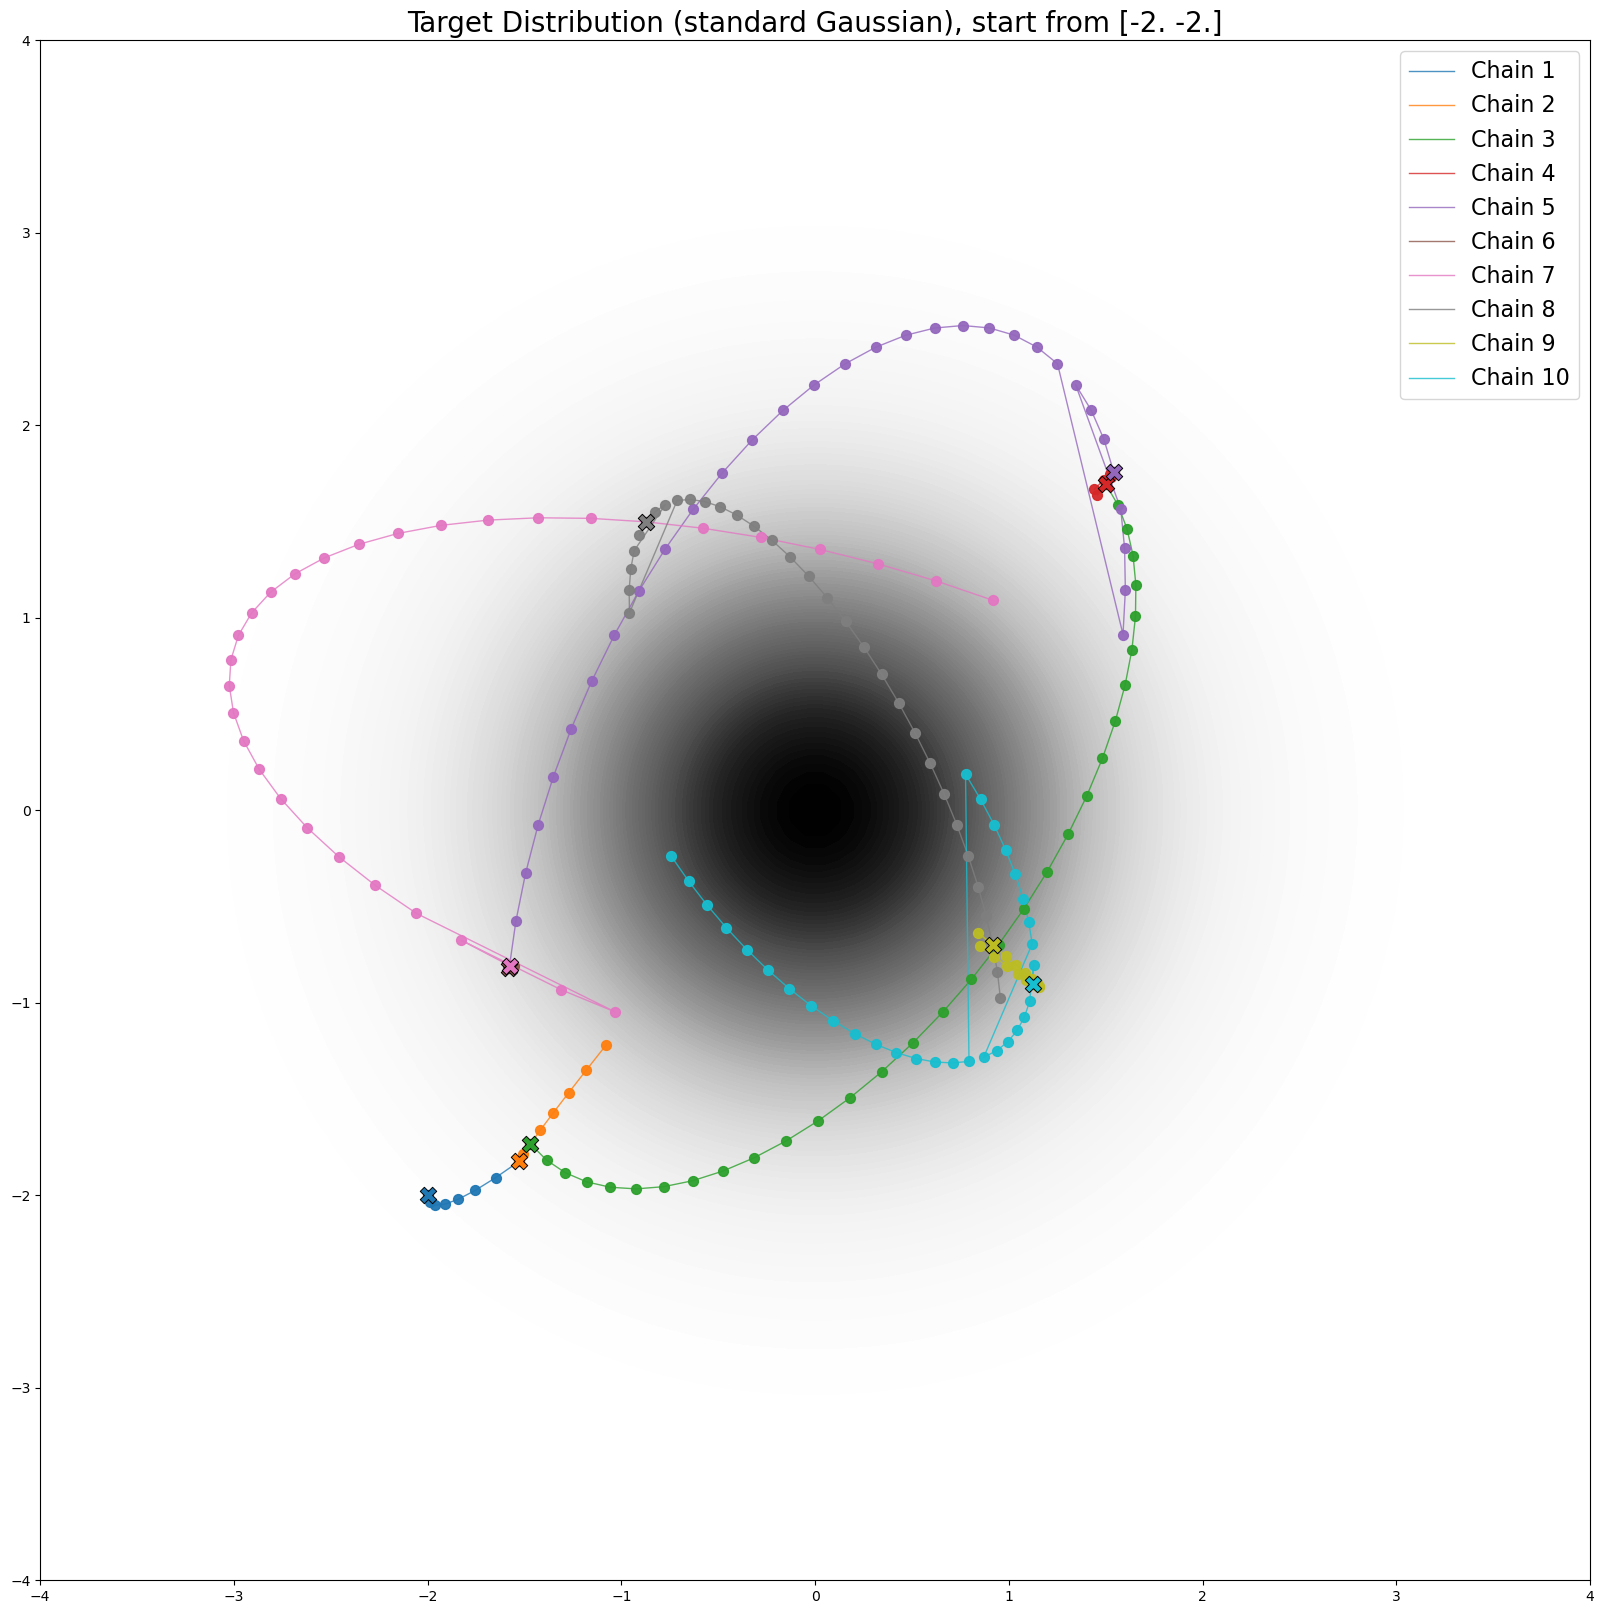

In [303]:
theta0 = np.array([-2, -2])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_std_Gaussian(all_positions)

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

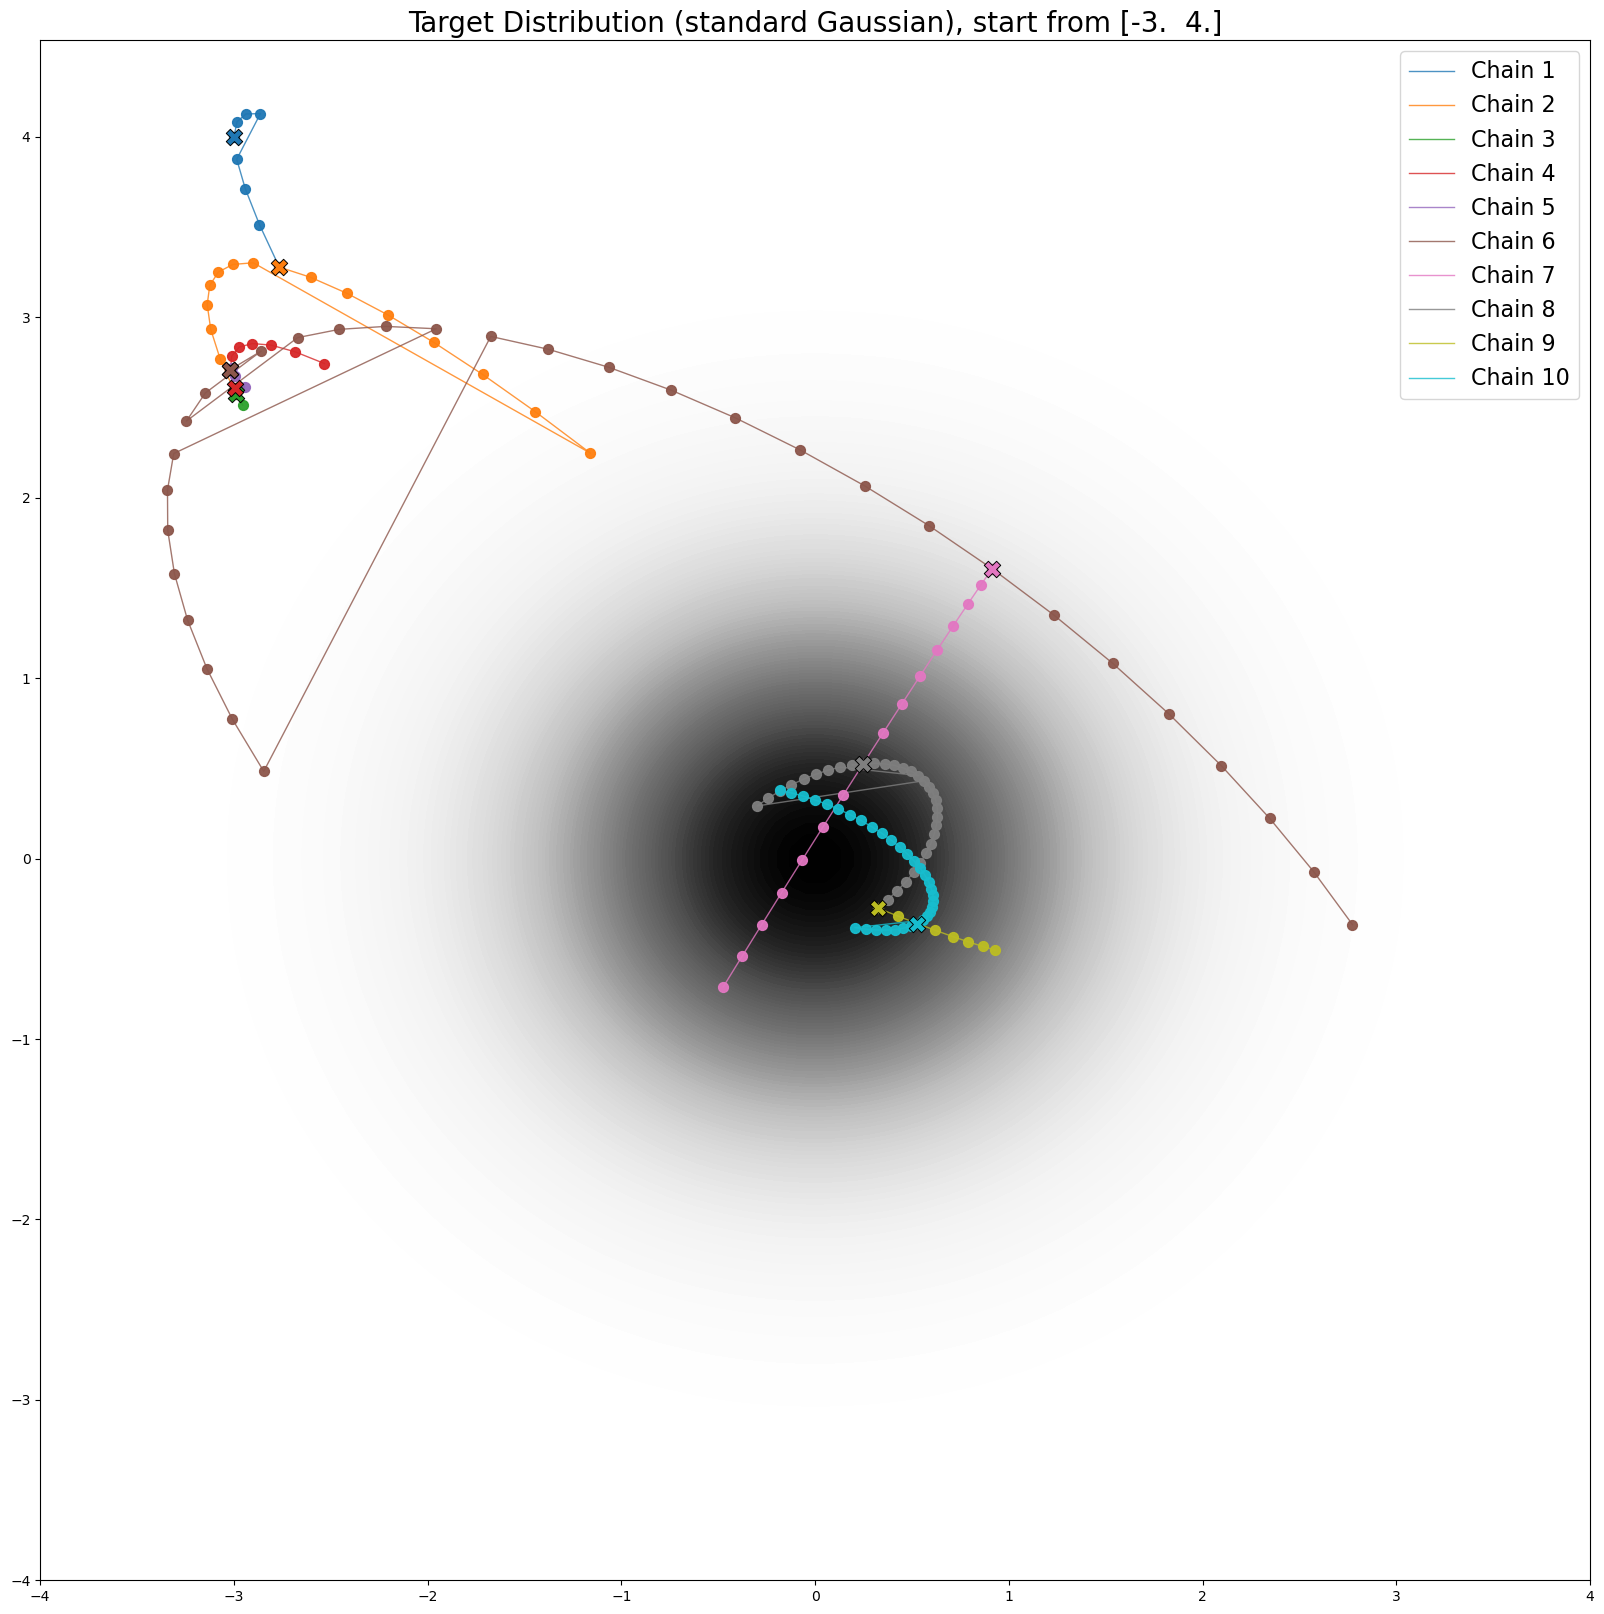

In [304]:
theta0 = np.array([-3, 4])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_std_Gaussian(all_positions)

There are total 0 out of 10 samples do not move w.r.t the previous position.
The proportion of moving is 1.000.


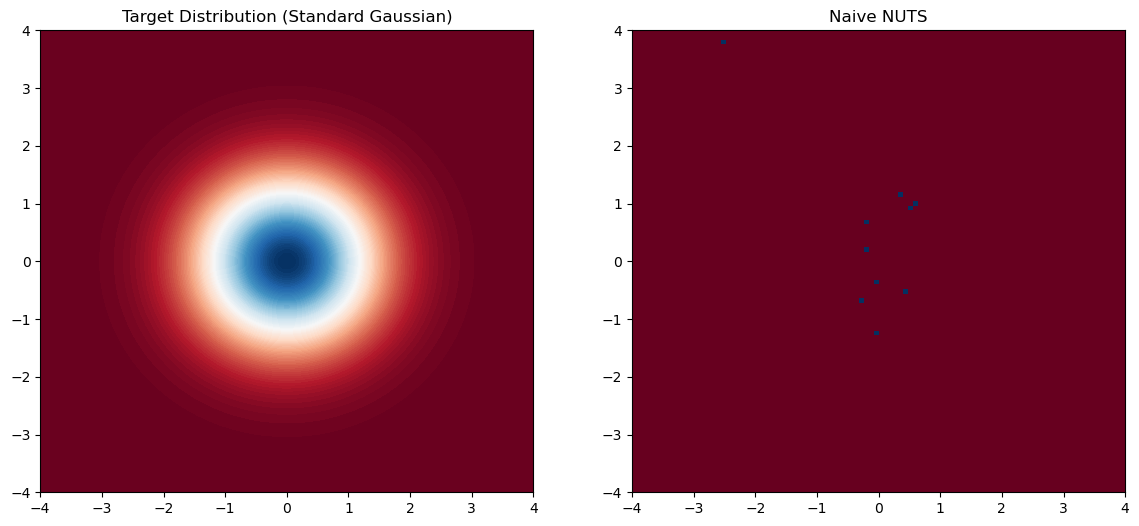

There are total 6 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 0.940.


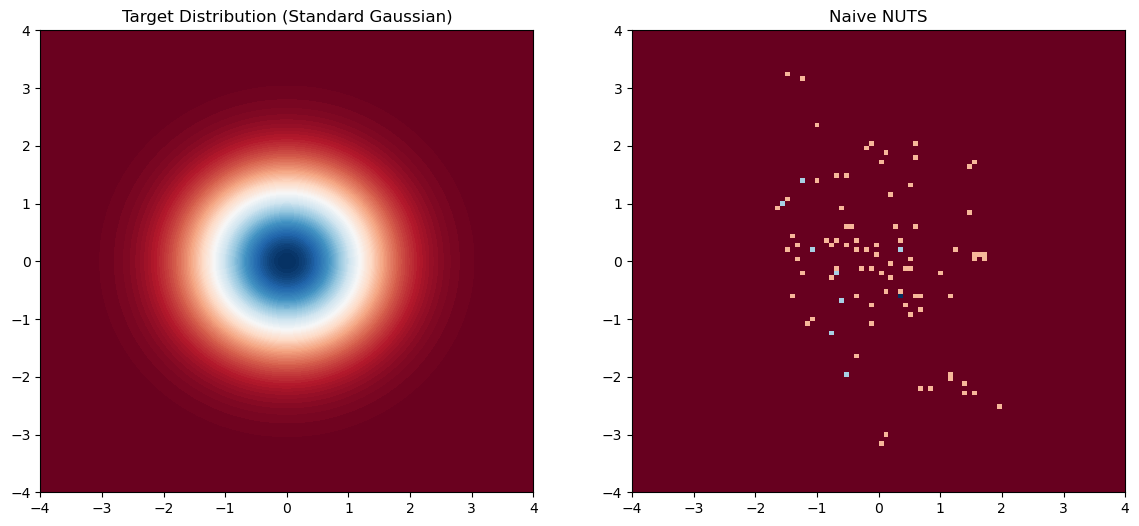

There are total 51 out of 1000 samples do not move w.r.t the previous position.
The proportion of moving is 0.949.


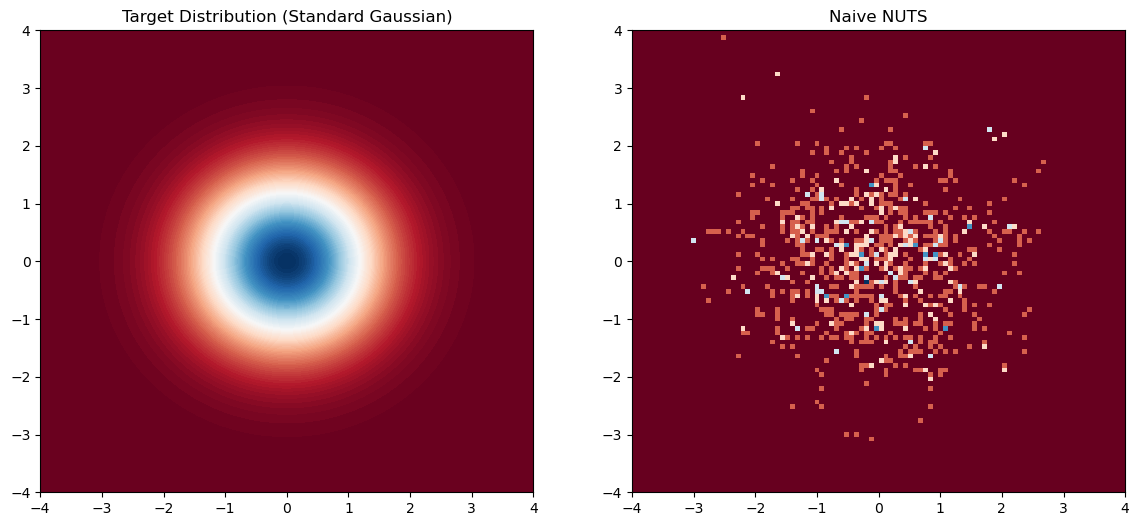

There are total 620 out of 10000 samples do not move w.r.t the previous position.
The proportion of moving is 0.938.


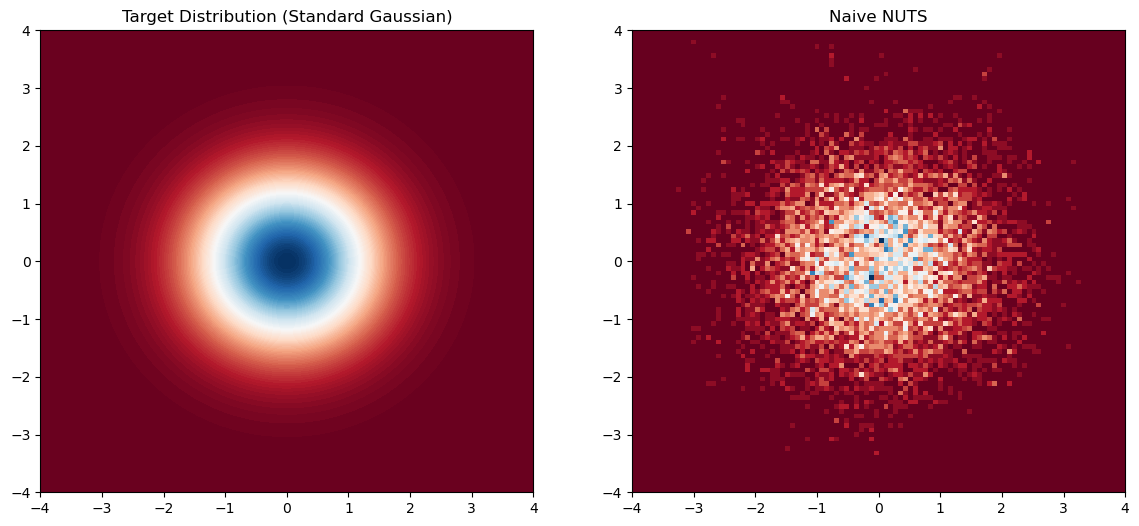

There are total 5872 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.941.


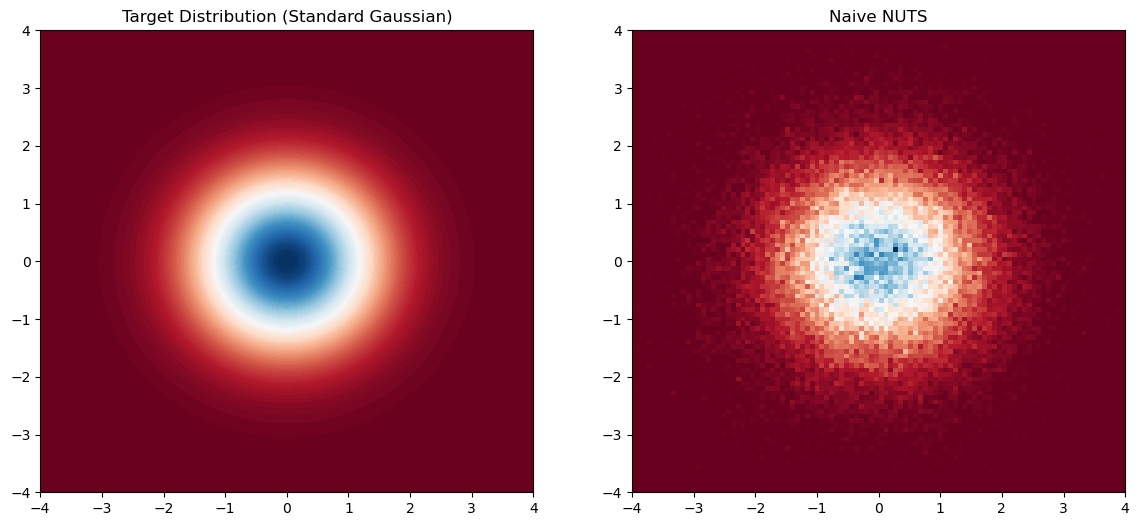

In [305]:
theta0 = np.array([-3, 4])
M = np.eye(2)  # identity mass

for num_samples in [10, 100, 1000, int(1e4), int(1e5)]:
    samples, C, _ = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

    # for surf plot of standard bivariate Gaussian 2d
    x_bb = np.linspace(-4, 4, 100)
    y_bb = np.linspace(-4, 4, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_standard_normal(X_bb, Y_bb))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    plt.title('Target Distribution (Standard Gaussian)')

    #burn_in = int(0.2 * num_samples)  # 20% burn-in
    burn_in = 0  # if we do not consider burnin samples...
    x = samples[burn_in:, 0]
    y = samples[burn_in:, 1]
    plt.subplot(1, 2, 2)
    plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap='RdBu', density=True)
    plt.title('Naive NUTS')
    plt.show()

**Case 3: Gaussian with different variances for different directions, but two uncorrelated components ($\rho=0$).**

In [316]:
def example_log_prob(theta):
    x, y = theta
    return -0.5 * ((x - 1)**2/0.5**2 + (y + 1)**2/3**2)

def example_grad_log_prob(theta):
    # Gradient of log-density
    x, y = theta
    partial_x = 4 * (1 - x)
    partial_y = -(y + 1)/9
    return np.array([partial_x, partial_y])

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_stretch_normal(x, y):
    return -0.5 * ((x - 1)**2/0.5**2 + (y + 1)**2/3**2)

In [317]:
def plot_trajectory_stretch_Gaussian(all_positions):
    
    plt.figure(figsize=(20, 20))

    # Draw contour background
    x_bb = np.linspace(-2, 4, 100)
    y_bb = np.linspace(-12, 8, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_stretch_normal(X_bb, Y_bb))
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='Greys')

    # Plot trajectories on top
    cmap = plt.get_cmap('tab10')  # different colors for at most 10 chains (so num_samples <= 10)
    for i, pos_chain in enumerate(all_positions):
        color = cmap(i % 10)
        plt.plot(pos_chain[:, 0], pos_chain[:, 1], linestyle='-', linewidth=1, alpha=0.8, color=color, zorder=3,
                 label=f'Chain {i+1}')
        plt.scatter(pos_chain[:, 0], pos_chain[:, 1], s=50, alpha=0.95, color=color, zorder=4)

        # Highlight first sample, as the taken position sample for the naiveNUTS
        plt.scatter(pos_chain[0, 0], pos_chain[0, 1], s=140, marker='X', edgecolor='k',
                    linewidth=0.7, zorder=6, color=color)

    plt.title(f'Target Distribution (standard Gaussian), start from {all_positions[0][0]}', fontsize=20)
    plt.legend(fontsize=16)
    plt.show()

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

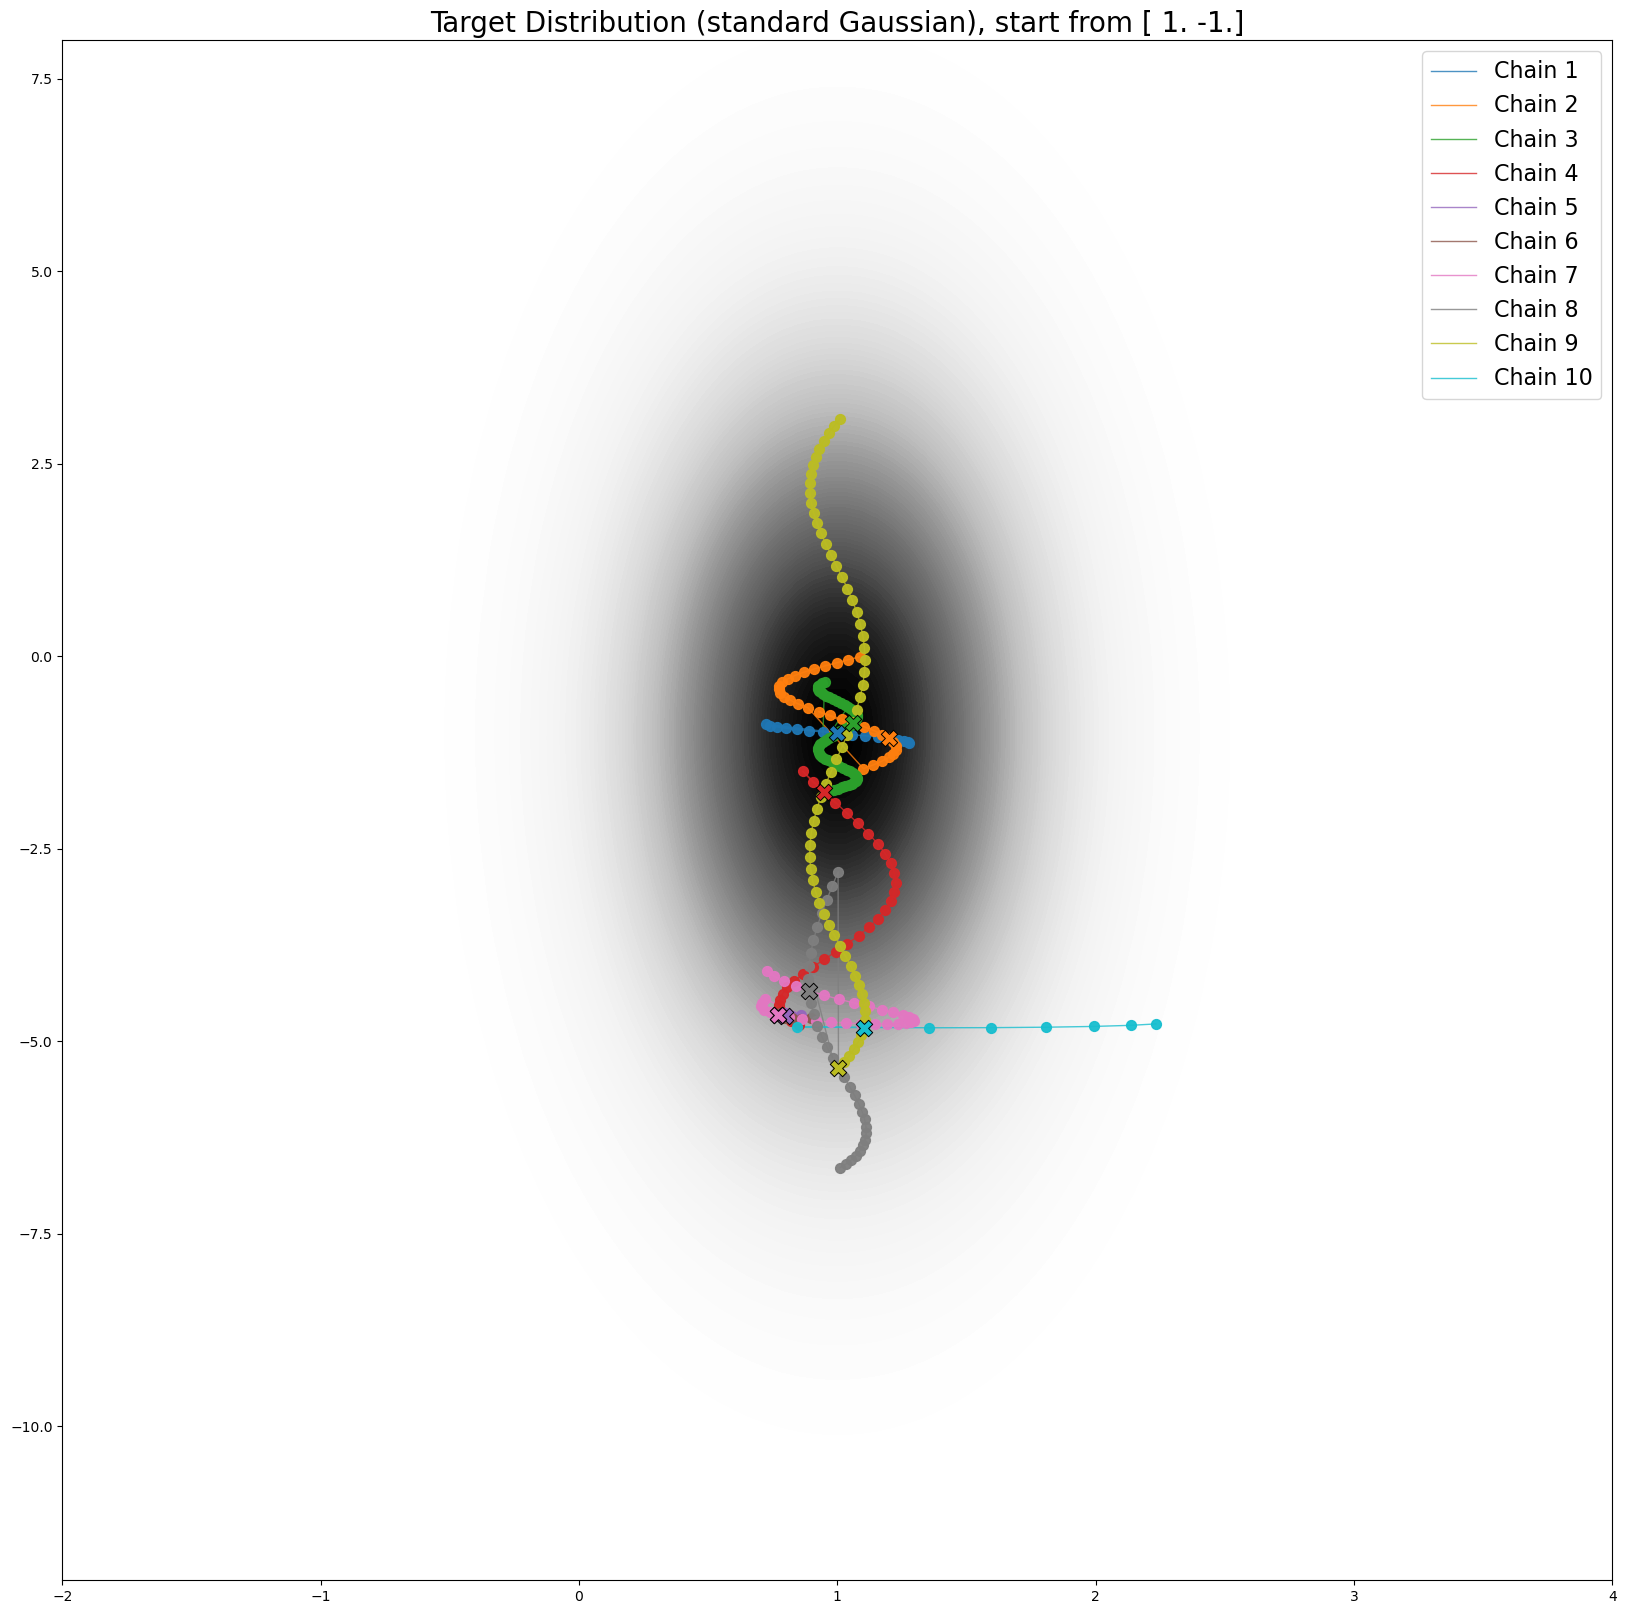

In [318]:
theta0 = np.array([1, -1])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_stretch_Gaussian(all_positions)

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

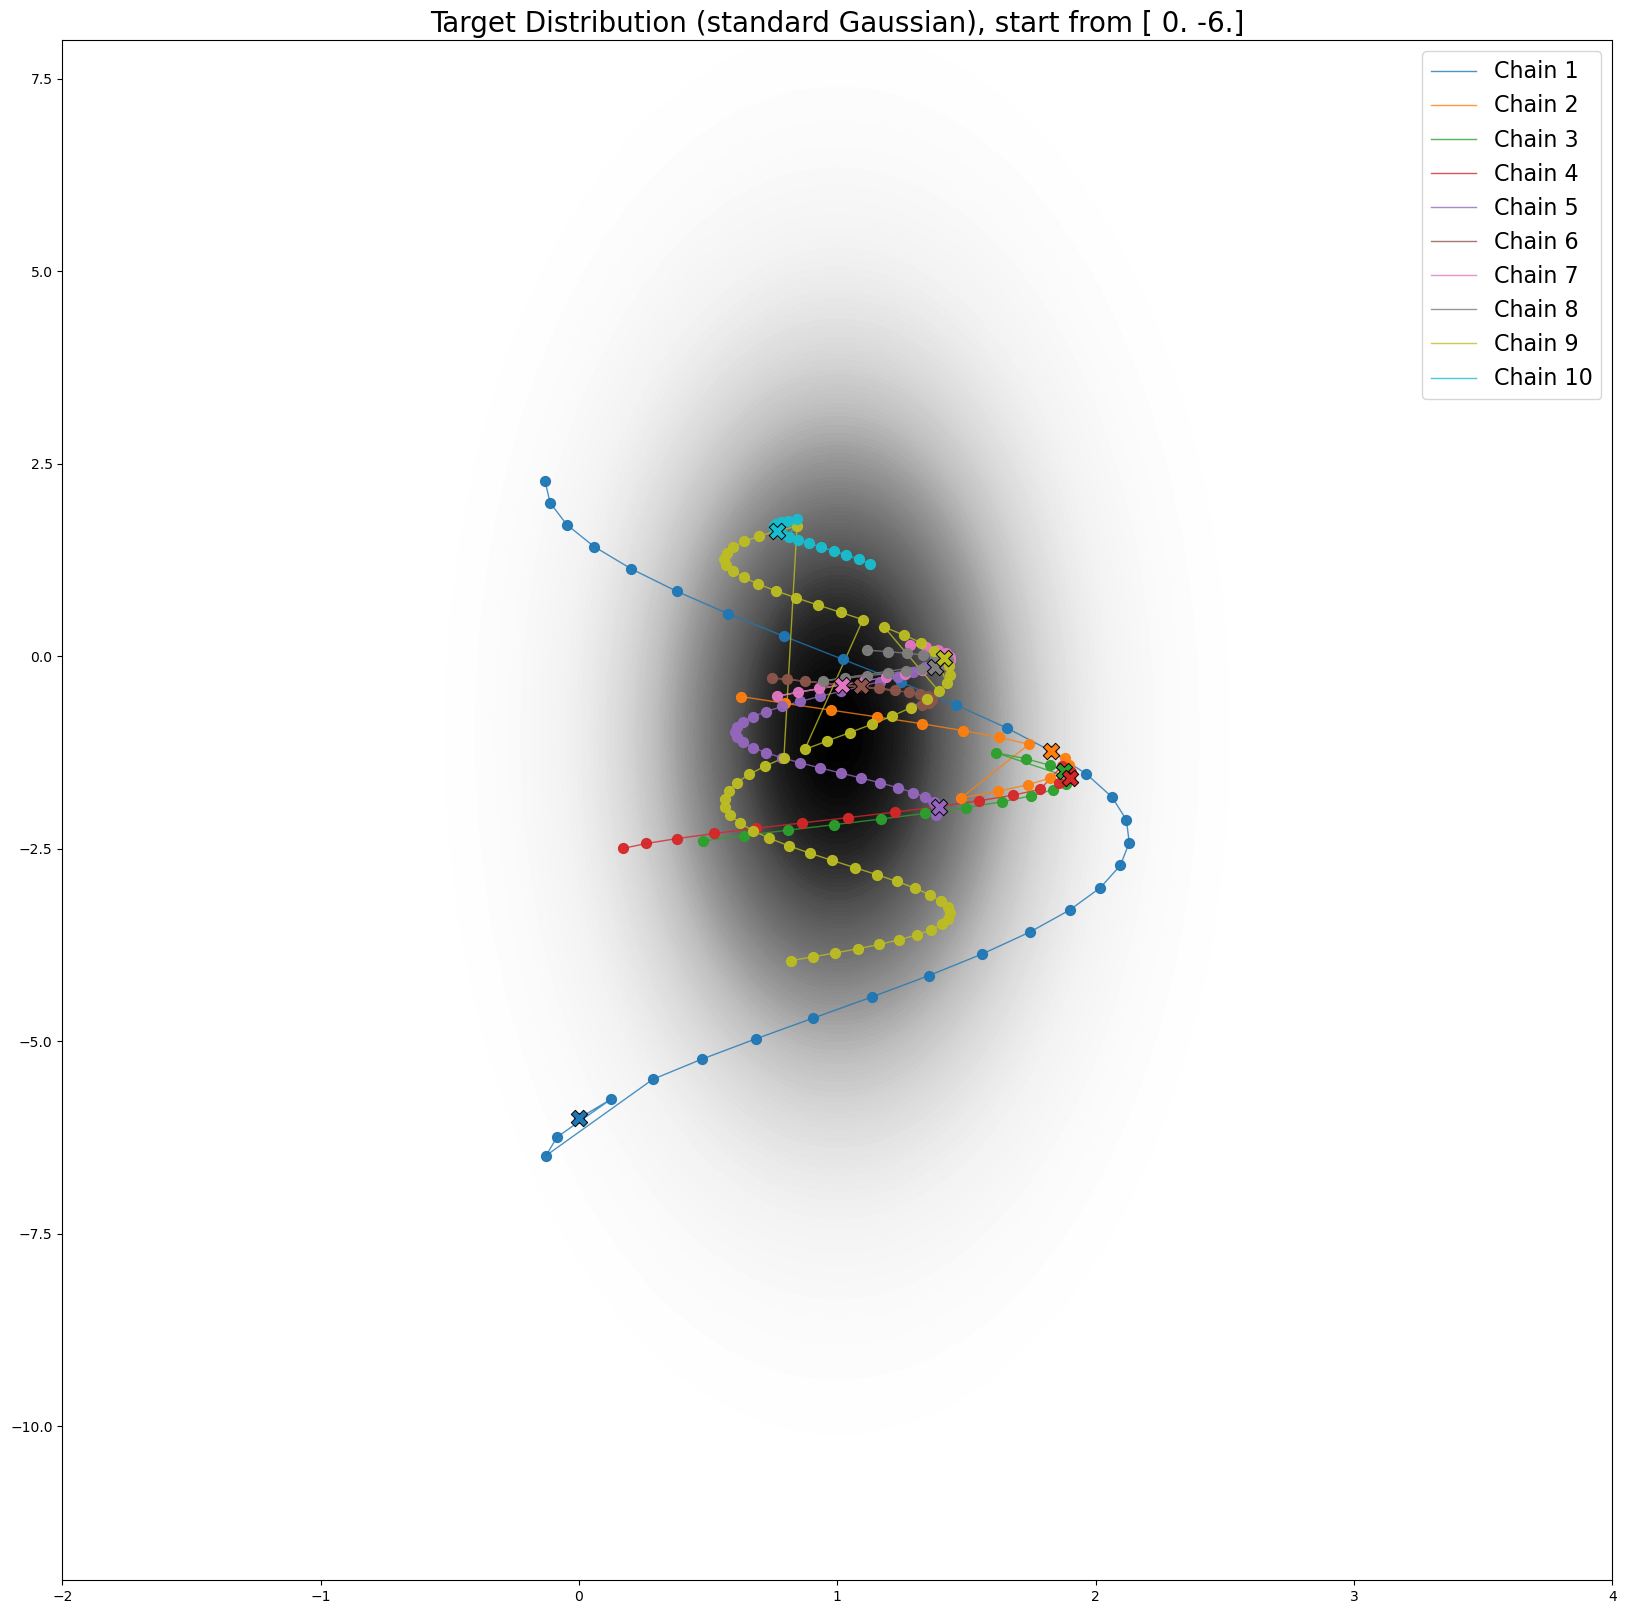

In [310]:
theta0 = np.array([0, -6])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_stretch_Gaussian(all_positions)

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

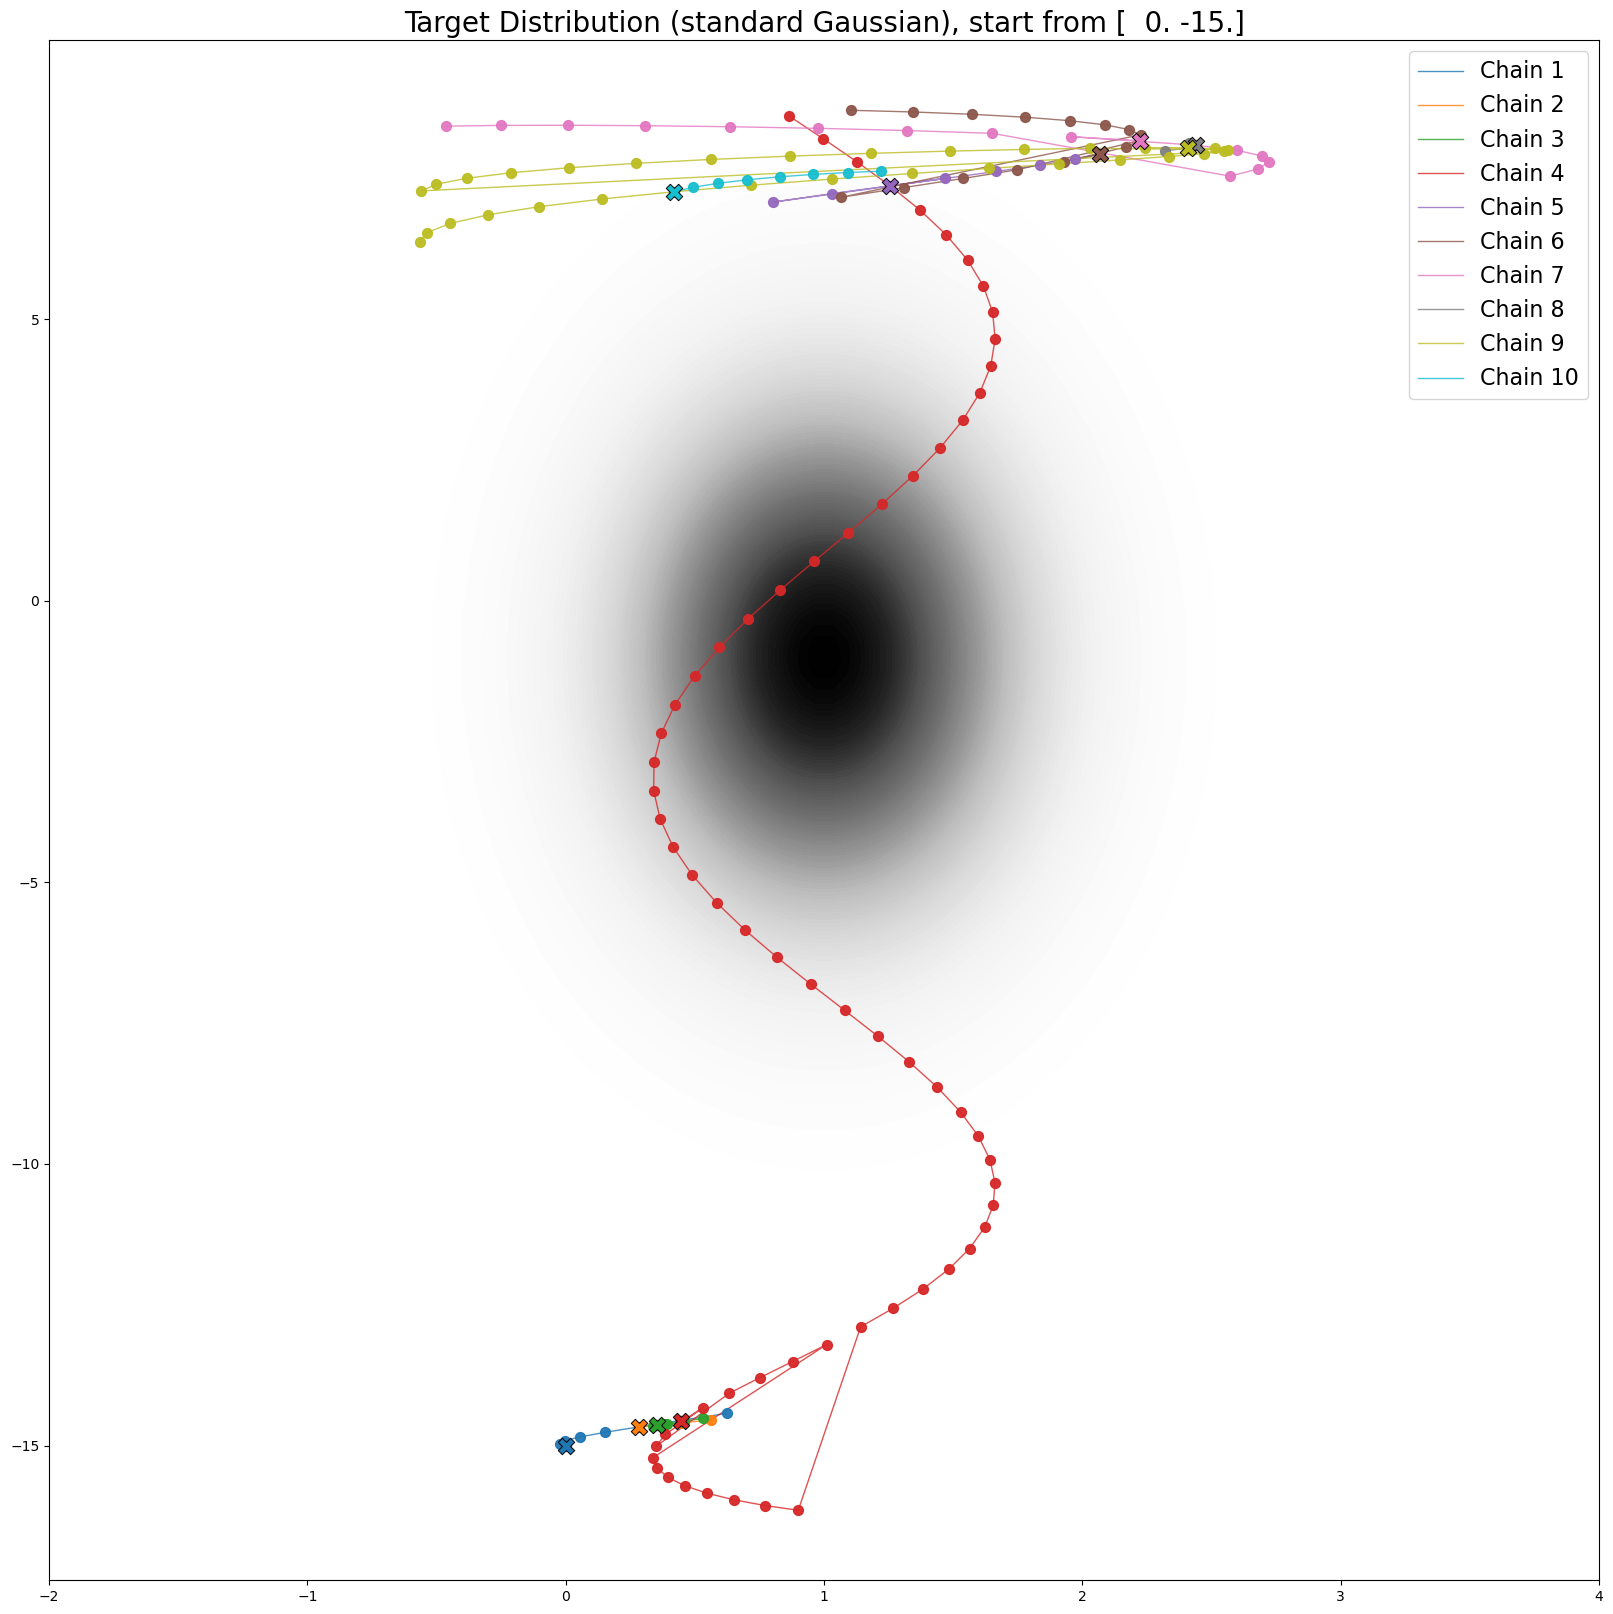

In [311]:
theta0 = np.array([0, -15])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_stretch_Gaussian(all_positions)

There are total 0 out of 10 samples do not move w.r.t the previous position.
The proportion of moving is 1.000.


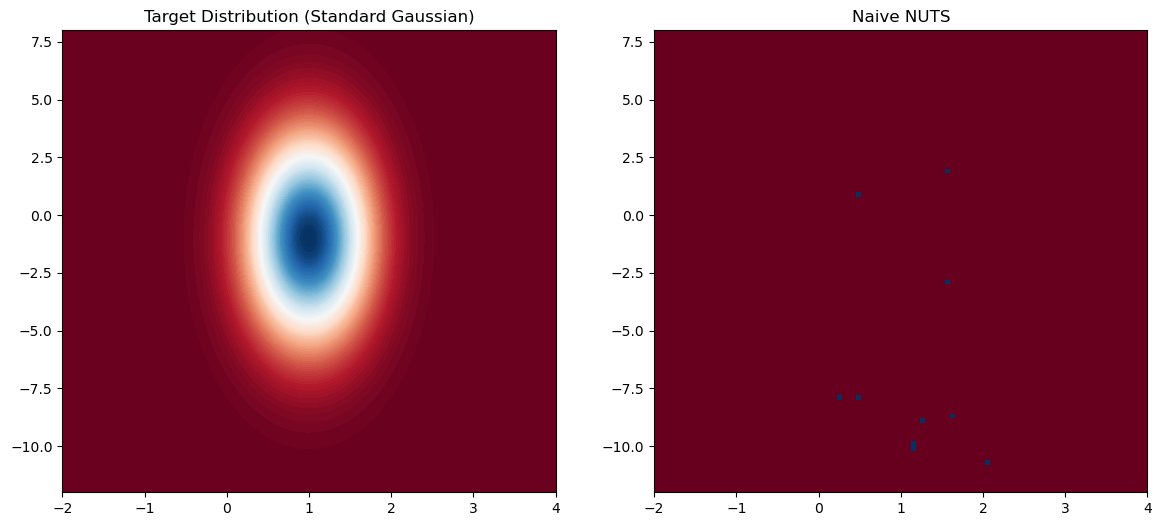

There are total 7 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 0.930.


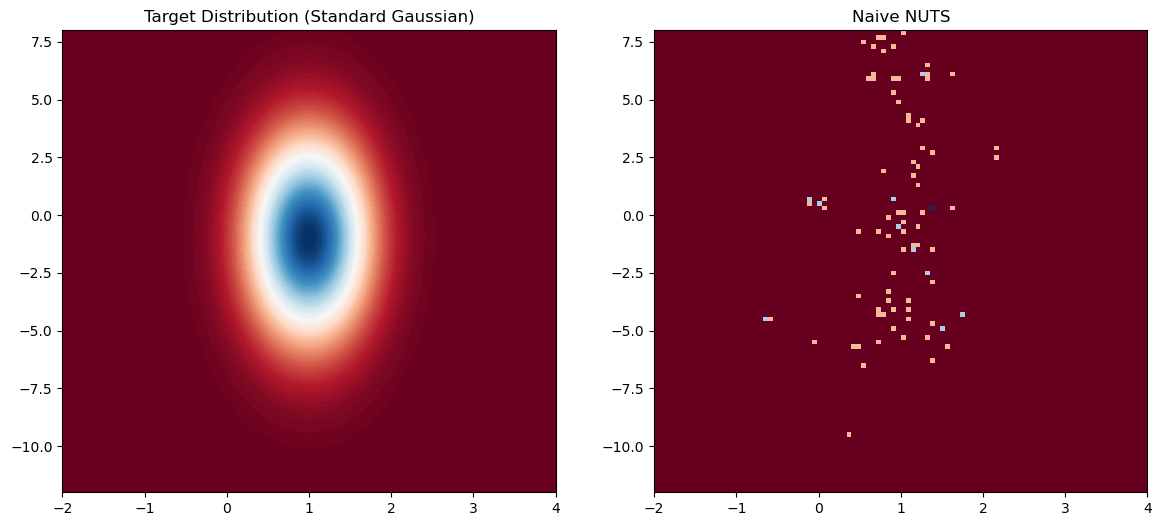

There are total 56 out of 1000 samples do not move w.r.t the previous position.
The proportion of moving is 0.944.


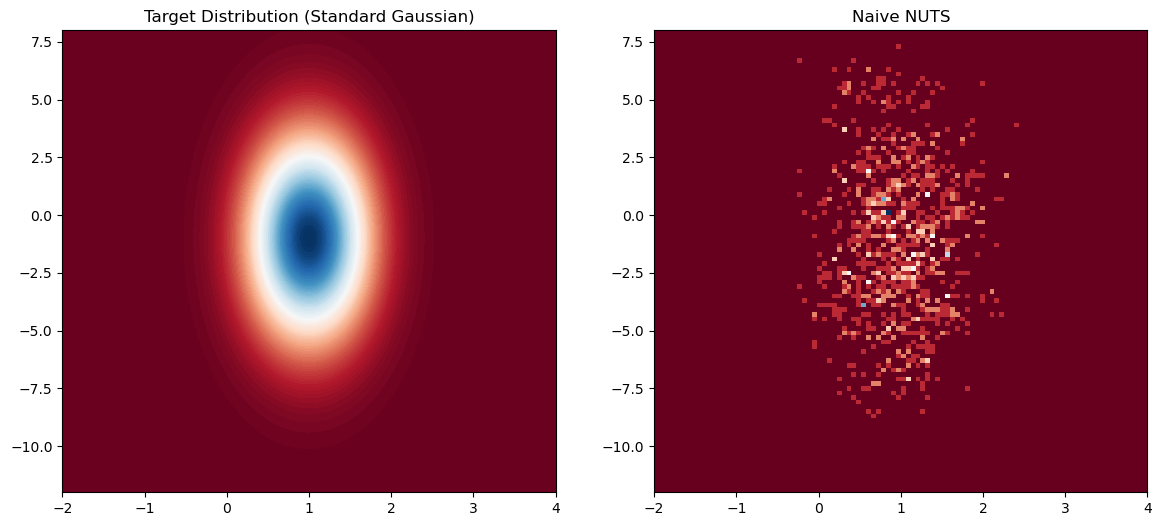

There are total 676 out of 10000 samples do not move w.r.t the previous position.
The proportion of moving is 0.932.


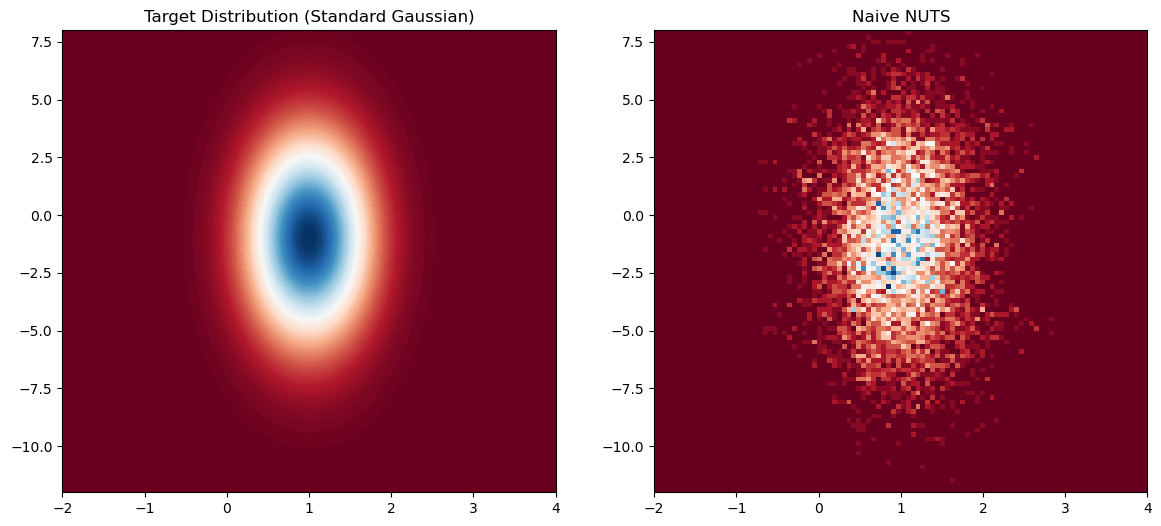

There are total 6611 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.934.


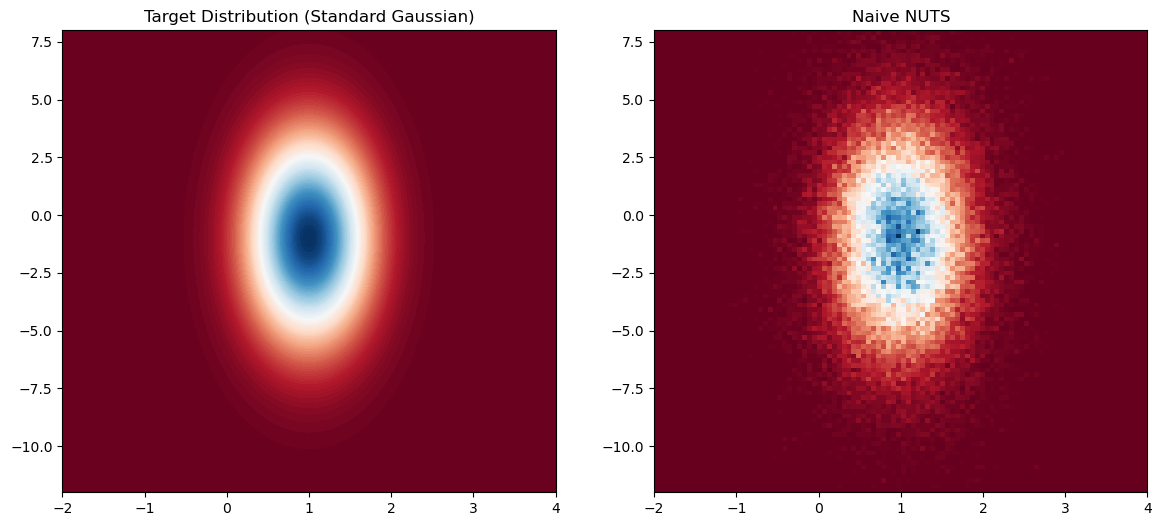

In [312]:
theta0 = np.array([0, -15])
M = np.eye(2)  # identity mass

for num_samples in [10, 100, 1000, int(1e4), int(1e5)]:
    samples, C, _ = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

    # for surf plot of standard bivariate Gaussian 2d
    x_bb = np.linspace(-2, 4, 100)
    y_bb = np.linspace(-12, 8, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_stretch_normal(X_bb, Y_bb))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    plt.title('Target Distribution (Standard Gaussian)')

    #burn_in = int(0.2 * num_samples)  # 20% burn-in
    burn_in = 0  # if we do not consider burnin samples...
    x = samples[burn_in:, 0]
    y = samples[burn_in:, 1]
    plt.subplot(1, 2, 2)
    plt.hist2d(x, y, bins=100, range=[[-2, 4], [-12, 8]], cmap='RdBu', density=True)
    plt.title('Naive NUTS')
    plt.show()

**Case 4: Stretched Gaussian but with huge difference in component variance.**

In [319]:
def example_log_prob(theta):
    x, y = theta
    return -0.5 * ((x - 1)**2/0.005**2 + (y + 1)**2/3**2)

def example_grad_log_prob(theta):
    # Gradient of log-density
    x, y = theta
    partial_x = (1 - x)/0.005**2
    partial_y = -(y + 1)/3**2
    return np.array([partial_x, partial_y])

# log-density function for standard bivariate Gaussian (component form, equivalent to example_log_prob)
def log_extreme_stretch_normal(x, y):
    return -0.5 * ((x - 1)**2/0.005**2 + (y + 1)**2/3**2)

In [325]:
def plot_trajectory_extreme_stretch_Gaussian(all_positions):
    
    plt.figure(figsize=(20, 20))

    # Draw contour background
    x_bb = np.linspace(0.5, 1.5, 100)
    y_bb = np.linspace(-12, 8, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_extreme_stretch_normal(X_bb, Y_bb))
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='Greys')

    # Plot trajectories on top
    cmap = plt.get_cmap('tab10')  # different colors for at most 10 chains (so num_samples <= 10)
    for i, pos_chain in enumerate(all_positions):
        color = cmap(i % 10)
        plt.plot(pos_chain[:, 0], pos_chain[:, 1], linestyle='-', linewidth=1, alpha=0.8, color=color, zorder=3,
                 label=f'Chain {i+1}')
        plt.scatter(pos_chain[:, 0], pos_chain[:, 1], s=50, alpha=0.95, color=color, zorder=4)

        # Highlight first sample, as the taken position sample for the naiveNUTS
        plt.scatter(pos_chain[0, 0], pos_chain[0, 1], s=140, marker='X', edgecolor='k',
                    linewidth=0.7, zorder=6, color=color)

    plt.title(f'Target Distribution (standard Gaussian), start from {all_positions[0][0]}', fontsize=20)
    plt.legend(fontsize=16)
    plt.show()

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

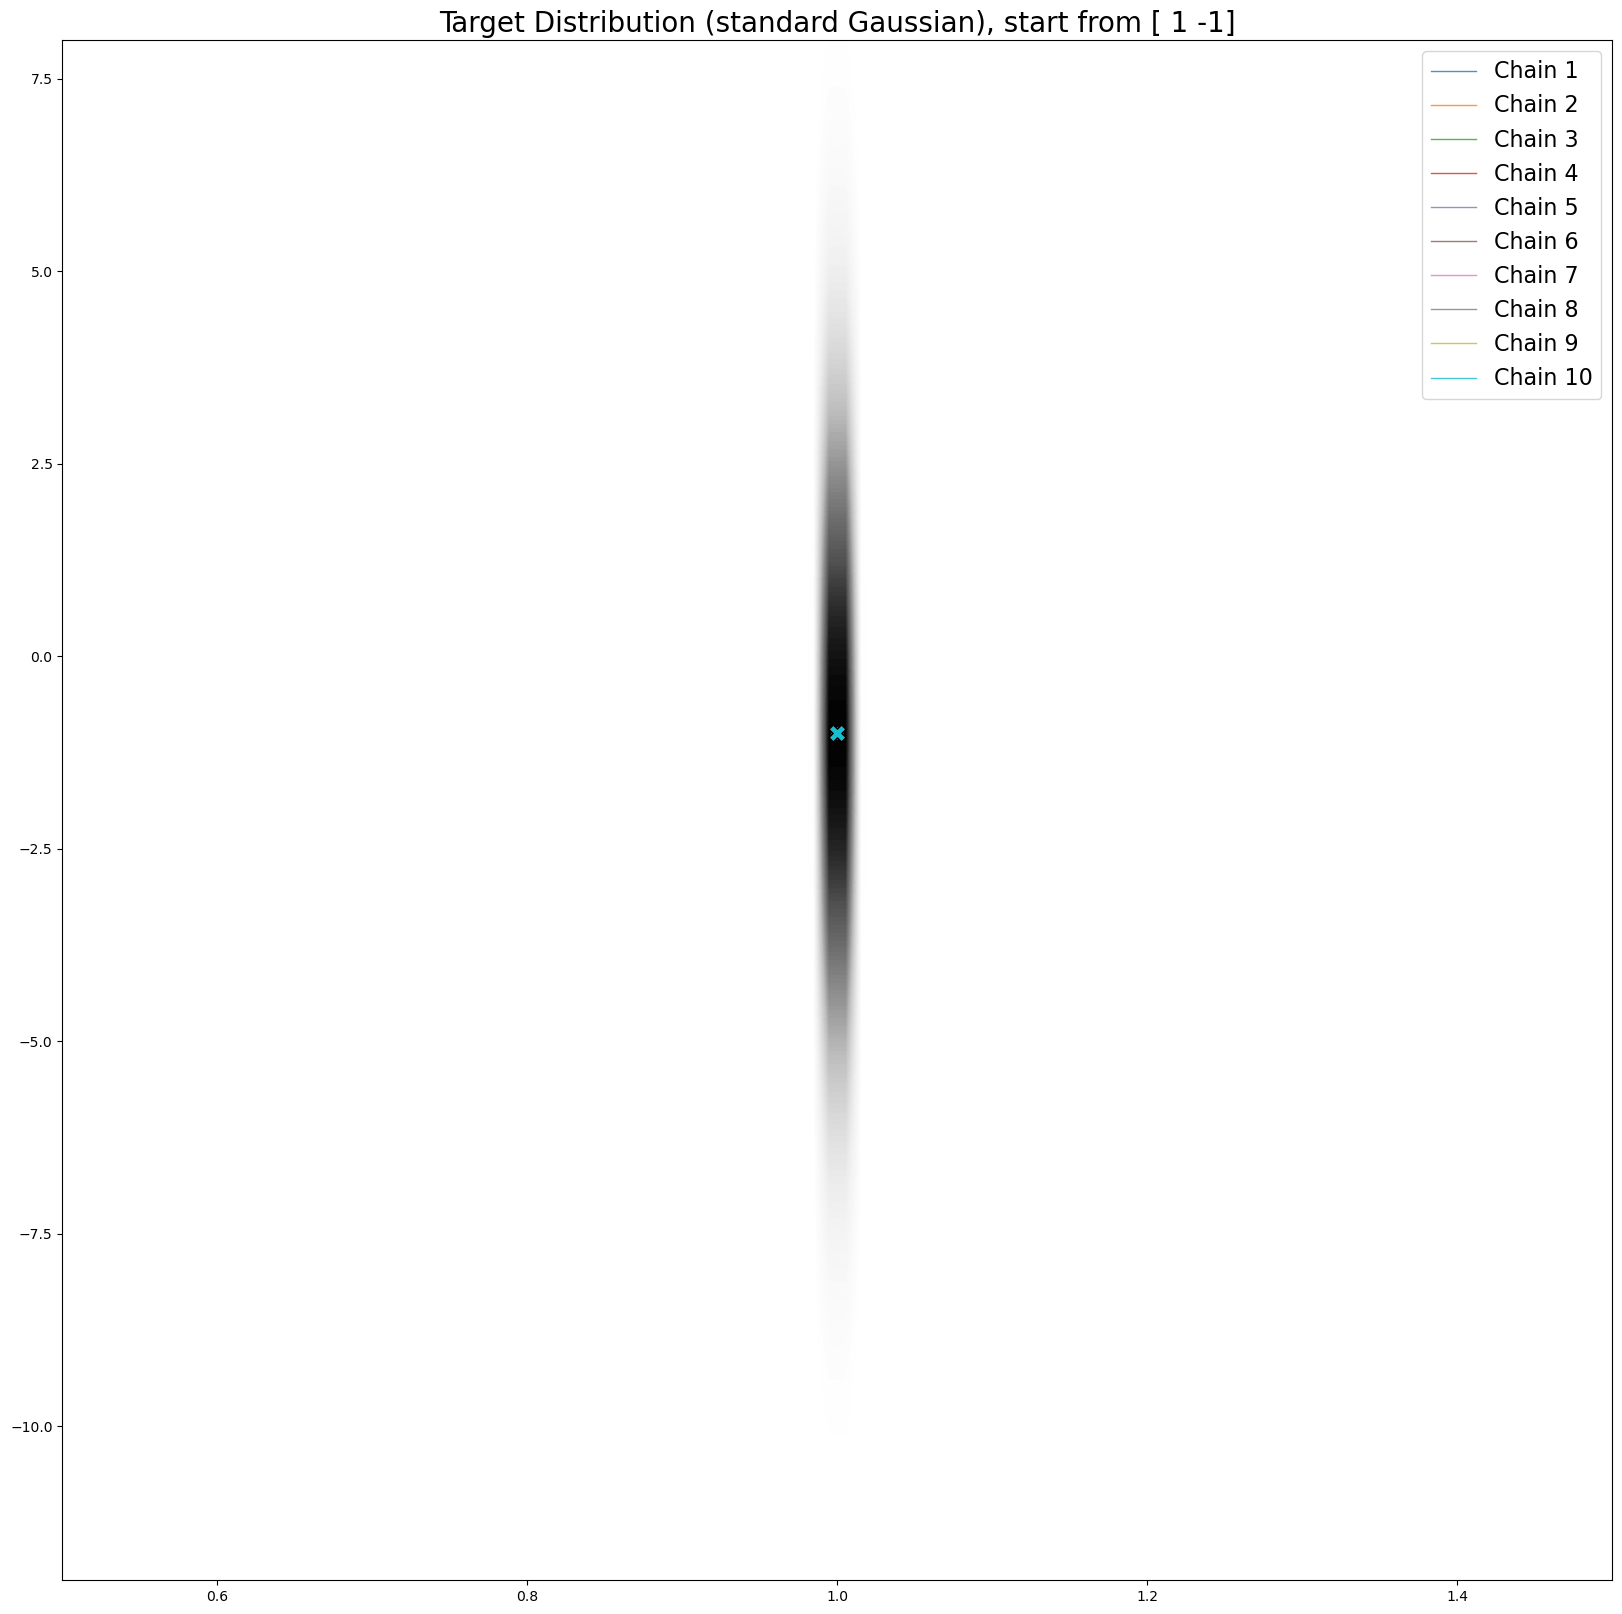

In [326]:
theta0 = np.array([1, -1])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob)

plot_trajectory_extreme_stretch_Gaussian(all_positions)

There are total 9 out of 10 samples do not move w.r.t the previous position.
The proportion of moving is 0.100.


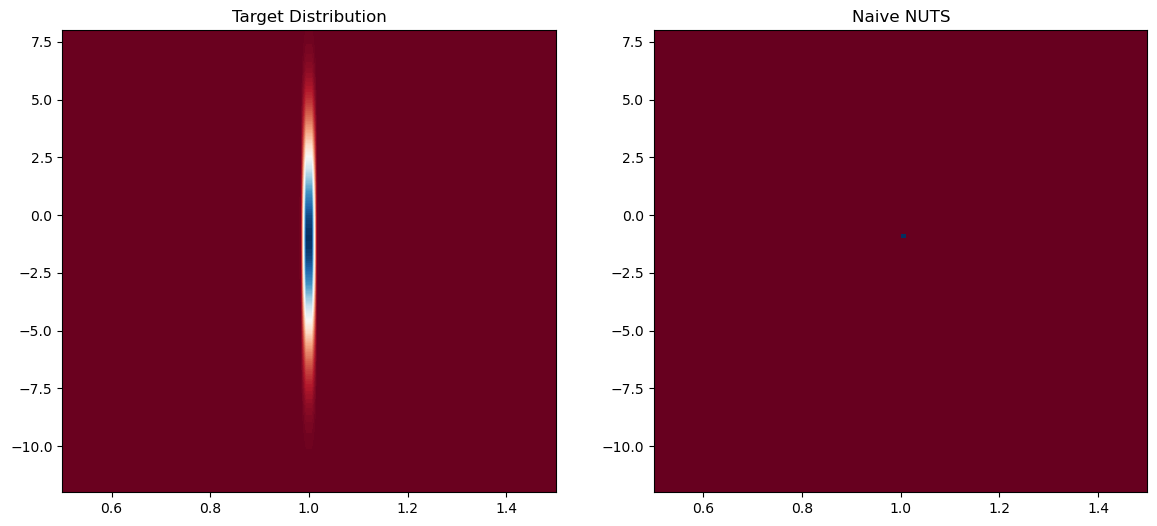

There are total 99 out of 100 samples do not move w.r.t the previous position.
The proportion of moving is 0.010.


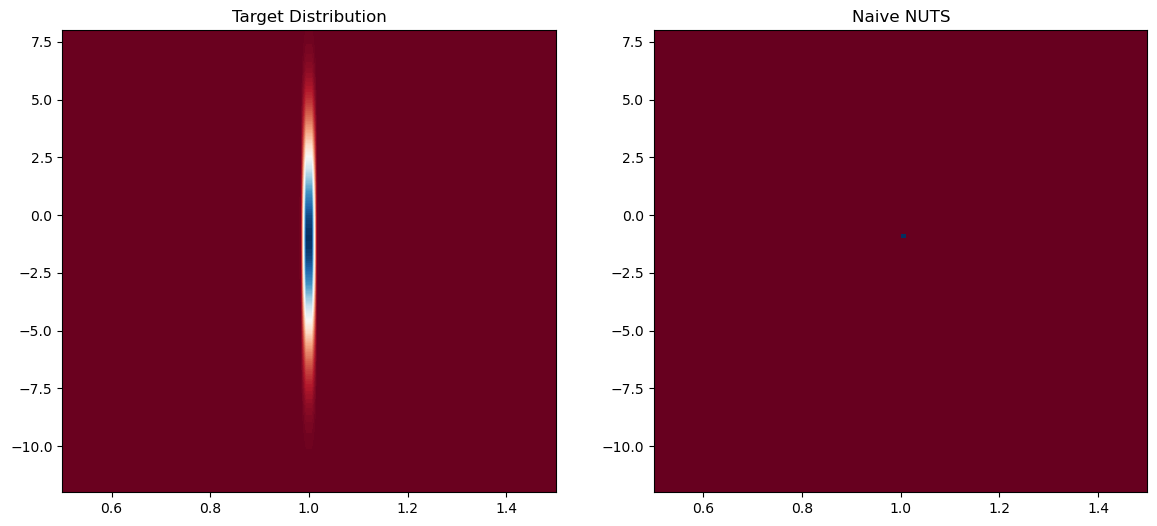

There are total 996 out of 1000 samples do not move w.r.t the previous position.
The proportion of moving is 0.004.


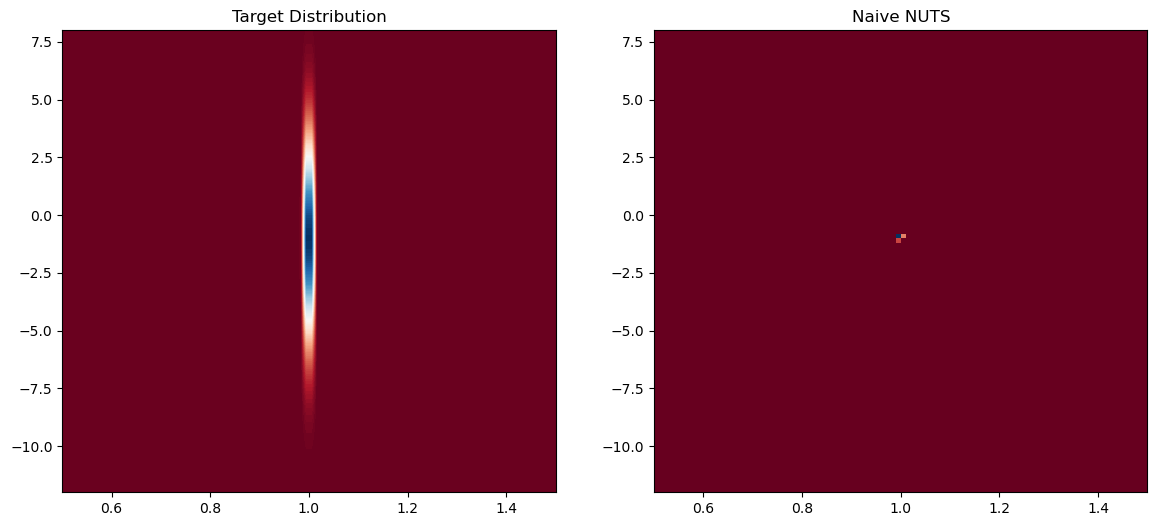

There are total 9977 out of 10000 samples do not move w.r.t the previous position.
The proportion of moving is 0.002.


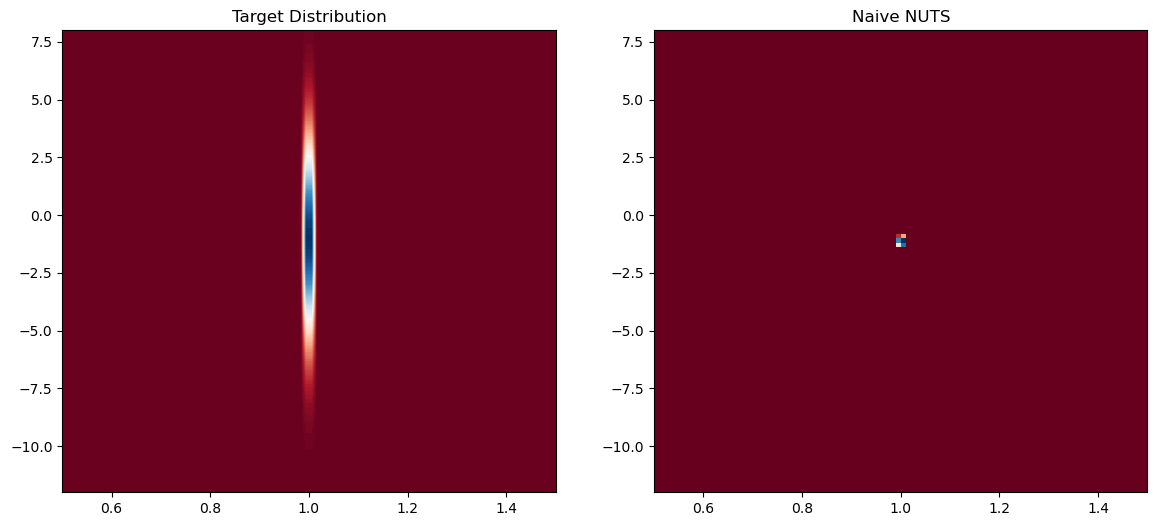

There are total 99887 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.001.


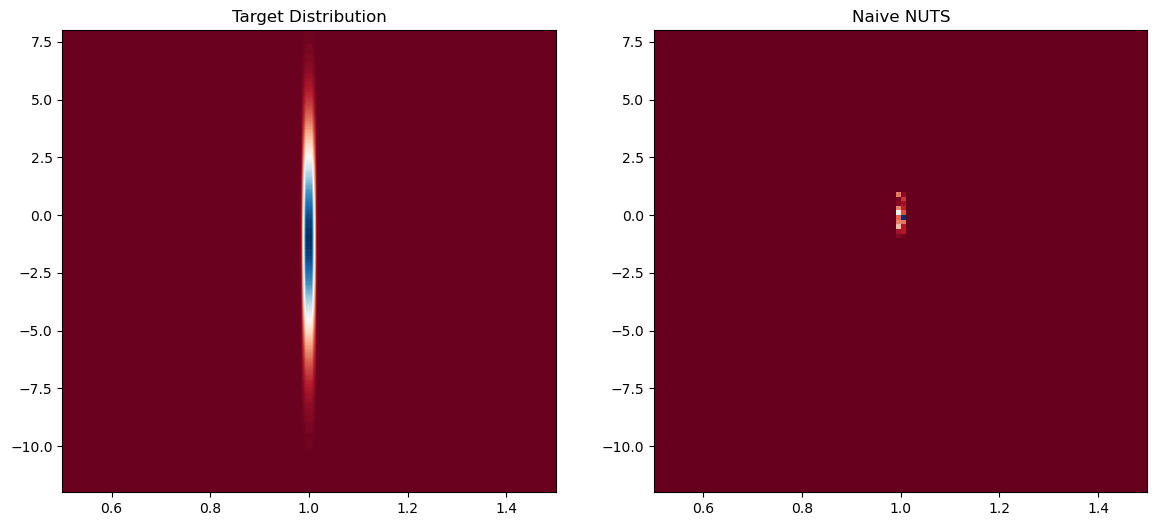

In [327]:
theta0 = np.array([1, -1])
M = np.eye(2)  # identity mass

for num_samples in [10, 100, 1000, int(1e4), int(1e5)]:
    samples, C, _ = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

    # for surf plot of standard bivariate Gaussian 2d
    x_bb = np.linspace(0.5, 1.5, 100)
    y_bb = np.linspace(-12, 8, 100)
    X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
    Z_bb = np.exp(log_extreme_stretch_normal(X_bb, Y_bb))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    plt.title('Target Distribution')

    #burn_in = int(0.2 * num_samples)  # 20% burn-in
    burn_in = 0  # if we do not consider burnin samples...
    x = samples[burn_in:, 0]
    y = samples[burn_in:, 1]
    plt.subplot(1, 2, 2)
    plt.hist2d(x, y, bins=100, range=[[0.5, 1.5], [-12, 8]], cmap='RdBu', density=True)
    plt.title('Naive NUTS')
    plt.show()

There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
There are total 1 out of 1 samples do not move w.r.t the previous position.
The proportion of moving is 0.000.
T

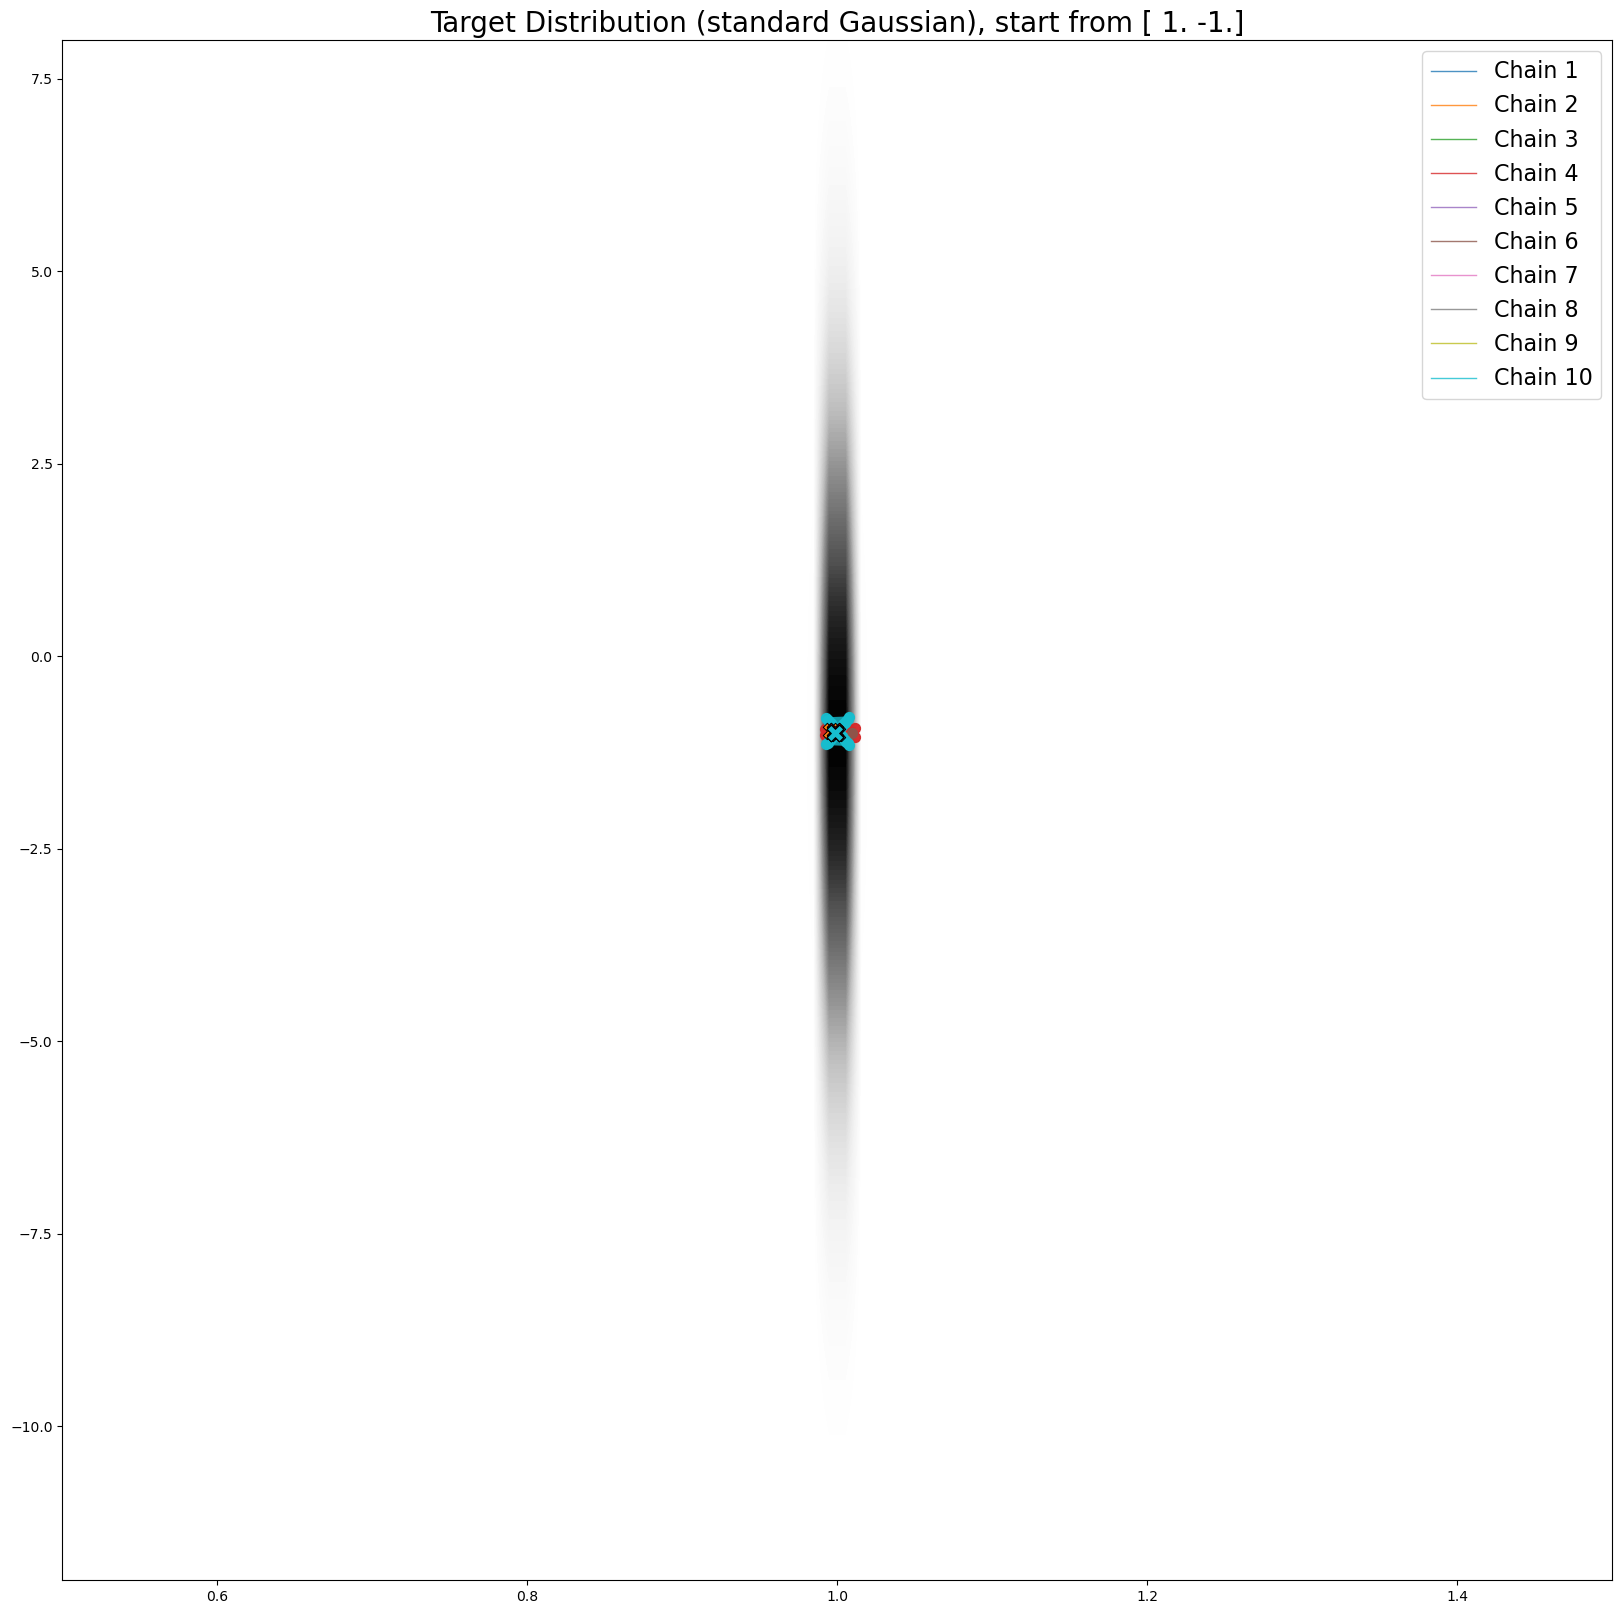

In [328]:
# Alter the stepsize

theta0 = np.array([1, -1])  # always cover most part of the target distribution for the first 10 iterations
num_samples = 10

all_positions = collecting_positions(theta0, num_samples, example_log_prob, example_grad_log_prob, eps=0.01)

plot_trajectory_extreme_stretch_Gaussian(all_positions)  # smaller stepsize enables smaller jump so we will not stop too early

**Case 5: some other weird but extreme distributions.** (Followings come from the Deepseek...)

In [336]:
def trunc_ring(num_samples):
    # Ring with holes, polar form
    angles = np.random.uniform(0, 2*np.pi, num_samples)
    radii = np.random.uniform(1, 2, num_samples)  # inner radius=1, outer radius=2
    # Create holes by removing certain angular ranges
    mask = ~((angles > np.pi/4) & (angles < np.pi/2) | 
             (angles > np.pi) & (angles < 5*np.pi/4))
    ring_x = radii[mask] * np.cos(angles[mask])  # x in polar form
    ring_y = radii[mask] * np.sin(angles[mask])  # y in polar form

    return (ring_x, ring_y)

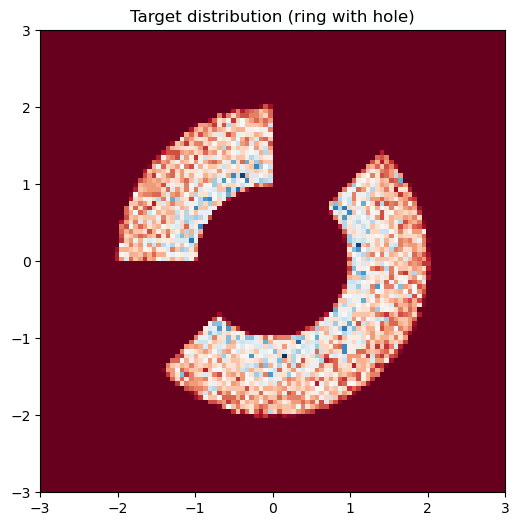

In [417]:
trunc_ring_sample = trunc_ring(30000)

plt.figure(figsize=(6, 6))
plt.hist2d(x=trunc_ring_sample[0], y=trunc_ring_sample[1], bins=100, range=[[-3, 3], [-3, 3]], 
           cmap='RdBu', density=True)
plt.title('Target distribution (ring with hole)')
plt.show()

In [410]:
def angle_justification(theta):
    """
    Justify whether the given angle lie in the accepted region,
    as the complement of (pi/4, pi/2) and (pi, 5*pi/4).

    Args:
        theta (np.ndarray): the angle(s) for justification.
    Return:
        (bool) results showing whether the angle lies in the acceptable region or not.
    """

    # Angle theta assumed in [0, 2*pi), return True if in A
    a1 = (theta > np.pi/4) & (theta < np.pi/2)  # rejected region 1
    a2 = (theta > np.pi) & (theta < 5 * np.pi/4)  # rejected region 2
    # We will reject once the angle lie in either a1 or a2
    # hence we will accept its negation, using bitwise form
    return ~(a1 | a2)

In [423]:
tmp = np.zeros((3,2))

tmp[0] = [1,2]
tmp

array([[1., 2.],
       [0., 0.],
       [0., 0.]])

In [427]:
# log-density function component form
def log_trunc_ring(x, y):
    # Transform into the polar form
    r = np.sqrt(x**2 + y**2)
    # robust angle in [0, 2*pi)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)

    # Define the accepted region
    accept_region = (r >= 1.0) & (r <= 2.0) & angle_justification(theta)

    log_prob_val = np.full_like(r, fill_value=-np.inf)  # initialise, default value as -np.inf for rejected regions
    if np.any(accept_region):
        log_prob_val[accept_region] = np.log(2/(3*np.pi)) - np.log(r[accept_region])

    return log_prob_val


def example_log_prob(theta):
    x, y = theta
    log_prob_val = log_trunc_ring(x, y)

    return log_prob_val


def example_grad_log_prob(theta):
    # Gradient of log-density
    x, y = theta
    
    # Transform into the polar form
    r = np.sqrt(x**2 + y**2)
    # robust angle in [0, 2*pi)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)

    # Define the accepted region
    accept_region = (r >= 1.0) & (r <= 2.0) & angle_justification(theta)

    if accept_region:
        # Compute the partial derivatives
        partial_x = -np.log(2/(3*np.pi)) * x * r**(-3)
        partial_y = -np.log(2/(3*np.pi)) * y * r**(-3)
    else:
        partial_x, partial_y = 0, 0

    return np.array([partial_x, partial_y])

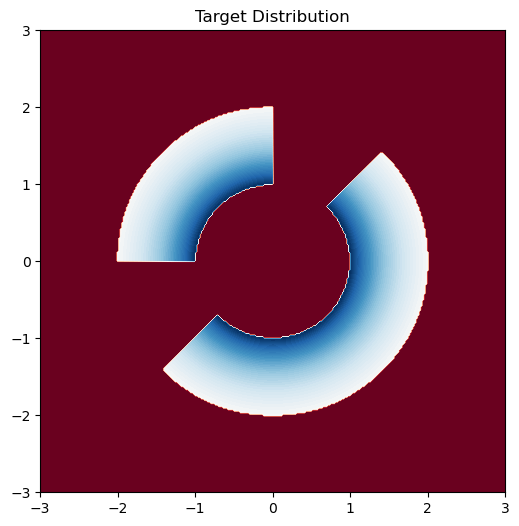

In [428]:
# for surf plot of standard bivariate Gaussian 2d
x_bb = np.linspace(-3, 3, 300)
y_bb = np.linspace(-3, 3, 300)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)   # shape (len(y_bb), len(x_bb))
Z_bb = np.exp(log_trunc_ring(X_bb, Y_bb))   # vectorised: zeros where log=-inf

plt.figure(figsize=(6, 6))
cnt = plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution')
plt.show()

In [429]:
example_grad_log_prob(theta0)

array([ 0.5480767, -0.5480767])

There are total 3358 out of 10000 samples do not move w.r.t the previous position.
The proportion of moving is 0.664.


Text(0.5, 1.0, 'Naive NUTS')

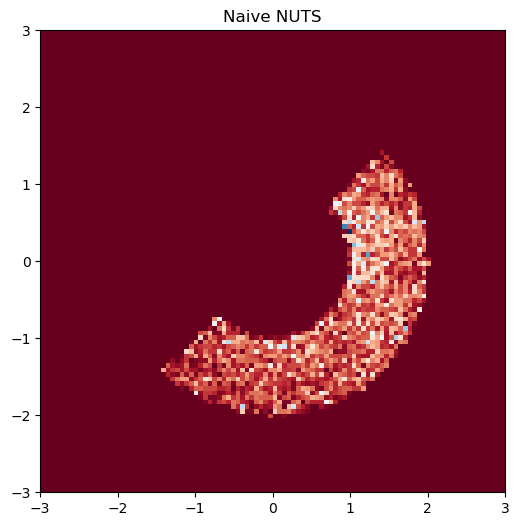

In [432]:
theta0 = np.array([1, -1])
M = np.eye(2)  # identity mass
num_samples = int(1e4)

samples, C, _ = naive_NUTS(theta0, num_samples, example_log_prob, example_grad_log_prob, M)  # approximate 1.5 min on PC (but with overflow)

burn_in = 0  # if we do not consider burnin samples...
x = samples[burn_in:, 0]
y = samples[burn_in:, 1]
plt.figure(figsize=(6, 6))
plt.hist2d(x, y, bins=100, range=[[-3, 3], [-3, 3]], cmap='RdBu', density=True)
plt.title('Naive NUTS')

---

Generating weird banana distributions...


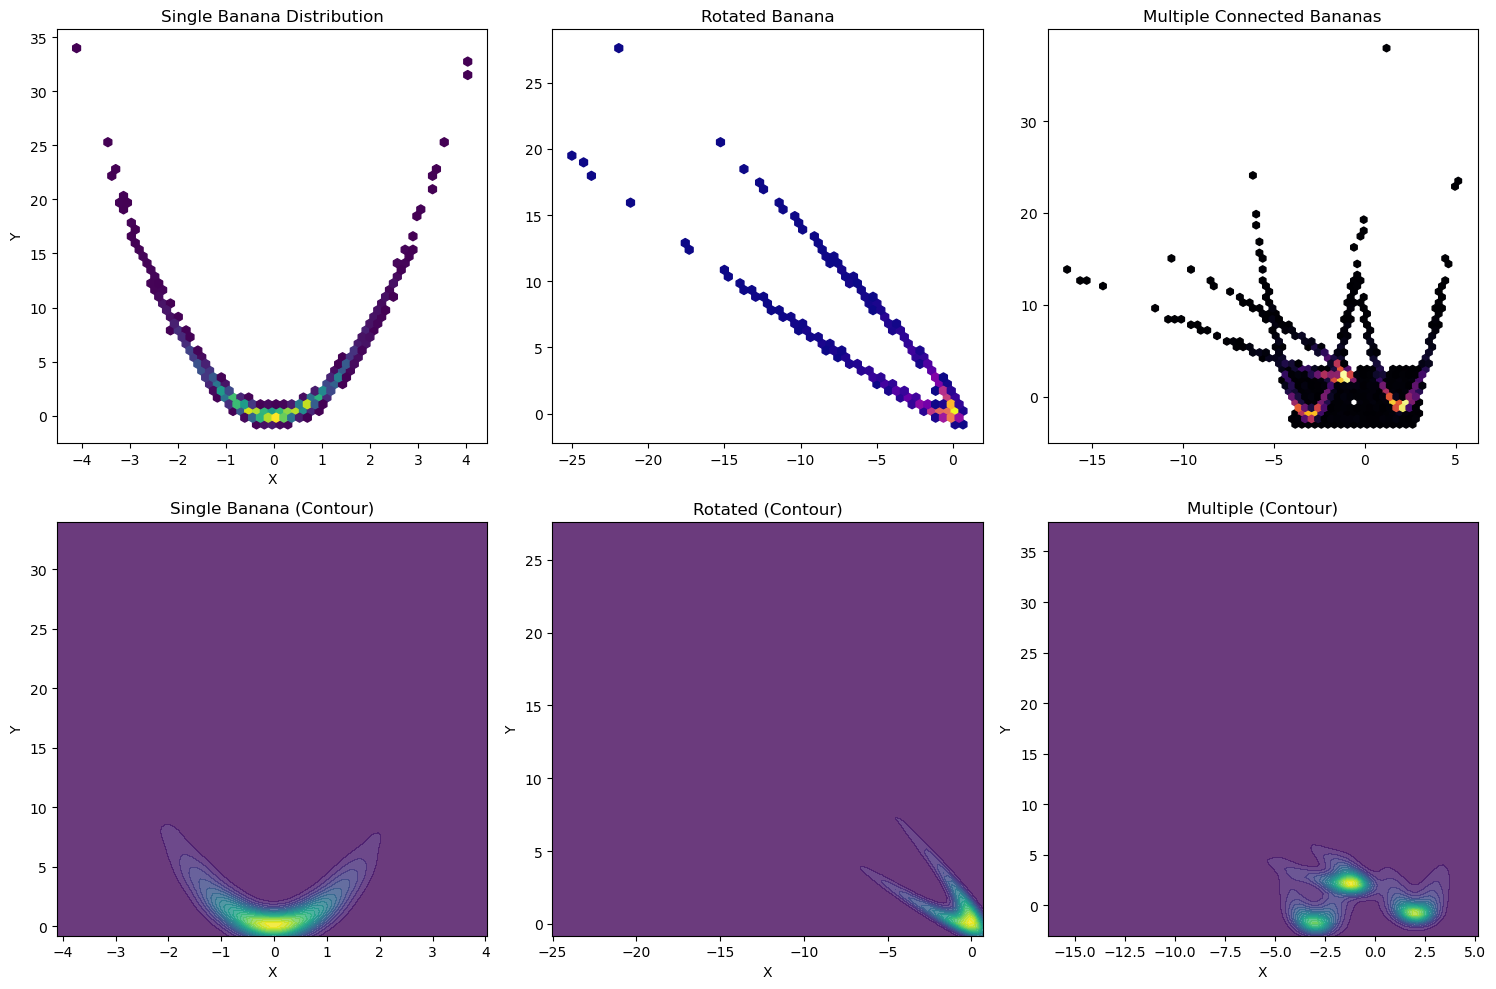

In [433]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

def generate_banana_distribution(n_samples=10000, a=2, b=0.5, rotate=False):
    """
    Generate banana-shaped distribution
    
    Parameters:
    n_samples: number of samples
    a: curvature parameter (higher = more curved)
    b: width parameter
    rotate: whether to rotate the banana
    """
    # Generate from standard bivariate normal
    X = np.random.randn(n_samples)
    Y = np.random.randn(n_samples)
    
    # Apply banana transformation
    U = X
    V = a * X**2 + b * Y
    
    if rotate:
        # Rotate by 45 degrees
        theta = np.pi / 4
        U_rot = U * np.cos(theta) - V * np.sin(theta)
        V_rot = U * np.sin(theta) + V * np.cos(theta)
        return U_rot, V_rot
    
    return U, V

def generate_multi_banana(n_samples=15000, n_bananas=3):
    """
    Generate multiple connected bananas
    """
    np.random.seed(42)
    
    # Generate bananas at different positions
    all_points = []
    
    # Banana 1
    U1, V1 = generate_banana_distribution(n_samples//n_bananas, a=2, b=0.3)
    U1 = U1 * 0.8 + 2
    V1 = V1 * 0.8 - 1
    
    # Banana 2
    U2, V2 = generate_banana_distribution(n_samples//n_bananas, a=1.8, b=0.4, rotate=True)
    U2 = U2 * 0.7 - 1
    V2 = V2 * 0.7 + 2
    
    # Banana 3
    U3, V3 = generate_banana_distribution(n_samples//n_bananas, a=2.2, b=0.35)
    U3 = U3 * 0.9 - 3
    V3 = V3 * 0.9 - 2
    
    # Combine with some overlap
    U = np.concatenate([U1, U2, U3])
    V = np.concatenate([V1, V2, V3])
    
    # Add some bridging points between bananas
    n_bridge = n_samples // 10
    bridge_U = np.random.uniform(-4, 3, n_bridge)
    bridge_V = np.random.uniform(-3, 3, n_bridge)
    
    U = np.concatenate([U, bridge_U])
    V = np.concatenate([V, bridge_V])
    
    return U, V

def plot_distributions():
    """Plot various weird distributions"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Single banana
    U, V = generate_banana_distribution(5000, a=2, b=0.3)
    axes[0, 0].hexbin(U, V, gridsize=50, cmap='viridis', mincnt=1)
    axes[0, 0].set_title('Single Banana Distribution')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')
    
    # Rotated banana
    U_rot, V_rot = generate_banana_distribution(5000, a=2, b=0.3, rotate=True)
    axes[0, 1].hexbin(U_rot, V_rot, gridsize=50, cmap='plasma', mincnt=1)
    axes[0, 1].set_title('Rotated Banana')
    
    # Multiple bananas
    U_multi, V_multi = generate_multi_banana(10000, n_bananas=3)
    axes[0, 2].hexbin(U_multi, V_multi, gridsize=60, cmap='inferno', mincnt=1)
    axes[0, 2].set_title('Multiple Connected Bananas')
    
    # Contour plots
    for i, (U_data, V_data, title, ax) in enumerate([
        (U, V, 'Single Banana (Contour)', axes[1, 0]),
        (U_rot, V_rot, 'Rotated (Contour)', axes[1, 1]),
        (U_multi, V_multi, 'Multiple (Contour)', axes[1, 2])
    ]):
        # Kernel Density Estimation
        from scipy.stats import gaussian_kde
        values = np.vstack([U_data, V_data])
        kernel = gaussian_kde(values)
        
        # Create grid
        xmin, xmax = U_data.min(), U_data.max()
        ymin, ymax = V_data.min(), V_data.max()
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        
        ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.8)
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()

# Generate and plot
if __name__ == "__main__":
    print("Generating weird banana distributions...")
    
    # Simple visualization
    plot_distributions()

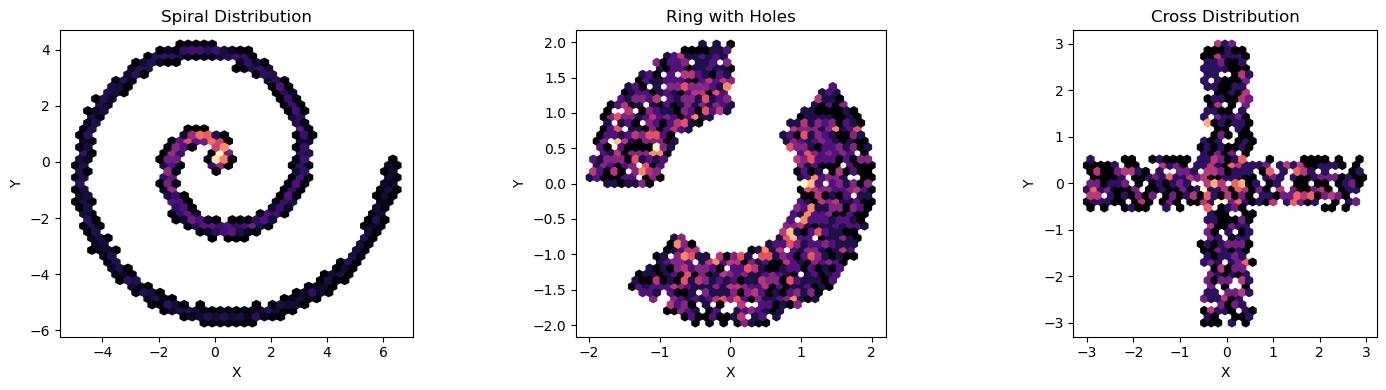

In [434]:
def generate_weird_distributions():
    """Generate various weird 2D distributions"""
    
    # 1. Spiral distribution
    n = 5000
    t = np.linspace(0, 4*np.pi, n)
    r = 0.5 * t
    spiral_x = r * np.cos(t) + np.random.randn(n) * 0.1
    spiral_y = r * np.sin(t) + np.random.randn(n) * 0.1
    
    # 2. Ring with holes, 3000 samples, polar form
    angles = np.random.uniform(0, 2*np.pi, 3000)
    radii = np.random.uniform(1, 2, 3000)  # inner radius=1, outer radius=2
    # Create holes by removing certain angular ranges
    mask = ~((angles > np.pi/4) & (angles < np.pi/2) | 
             (angles > np.pi) & (angles < 5*np.pi/4))
    ring_x = radii[mask] * np.cos(angles[mask])  # x in polar form
    ring_y = radii[mask] * np.sin(angles[mask])  # y in polar form
    
    # 3. Cross shape
    cross_x = []
    cross_y = []
    for _ in range(1000):
        if np.random.random() > 0.5:
            cross_x.append(np.random.uniform(-3, 3))
            cross_y.append(np.random.uniform(-0.5, 0.5))
        else:
            cross_x.append(np.random.uniform(-0.5, 0.5))
            cross_y.append(np.random.uniform(-3, 3))
    
    return (spiral_x, spiral_y), (ring_x, ring_y), (np.array(cross_x), np.array(cross_y))

# Plot these weird distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
distributions = generate_weird_distributions()
titles = ['Spiral Distribution', 'Ring with Holes', 'Cross Distribution']

for (x, y), ax, title in zip(distributions, axes, titles):
    ax.hexbin(x, y, gridsize=40, cmap='magma', mincnt=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Heatmap investigation

Starting from the initial point, run 1 NUTS tree construction, repeat this process for many times and record the final sample, also plot the heatmap.

#### Case 1: standard normal distribution

In [435]:
# still should first run the adaptive scheme to ensure the jump...

theta0 = np.array([0.0, 0.0])
M = np.eye(2)  # identity mass
num_samples = int(1e5)  # integer form is necessary
num_samples_adapt = 50000  # number of samples for adaptation
target_accept_rate = 0.65  # commonly used target acceptance rate delta

# initial momentum r0 (example)
r0 = np.random.multivariate_normal(mean=np.zeros(2), cov=M)

def example_log_prob(theta):
    # Standard normal log-density (un-normalised posterior):
    return -0.5 * np.dot(theta, theta)

def example_grad_log_prob(theta):
    # Gradient of log-density
    return -theta

samples, eps_list, H_NUTS_history, n_alpha_history, h_NUTS_history = adaptive_NUTS(theta0, num_samples, num_samples_adapt, target_accept_rate,
                        example_log_prob, example_grad_log_prob, M)  # less than 1 min, superfast since allowing adaptation (larger stepsize allowed)


There are total 25054 out of 100000 samples do not move w.r.t the previous position.
The proportion of moving is 0.749.


In [482]:
adapted_eps = eps_list[-1]  # record the final stepsize after adaption

# Now we run the naive NUTS by proposing just one jump with this adapted stepsize, with the starting point theta0
# We repeat this process for 10000 times to get 10000 possible 'instant jumps' from theta0
instant_jump_sample = []
for _ in range(100000):
    samples, C, avg_accept_prob = naive_NUTS(theta0, 1, example_log_prob, example_grad_log_prob, M, 
                                             eps=adapted_eps, monitor_results_print=False)
    instant_jump_sample.append(samples.reshape(-1))  # reshape

In [ ]:
import seaborn as sns

# Assuming instant_jump_sample has been generated as in your code
# Convert to numpy array for easier manipulation
samples_array = np.array(instant_jump_sample)

# If instant_jump_sample has nested structure (list of lists), flatten it
if samples_array.ndim > 2:
    # Assuming shape is (100, 1, 2) - adjust based on your actual structure
    samples_array = samples_array.squeeze()

# Extract x and y coordinates
x_samples = samples_array[:, 0]
y_samples = samples_array[:, 1]

# Create figure
plt.figure(figsize=(10, 8))

# Create grid for contour plot
x_lim = max(abs(x_samples.min()), abs(x_samples.max())) * 1.2
y_lim = max(abs(y_samples.min()), abs(y_samples.max())) * 1.2
x = np.linspace(-x_lim, x_lim, 200)
y = np.linspace(-y_lim, y_lim, 200)
X, Y = np.meshgrid(x, y)

# Calculate standard normal PDF
# 2D standard normal: f(x,y) = (1/(2π)) * exp(-0.5*(x² + y²))
Z = (1/(2*np.pi)) * np.exp(-0.5*(X**2 + Y**2))

# Plot contour of standard normal as background
contour = plt.contour(X, Y, Z, levels=10, colors='gray', alpha=0.5, linewidths=0.5)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2f')

# Plot heatmap/histogram of the samples
# Using 2D histogram
plt.hist2d(x_samples, y_samples, bins=100, cmap='Reds', alpha=1, 
           range=[[-x_lim, x_lim], [-y_lim, y_lim]], density=True)

# Alternative: using hexbin for smoother representation
#plt.hexbin(x_samples, y_samples, gridsize=30, cmap='Reds', alpha=0.7, 
#            extent=[-x_lim, x_lim, -y_lim, y_lim], mincnt=1)

# Add colorbar
plt.colorbar(label='Sample Density')

# Add starting point marker
if 'theta0' in locals():
    plt.scatter(theta0[0], theta0[1], color='blue', s=100, label='Starting point θ₀', 
                edgecolors='white', linewidth=2, zorder=5)

# Labels and title
plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.title('Heatmap of Instant Jumps from NUTS with Standard Normal Contours')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

# For a different visualization style using KDE instead of histogram:
plt.figure(figsize=(10, 8))

# Contour background
plt.contour(X, Y, Z, levels=10, colors='gray', alpha=0.3, linewidths=0.5)

# KDE plot of samples
sns.kdeplot(x=x_samples, y=y_samples, cmap='Reds', fill=True, alpha=0.6, 
            levels=20, thresh=0.05)

# Scatter plot of individual samples
#plt.scatter(x_samples, y_samples, alpha=0.3, s=20, color='red', edgecolors='white', linewidth=0.5)

# Add starting point
if 'theta0' in locals():
    plt.scatter(theta0[0], theta0[1], color='blue', s=150, label='θ₀', 
                edgecolors='white', linewidth=2, zorder=5)

plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.title('KDE of Instant Jumps with Standard Normal Contours')
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.axis('equal')
plt.tight_layout()
plt.show()

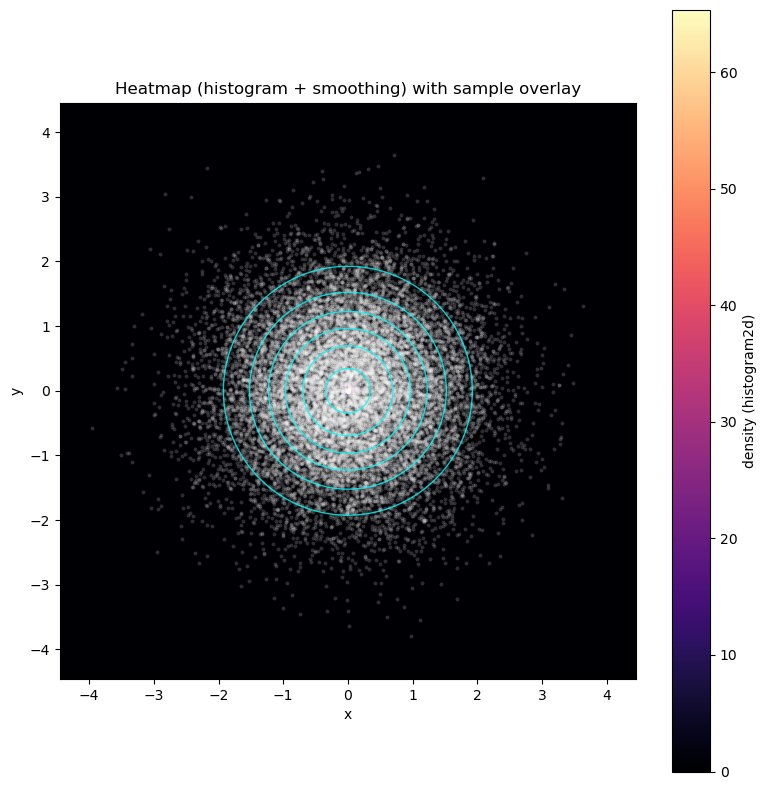

In [485]:
import numpy as np
import matplotlib.pyplot as plt

# --- replace with your instant_jump_sample extraction code ---
# For demo, I'll create `samples` if your variable isn't in the kernel.
try:
    instant_jump_sample
    # convert to (N,2)
    flat = []
    for s in instant_jump_sample:
        a = np.asarray(s).reshape(-1)
        if a.size >= 2:
            flat.append(a[:2])
    samples = np.vstack(flat)
except Exception:
    rng = np.random.default_rng(2)
    s1 = rng.multivariate_normal(mean=[-1.0, -1.0], cov=[[0.08, 0],[0,0.03]], size=1500)
    s2 = rng.multivariate_normal(mean=[ 1.0,  1.0], cov=[[0.05, 0],[0,0.05]], size=1500)
    samples = np.vstack([s1, s2])
    print("Using demo samples")

# histogram
nbins = 200
margin = 0.5
global_range = max(np.max(np.abs(samples)) + margin, 2.5)
x_edges = np.linspace(-global_range, global_range, nbins+1)
y_edges = np.linspace(-global_range, global_range, nbins+1)

H, xe, ye = np.histogram2d(samples[:, 0], samples[:, 1], bins=[x_edges, y_edges], density=True)
# smoothing (optional) - simple gaussian blur using convolution via scipy if available
try:
    from scipy.ndimage import gaussian_filter
    Hs = gaussian_filter(H, sigma=1.0)
except Exception:
    Hs = H

# pcolormesh expects the bin edges grid
Xc, Yc = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots(figsize=(8, 8))
# draw heatmap with pcolormesh: use cmap with good contrast
pcm = ax.pcolormesh(Xc, Yc, Hs.T, cmap='magma', shading='auto')  # Hs.T so orientation matches xy
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('density (histogram2d)', fontsize=10)

# overlay contour lines (optional)
xx = 0.5*(xe[:-1] + xe[1:])
yy = 0.5*(ye[:-1] + ye[1:])
Xg, Yg = np.meshgrid(xx, yy)
# compute analytic standard normal for reference (optional)
Z_std = (1.0/(2*np.pi)) * np.exp(-0.5*(Xg**2 + Yg**2))
cs = ax.contour(Xg, Yg, Z_std, levels=6, colors='cyan', linewidths=1.0, alpha=0.8)

# scatter lightly on top (small, semi-transparent white markers)
ax.scatter(samples[:,0], samples[:,1], s=8, c='white', alpha=0.18, linewidths=0)

ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Heatmap (histogram + smoothing) with sample overlay')
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# optional smoothing
try:
    from scipy.ndimage import gaussian_filter
    HAVE_SMOOTH = True
except Exception:
    HAVE_SMOOTH = False

def extract_points(instant_jump_sample):
    flat = []
    for s in instant_jump_sample:
        a = np.asarray(s).reshape(-1)
        if a.size >= 2:
            flat.append(a[:2])
    if len(flat) == 0:
        raise ValueError("No usable 2D samples found.")
    return np.vstack(flat)

# ---------------------------
# Replace with your instant_jump_sample if present
# ---------------------------
try:
    instant_jump_sample  # check
    samples = extract_points(instant_jump_sample)
    print("Using instant_jump_sample from the namespace.")
except Exception:
    # demo fallback
    rng = np.random.default_rng(2)
    s1 = rng.multivariate_normal(mean=[-1.0, -1.0], cov=[[0.08, 0],[0,0.03]], size=2000)
    s2 = rng.multivariate_normal(mean=[ 1.0,  1.0], cov=[[0.05, 0],[0,0.05]], size=2000)
    samples = np.vstack([s1, s2])
    print("instant_jump_sample not found — using demo samples.")

# ---------------------------
# Histogram + smoothing
# ---------------------------
nbins = 220             # resolution; increase for finer heatmap
pad = 0.6               # margin around points
global_range = max(np.max(np.abs(samples)) + pad, 2.5)
x_edges = np.linspace(-global_range, global_range, nbins+1)
y_edges = np.linspace(-global_range, global_range, nbins+1)

H, xe, ye = np.histogram2d(samples[:,0], samples[:,1], bins=[x_edges, y_edges], density=True)
# H has shape (len(x_edges)-1, len(y_edges)-1)

# smooth
if HAVE_SMOOTH:
    H_sm = gaussian_filter(H, sigma=1.2)
else:
    H_sm = H  # will use interpolation below

# ---------------------------
# analytic standard normal contour (for alignment)
# ---------------------------
xx = 0.5*(xe[:-1] + xe[1:])
yy = 0.5*(ye[:-1] + ye[1:])
Xg, Yg = np.meshgrid(xx, yy)
Z_std = (1.0/(2*np.pi)) * np.exp(-0.5*(Xg**2 + Yg**2))

# ---------------------------
# Plot: pcolormesh heatmap (NOAA-like) + contours + points
# ---------------------------
fig, ax = plt.subplots(figsize=(9,7))

# choose colormap similar to weather/NOAA maps
cmap = 'turbo' if 'turbo' in plt.colormaps() else 'jet'

# choose whether to use log scaling for colorbar (helps contrast when densities vary a lot)
use_log_scale = False

# pcolormesh expects grid of edges; transpose H_sm so orientation matches x,y
# Note: H (histogram2d) yields H[x_index, y_index], so to map to pcolormesh we transpose
mesh = ax.pcolormesh(xe, ye, H_sm.T,
                     cmap=cmap,
                     shading='auto',
                     norm=LogNorm(vmin=H_sm[H_sm>0].min(), vmax=H_sm.max()) if use_log_scale and np.any(H_sm>0) else None,
                     alpha=1.0)

# colorbar with nice ticks and label
cbar = fig.colorbar(mesh, ax=ax, shrink=0.85, pad=0.02)
cbar.set_label('Estimated density (histogram2d)', fontsize=11)
# optional: set explicit tick locations
cbar_ticks = np.linspace(np.nanmin(H_sm[H_sm>0]) if np.any(H_sm>0) else 0, np.nanmax(H_sm), 6)
if not use_log_scale and np.any(H_sm>0):
    cbar.set_ticks(cbar_ticks)
    cbar.ax.tick_params(labelsize=9)

# overlay analytic standard normal contours (cyan)
levels = np.linspace(0.001, Z_std.max(), 6)[1:]
cs = ax.contour(Xg, Yg, Z_std, levels=levels, colors='cyan', linewidths=1.0, alpha=0.85)
ax.clabel(cs, fmt="%.2e", fontsize=9)

# scatter lightly on top (white points with low alpha so heatmap remains visible)
ax.scatter(samples[:,0], samples[:,1], s=10, color='white', alpha=0.22, linewidths=0)

# aesthetics
ax.set_xlim(xe[0], xe[-1])
ax.set_ylim(ye[0], ye[-1])
ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('y', fontsize=11)
ax.set_title('Heatmap of instant_jump_sample (smoothed histogram) with std-normal contours', fontsize=13)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
# save if desired
# plt.savefig("instant_jump_heatmap_noaa_style.png", dpi=220, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# samples extraction as above
try:
    instant_jump_sample
    flat = []
    for s in instant_jump_sample:
        a = np.asarray(s).reshape(-1)
        if a.size >= 2:
            flat.append(a[:2])
    samples = np.vstack(flat)
except Exception:
    rng = np.random.default_rng(2)
    s1 = rng.multivariate_normal(mean=[-1.0, -1.0], cov=[[0.08, 0],[0,0.03]], size=1500)
    s2 = rng.multivariate_normal(mean=[ 1.0,  1.0], cov=[[0.05, 0],[0,0.05]], size=1500)
    samples = np.vstack([s1, s2])
    print("Using demo samples")

# fit KDE
kde = gaussian_kde(samples.T)

# grid to evaluate on
nb = 300
margin = 0.6
lim = max(np.max(np.abs(samples)) + margin, 2.5)
x = np.linspace(-lim, lim, nb)
y = np.linspace(-lim, lim, nb)
X, Y = np.meshgrid(x, y)
grid_coords = np.vstack([X.ravel(), Y.ravel()])

Z = kde(grid_coords).reshape(X.shape)

fig, ax = plt.subplots(figsize=(8,8))
# contourf background
cf = ax.contourf(X, Y, Z, levels=60, cmap='magma')
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label('KDE density', fontsize=10)

# contour of analytic normal for reference
Z_std = (1.0/(2*np.pi)) * np.exp(-0.5*(X**2 + Y**2))
ax.contour(X, Y, Z_std, levels=6, colors='cyan', linewidths=1.0, alpha=0.8)

# scatter on top (very faint)
ax.scatter(samples[:,0], samples[:,1], s=6, c='white', alpha=0.12, linewidths=0)

ax.set_title('KDE heatmap with sample overlay')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


# Potential research directions:

1. Curse of dimensionality: as parameter dimension increases, even small jump for each component would result a overall large jump for the whole position vector, meaning that we will need smaller stepsizes to control the jump size so the chain would not stop too early, whereas smaller stepsize would result slower convergence and higher sampling cost. Can we propose methods, like resampling in particle filters, to reduce this curse of dimensionality so we can still achieve good sampling while with larger stepsizes?

2. Dataset: can NUTS also works well for Bayesian model on imbalanced datasets? It is trivial that imbalanced datasets would result very skewed likelihood and severely affect the shape of the posterior to be somewhat skewed and concentrated as well.

3. This might be related to point 2, that we may pick some very skewed/concentrated distributions and see the sampling behaviour for some finite number of build tree processes: are the possible position-momentum pairs given lie in just a small proportion of the distribution? If so, how long will it take for the initial position to move to another proportion of the target distribution, and finally cover the whole distribution?  

4. Ergodicity: this is more theory based - can we write the chain distribution at each time for NUTS and investigate the ergodicity for the chain, also the mixing time along with the total variation distance or Wasserstein distance? 